# some important basics - 
Dolphins can communicate by clicks


*   High freq (up to 130) are typically ecolocation,hunt. 
*   lower for communication
*   [Identification with CPOD](https://www.chelonia.co.uk/discoveries.htm)

## Clustering algorithms to be used at first-
*   K-means
*   DBSCAN










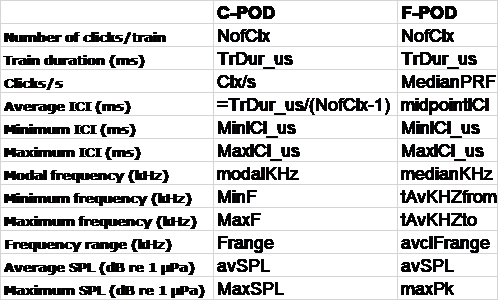

## Packages and loading files

In [1]:
!pip install -q xlrd
!pip install hdbscan
!pip install openpyxl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp39-cp39-linux_x86_64.whl size=825758 sha256=664e8766b7bbe044ae925becefb9f76b77d8b644256cf9800528103975d890ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-r_ow5oq1/wheels/97/2d/1e/d9907e8f806ee949f9effc41004d7f32e862f6f67d9157812d
Successfully built hdbscan
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 28.4 MB/s eta 0:00:00


In [2]:
# General tools-------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import datetime
import random 
from time import time
%matplotlib inline

# Scaling and processing-------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
#Pipeline transformations 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Clustering-------------------------
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN
import hdbscan 

# Scoring-------------------------
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import silhouette_score



#Validation-------------------------
from sklearn.model_selection import train_test_split as split



In [3]:
#Display-------------------------
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 40 )
pd.set_option('display.max_rows' , 50)
pd.options.display.max_rows


50

## PD concat and read excel

In [4]:
#upload all sheets as one
df = pd.concat(pd.read_excel('full_train.xlsx', sheet_name=None), ignore_index=True)


## All data

In [5]:
all_train = df #just to not reload ever mistake

In [ ]:
all_train.nunique()

File                35
TrnID              126
Time             26333
Min              24698
SpClass           1434
                 ...  
PreIPIratio        495
Post1IPIratio      463
Post2IPIratio      483
EndIPIratio        354
EncSpN               0
Length: 76, dtype: int64

In [ ]:
all_train.shape

(614765, 76)

In [ ]:
all_train.keys()

### C_pod load and fix

In [ ]:
#Split to C-Pod only
c_pod = all_train.drop(all_train.loc[:, "Unnamed: 32":"EncSpN"].columns, axis = 1)
c_pod.sample(3)

In [ ]:
c_pod.columns 

In [ ]:
to_drop = ['SpClass', 'TrClass','ICIgood',
               'Start', 'TrnID','NofClx']  
c_pod.drop(to_drop, axis=1, inplace=True)
# c_pod.columns = c_pod.columns.str.replace('.', '_')
print(c_pod.shape,)
c_pod.dropna(inplace=True)
print(c_pod.shape,c_pod.File.value_counts())

# Extracting name from Fiile column, assigining them to new column site, dropping File.1
file_val = c_pod['File'].value_counts().keys()
site_name_map = ['Ashdod', 'Michmoret', 'Michmoret', 'Michmoret', 'Michmoret', 'Dor', 'Ashkelon',
                     'Ashkelon','Dor', 'Nahariyya','Ashkelon', 'Dor','Dor',
                     'Dor', 'Gaash', 'Nahariyya',  'Achziv', 'Achziv', 'Dor','Dor', 'Dor',
                     'Gaash', 'Gaash', 'Achziv']
c_pod['site'] = c_pod['File'].replace(file_val, site_name_map)
print(c_pod.site.value_counts())
c_pod = c_pod.rename(columns={'Clx/s': 'MedianPRF', 'modalKHz': 'medianKHz', 'nActualClx': 'NofClx'})
#creating midpointICI
c_pod['midpointICI'] = (c_pod.TrDur_us)/(c_pod.NofClx-1)
#Time df["a"] = pd.to_numeric(df["a"])
c_pod['month'] = pd.to_numeric(c_pod.Time.apply(lambda x: x.strftime('%m')))
c_pod['year'] = pd.to_numeric(c_pod.Time.apply(lambda x: x.strftime('%Y')))
c_pod['hour'] = pd.to_numeric(c_pod.Time.apply(lambda x: x.strftime('%H')))
#Sites
Achzivc = c_pod[c_pod.site.isin(['Achziv'])]
Michmoretc = c_pod[c_pod.site.isin(['Michmoret'])]
Ashdodc = c_pod[c_pod.site.isin(['Ashdod'])]
Ashkelonc = c_pod[c_pod.site.isin(['Ashkelon'])]
Gaashc = c_pod[c_pod.site.isin(['Gaash'])]
Dorc = c_pod[c_pod.site.isin(['Dor'])]

#DatetimeIndex
c_pod.drop('File', axis=1, inplace=True)
tc_pod = c_pod.set_index('Time', drop = False)
tc_pod.index = pd.to_datetime(tc_pod.index)
tc_pod = tc_pod.sort_index()

In [ ]:
#table by site, median , std
ac=Achzivc.describe().round(2)
mi=Michmoretc.describe().round(2)
ash=Ashdodc.describe().round(2)
ak=Ashkelonc.describe().round(2)
ga=Gaashc.describe().round(2)
dor=Dorc.describe().round(2)
with pd.ExcelWriter("For_Yotam/describe tables/describeall_cpod.xlsx") as writer:
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    ac.to_excel(writer, sheet_name="Achziv", index=True)
    mi.to_excel(writer, sheet_name="Michmoret", index=True)
    ash.to_excel(writer, sheet_name="Ashdod", index=True)
    ak.to_excel(writer, sheet_name="Ashkelon", index=True)
    ga.to_excel(writer, sheet_name="Gaash", index=True)
    dor.to_excel(writer, sheet_name="Dor", index=True)

### For Yotam\EDA

#### load..

In [6]:
#Split to F-Pod only
f_pod = all_train.drop(all_train.loc[:, "File":"Unnamed: 34"].columns, axis = 1)
f_pod.sample(3)

Line                                     File.1  TrnID.1  \
538704  45796.0   Ashdod ff 2020 11 16 FPOD_6070 file0.FP3      4.0   
450435  37404.0   Ashdod ff 2020 07 05 FPOD_6068 file0.FP3     23.0   
412088  52544.0  Ashdod f.f 2019 06 21 FPOD_6068 file0.FP3     17.0   

                    Time.1       Min.1    ON  OpThreshold  ClksThisMin.1  \
538704 2021-03-20 21:34:00  63757294.0  True          5.0          580.0   
450435 2020-08-05 17:50:00  63430190.0  True          2.0         9365.0   
412088 2019-10-23 03:22:00  63016042.0  True          6.0         2512.0   

        SpClass.1    Qn ICIgood.1  tWUTrisk Marked    Start.1  NofClx.1  \
538704  Other cet   Mod     False       0.0  False  4035908.0       8.0   
450435  Other cet  High     False       0.0  False  4918809.0      10.0   
412088  Other cet   Mod     False       0.0  False  8400902.0       9.0   

        nActualClx.1  medianKHz  avEndF.1  nRisingIPIs  avSPL.1  ...  avBWx8  \
538704           8.0       41.0      58.0          0.0    178.0  ...    15.0   
450435          10.0       55.0      77.0          0.0    357.0  ...    15.0   
412088           9.0       61.0      65.0          0.0    219.0  ...    15.0   

        TrDur_us.1  MedianPRF  nICIrising  MinICI_us.1  midpointICI  \
538704    131147.0       61.0         3.0       3243.0       3243.0   
450435   1111111.0        9.0         4.0      22155.0      23100.0   
412088    818181.0       11.0         4.0      14766.0      16686.0   

        MaxICI_us.1  ClkNofMinICI  ClkNofMaxICI  NofClstrs.1  avClstrNx8  \
538704       6582.0           2.0           5.0          8.0         8.0   
450435      24202.0           4.0           8.0         10.0       270.0   
412088      20846.0           7.0           9.0          3.0        11.0   

        avclF0  avclF1  avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  \
538704     0.0     0.0     79.0            0.67         0.81           0.99   
450435   107.0    74.0     71.0            0.86         0.86           1.08   
412088   100.0     0.0     69.0            0.77         1.10           1.39   

        Post2IPIratio  EndIPIratio  EncSpN  
538704           0.00         1.03     NaN  
450435           1.20         1.19     NaN  
412088           1.64         0.92     NaN  

[3 rows x 41 columns]

In [ ]:
to_drop = ['SpClass.1', 'Marked', 'tWUTrisk', 'Qn', 'ICIgood.1', 'Line', 'EncSpN',
               'Start.1', 'TrnID.1', 'OpThreshold', 'avPkAt', 'nActualClx.1', 'avBWx8']  # ,'Min.1''ON',
f_pod.drop(to_drop, axis=1, inplace=True)
f_pod.columns = f_pod.columns.str.replace('.', '_')
f_pod.dropna(inplace=True)

# Extracting name from Fiile column, assigining them to new column site, dropping File.1
file_val = f_pod['File_1'].value_counts().keys()
site_name_map = ['Ashdod', 'Ashdod', 'Ashdod', 'Ashdod', 'Ashdod', 'Ashdod', 'Michmoret',
                     'Michmoret', 'Michmoret', 'Michmoret', 'Michmoret', 'Ashdod', 'Ashkelon',
                     'Ashkelon', 'Ashkelon', 'Achziv', 'Achziv', 'Gaash', 'Achziv', 'Gaash', 'Ashdod',
                     'Dor', 'Dor', 'Gaash', 'Ashkelon', 'Ashdod', 'Dor', 'Dor', 'Dor', 'Ashdod', 'Ashdod']
f_pod['site'] = f_pod['File_1'].replace(file_val, site_name_map)
f_pod = f_pod.rename(columns={'TrDur_us_1': 'TrDur_us', 'NofClx_1': 'NofClx', 'avSPL_1': 'avSPL', 'MinICI_us_1': 'MinICI_us', 'MaxICI_us_1': 'MaxICI_us', 'Min_1': 'Min', 'ClksThisMin_1': 'ClksThisMin'})

#Time df["a"] = pd.to_numeric(df["a"])
f_pod['month'] = pd.to_numeric(f_pod.Time_1.apply(lambda x: x.strftime('%m')))
f_pod['year'] = pd.to_numeric(f_pod.Time_1.apply(lambda x: x.strftime('%Y')))
f_pod['hour'] = pd.to_numeric(f_pod.Time_1.apply(lambda x: x.strftime('%H')))
#Sites
Achziv = f_pod[f_pod.site.isin(['Achziv'])]
Michmoret = f_pod[f_pod.site.isin(['Michmoret'])]
Ashdod = f_pod[f_pod.site.isin(['Ashdod'])]
Ashkelon = f_pod[f_pod.site.isin(['Ashkelon'])]
Gaash = f_pod[f_pod.site.isin(['Gaash'])]
Dor = f_pod[f_pod.site.isin(['Dor'])]

#DatetimeIndex
f_pod.drop('File_1', axis=1, inplace=True)
tf_pod = f_pod.set_index('Time_1', drop = False)
tf_pod.index = pd.to_datetime(tf_pod.index)
tf_pod = tf_pod.sort_index()

In [ ]:
# paint = f_pod[['File_1', 'Time_1', 'ClksThisMin_1', 'NofClx_1', 'medianKHz',
#        'avEndF_1', 'nRisingIPIs', 'avSPL_1', 'TrDur_us_1', 'MedianPRF',
#        'nICIrising', 'MinICI_us_1', 'midpointICI', 'MaxICI_us_1',
#        'ClkNofMinICI', 'ClkNofMaxICI', 'NofClstrs_1', 'avClstrNx8', 'avclF0',
#        'avclF1', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio', 'Post1IPIratio',
#        'Post2IPIratio', 'EndIPIratio', 'site', 'month', 'year', 'hour',
#        ]].nunique().sort_values()
# # small = paint[paint<=10]
# big = paint[paint>=10000]
# med =paint[(paint<10000)]#&(paint>10)
# temp = (med,big) #,small
# for s in temp:
#     rows = s.count()
#     cols = 1
#     fig, ax = plt.subplots( )
#     plt.tight_layout()
#     s.plot( ylabel = 'Unique values' ,  xlabel = 'Column Name', fontsize= 15,color = 'b', ax =ax , kind = 'barh',title = f'Unique freq of F_POD'  ,figsize = (10,5) )

#     for col in range(cols):
#         for i in range(rows):
#             ax.annotate(f'{s.iloc[i]}', xy=(s.iloc[i] , i) , fontsize = 10 ,color = 'orange' ) 
#     plt.xticks(rotation=45, fontsize= 12)
#     plt.yticks(fontsize= 10)
#     ax.set_xlabel("Unique Values", fontsize = 15)

In [8]:
#Split to C-Pod only
c_pod = all_train.drop(all_train.loc[:, "Unnamed: 32":"EncSpN"].columns, axis = 1)
c_pod.sample(3)

File  TrnID                Time  \
91485   f.f Ashdod 2019 11 24 POD2478 file01.CP3   48.0 2019-11-28 04:48:00   
215714                                       NaN    NaN                 NaT   
312919                                       NaN    NaN                 NaT   

               Min SpClass TrClass      Start  TrDur_us  NofClx  nActualClx  \
91485   63067968.0     Dol     Mod  5905000.0  484030.0    16.0        15.0   
215714         NaN     NaN     NaN        NaN       NaN     NaN         NaN   
312919         NaN     NaN     NaN        NaN       NaN     NaN         NaN   

        Clx/s  ICIgood  modalKHz  avSPL  MaxICI_us  MinICI_us   MMM  TimeLost  \
91485    31.0      1.0      49.0  106.0    48045.0    22480.0  11.0       0.0   
215714    NaN      NaN       NaN    NaN        NaN        NaN   NaN       NaN   
312919    NaN      NaN       NaN    NaN        NaN        NaN   NaN       NaN   

        ClksThisMin  LastICI_us  ICI_rising  avEndF  MinF  MaxF  MaxNcyc  \
91485        3795.0     22610.0        42.0    43.0  34.0  97.0      6.0   
215714          NaN         NaN         NaN     NaN   NaN   NaN      NaN   
312919          NaN         NaN         NaN     NaN   NaN   NaN      NaN   

        MaxSPL  NofClstrs  avClstrN*10  Frange  avSlope1  avSlope2  avBW  
91485      9.0      202.0         14.0    37.0      19.0       9.0   6.0  
215714     NaN        NaN          NaN     NaN       NaN       NaN   NaN  
312919     NaN        NaN          NaN     NaN       NaN       NaN   NaN

In [9]:
to_drop = ['SpClass', 'TrClass','ICIgood',
               'Start', 'TrnID','NofClx']  
c_pod.drop(to_drop, axis=1, inplace=True)
# c_pod.columns = c_pod.columns.str.replace('.', '_')
print(c_pod.shape,)
c_pod.dropna(inplace=True)
print(c_pod.shape,c_pod.File.value_counts())

# Extracting name from Fiile column, assigining them to new column site, dropping File.1
file_val = c_pod['File'].value_counts().keys()
site_name_map = ['Ashdod', 'Michmoret', 'Michmoret', 'Michmoret', 'Michmoret', 'Dor', 'Ashkelon',
                     'Ashkelon','Dor', 'Nahariyya','Ashkelon', 'Dor','Dor',
                     'Dor', 'Gaash', 'Nahariyya',  'Achziv', 'Achziv', 'Dor','Dor', 'Dor',
                     'Gaash', 'Gaash', 'Achziv']
c_pod['site'] = c_pod['File'].replace(file_val, site_name_map)
print(c_pod.site.value_counts())
c_pod = c_pod.rename(columns={'Clx/s': 'MedianPRF', 'modalKHz': 'medianKHz', 'nActualClx': 'NofClx'})
#creating midpointICI
c_pod['midpointICI'] = (c_pod.TrDur_us)/(c_pod.NofClx-1)
#Time df["a"] = pd.to_numeric(df["a"])
c_pod['month'] = pd.to_numeric(c_pod.Time.apply(lambda x: x.strftime('%m')))
c_pod['year'] = pd.to_numeric(c_pod.Time.apply(lambda x: x.strftime('%Y')))
c_pod['hour'] = pd.to_numeric(c_pod.Time.apply(lambda x: x.strftime('%H')))
#Sites
Achzivc = f_pod[f_pod.site.isin(['Achziv'])]
Michmoretc = f_pod[f_pod.site.isin(['Michmoret'])]
Ashdodc = f_pod[f_pod.site.isin(['Ashdod'])]
Ashkelonc = f_pod[f_pod.site.isin(['Ashkelon'])]
Gaashc = f_pod[f_pod.site.isin(['Gaash'])]
Dorc = f_pod[f_pod.site.isin(['Dor'])]

#DatetimeIndex
c_pod.drop('File', axis=1, inplace=True)
tc_pod = c_pod.set_index('Time', drop = False)
tc_pod.index = pd.to_datetime(tc_pod.index)
tc_pod = tc_pod.sort_index()

(614765, 26)
(141632, 26) f.f Ashdod 2019 11 24 POD2478 file01.CP3           81175
michmoret  POD2476 file01.CP3                      18427
michmoret f.f 2020 02 16 POD2478 file01.CP3        16612
michmoret f.f 2020 05 17 POD2476 file01.CP3        12592
michmoret f.f 2020 12 07 POD2478 file01.CP3         6834
Dor 2018 12 25 POD2475 file01.CP3                   1153
Ashkelon sea-gard 2019 02 12 POD2476 file01.CP3      968
Ashkelon sea-gard 2019 05 15 POD2478 file01.CP3      925
Dor 2019 11 11 POD2475 file03.CP3                    803
Nahariyya 2019 01 22 POD2478 file01.CP3              646
sea-gard Ashkelon 2019 11 18 POD2476 file01.CP3      601
Dor 2018 12 25 POD2475 file02.CP3                    290
Dor 2019 11 11 POD2475 file02.CP3                    145
Dor 2019 11 11 POD2475 file01.CP3                    100
Gaash 2021 05 02 POD2478 file01.CP3                   91
nahariyya 2019 09 10 POD2475 file01.CP3               88
Achziv 2021 05 18 POD2475 file03.CP3                  77
Achzi

In [10]:
cpod_concat =c_pod [['Min','midpointICI','TrDur_us', 'NofClx', 'MedianPRF','medianKHz','avSPL', 'MaxICI_us', 'MinICI_us', 'ClksThisMin','site','hour']].assign(pod='Cpod')
cpod_concat
fpod_concat =f_pod [['Min','midpointICI','TrDur_us', 'NofClx', 'MedianPRF','medianKHz','avSPL', 'MaxICI_us', 'MinICI_us', 'ClksThisMin','site','hour']].assign(pod='Fpod')
fpod_concat
all_pod = pd.concat([fpod_concat,cpod_concat])
all_pod.reset_index(drop=True,inplace=True)

#### Describe to excel

In [11]:
# #table by site, median , std
# ac=Achziv.describe().round(2)
# mi=Michmoret.describe().round(2)
# ash=Ashdod.describe().round(2)
# ak=Ashkelon.describe().round(2)
# ga=Gaash.describe().round(2)
# dor=Dor.describe().round(2)
# with pd.ExcelWriter("For_Yotam/describe tables/describeall.xlsx") as writer:
#     # use to_excel function and specify the sheet_name and index
#     # to store the dataframe in specified sheet
#     ac.to_excel(writer, sheet_name="Achziv", index=True)
#     mi.to_excel(writer, sheet_name="Michmoret", index=True)
#     ash.to_excel(writer, sheet_name="Ashdod", index=True)
#     ak.to_excel(writer, sheet_name="Ashkelon", index=True)
#     ga.to_excel(writer, sheet_name="Gaash", index=True)
#     dor.to_excel(writer, sheet_name="Dor", index=True)

In [12]:
all_pod

Min   midpointICI   TrDur_us  NofClx  MedianPRF  medianKHz  \
0       63156052.0   5235.000000   181818.0     8.0       44.0       27.0   
1       63156074.0  28874.000000  1875000.0    15.0        8.0      106.0   
2       63156074.0  27218.000000  2750000.0    22.0        8.0      104.0   
3       63156149.0  26819.000000  1375000.0    11.0        8.0      106.0   
4       63156149.0  31122.000000  1000000.0     7.0        7.0      112.0   
...            ...           ...        ...     ...        ...        ...   
749893  63209937.0  57342.058824   974815.0    18.0       17.0       86.0   
749894  63209938.0  55464.347826  1275680.0    24.0       19.0       61.0   
749895  63209938.0  78987.368421  1500760.0    20.0       13.0       37.0   
749896  63215115.0   3659.062500    58545.0    17.0      307.0       69.0   
749897  63215116.0   5793.235294    98485.0    18.0      173.0       66.0   

        avSPL  MaxICI_us  MinICI_us  ClksThisMin      site  hour   pod  
0       125.0     5468.0     4997.0       7944.0    Achziv     8  Fpod  
1       390.0    28874.0    21758.0       1536.0    Achziv     9  Fpod  
2       406.0    29775.0    21756.0       1536.0    Achziv     9  Fpod  
3       203.0    27624.0    21768.0       4316.0    Achziv    10  Fpod  
4       170.0    31122.0    21889.0       4316.0    Achziv    10  Fpod  
...       ...        ...        ...          ...       ...   ...   ...  
749893   90.0    70145.0    47240.0        849.0  Ashkelon    18  Cpod  
749894  108.0    66085.0    37610.0        352.0  Ashkelon    18  Cpod  
749895   65.0    91840.0    71560.0        352.0  Ashkelon    18  Cpod  
749896   22.0     5690.0     1760.0       4095.0  Ashkelon     9  Cpod  
749897   33.0     7135.0     4380.0       4095.0  Ashkelon     9  Cpod  

[749898 rows x 13 columns]

#### Binning MedianPRF and site division

In [74]:
my_bins = [0,1,3,5,7,10,12,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,300,400,500,600,800,1750]
my_labels =[0,1,3,5,7,10,12,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,300,400,500,600,800]
all_pod['med_bin'] = pd.cut(all_pod['MedianPRF'], bins =my_bins,labels= my_labels, precision = 0,duplicates='drop').astype(int)
# med_bins = all_pod['med_bin'].value_counts().to_frame()
med_bins = all_pod.groupby(['pod','hour','med_bin','site']).size().unstack().reset_index()
med_bins

site   pod  hour  med_bin  Achziv  Ashdod  Ashkelon   Dor  Gaash  Michmoret  \
0     Cpod     0        0     NaN     6.0       NaN   NaN    NaN        6.0   
1     Cpod     0        1     4.0    29.0       1.0  10.0    NaN       28.0   
2     Cpod     0        3     2.0    77.0       6.0   7.0    NaN      137.0   
3     Cpod     0        5     3.0   425.0       4.0  12.0    NaN      318.0   
4     Cpod     0        7     8.0  1198.0      16.0  24.0    NaN      439.0   
...    ...   ...      ...     ...     ...       ...   ...    ...        ...   
2381  Fpod    23      300     2.0   912.0      31.0   NaN    NaN      177.0   
2382  Fpod    23      400     NaN  1121.0      19.0   NaN    NaN      113.0   
2383  Fpod    23      500     1.0  1104.0      13.0   NaN    NaN       84.0   
2384  Fpod    23      600     NaN   781.0      23.0   NaN    NaN       22.0   
2385  Fpod    23      800     NaN   101.0      23.0   NaN    NaN        3.0   

site  Nahariyya  
0           1.0  
1           NaN  
2           6.0  
3           4.0  
4           5.0  
...         ...  
2381        NaN  
2382        NaN  
2383        NaN  
2384        NaN  
2385        NaN  

[2386 rows x 10 columns]

In [51]:
Achzivall = all_pod[all_pod.site.isin(['Achziv'])]
Michmoretall = all_pod[all_pod.site.isin(['Michmoret'])]
Ashdodall = all_pod[all_pod.site.isin(['Ashdod'])]
Ashkelonall = all_pod[all_pod.site.isin(['Ashkelon'])]
Gaashall = all_pod[all_pod.site.isin(['Gaash'])]
Dorall = all_pod[all_pod.site.isin(['Dor'])]


#### avSPL 

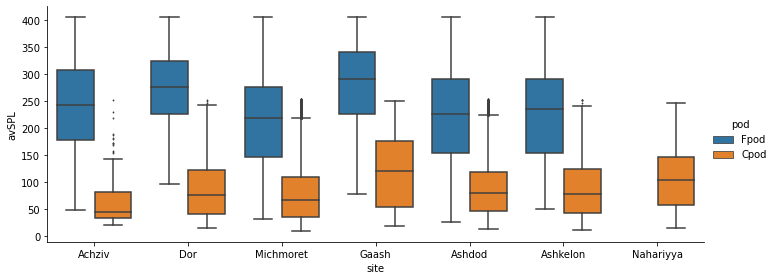

In [52]:
g = sns.catplot(x="site", y="avSPL",
                 hue='pod',fliersize=1,
                data=all_pod, kind="box",
                height=4, aspect=2.5);#hue=""
plt.savefig(f'For_Yotam/batch_200322/avSPL_all.png')

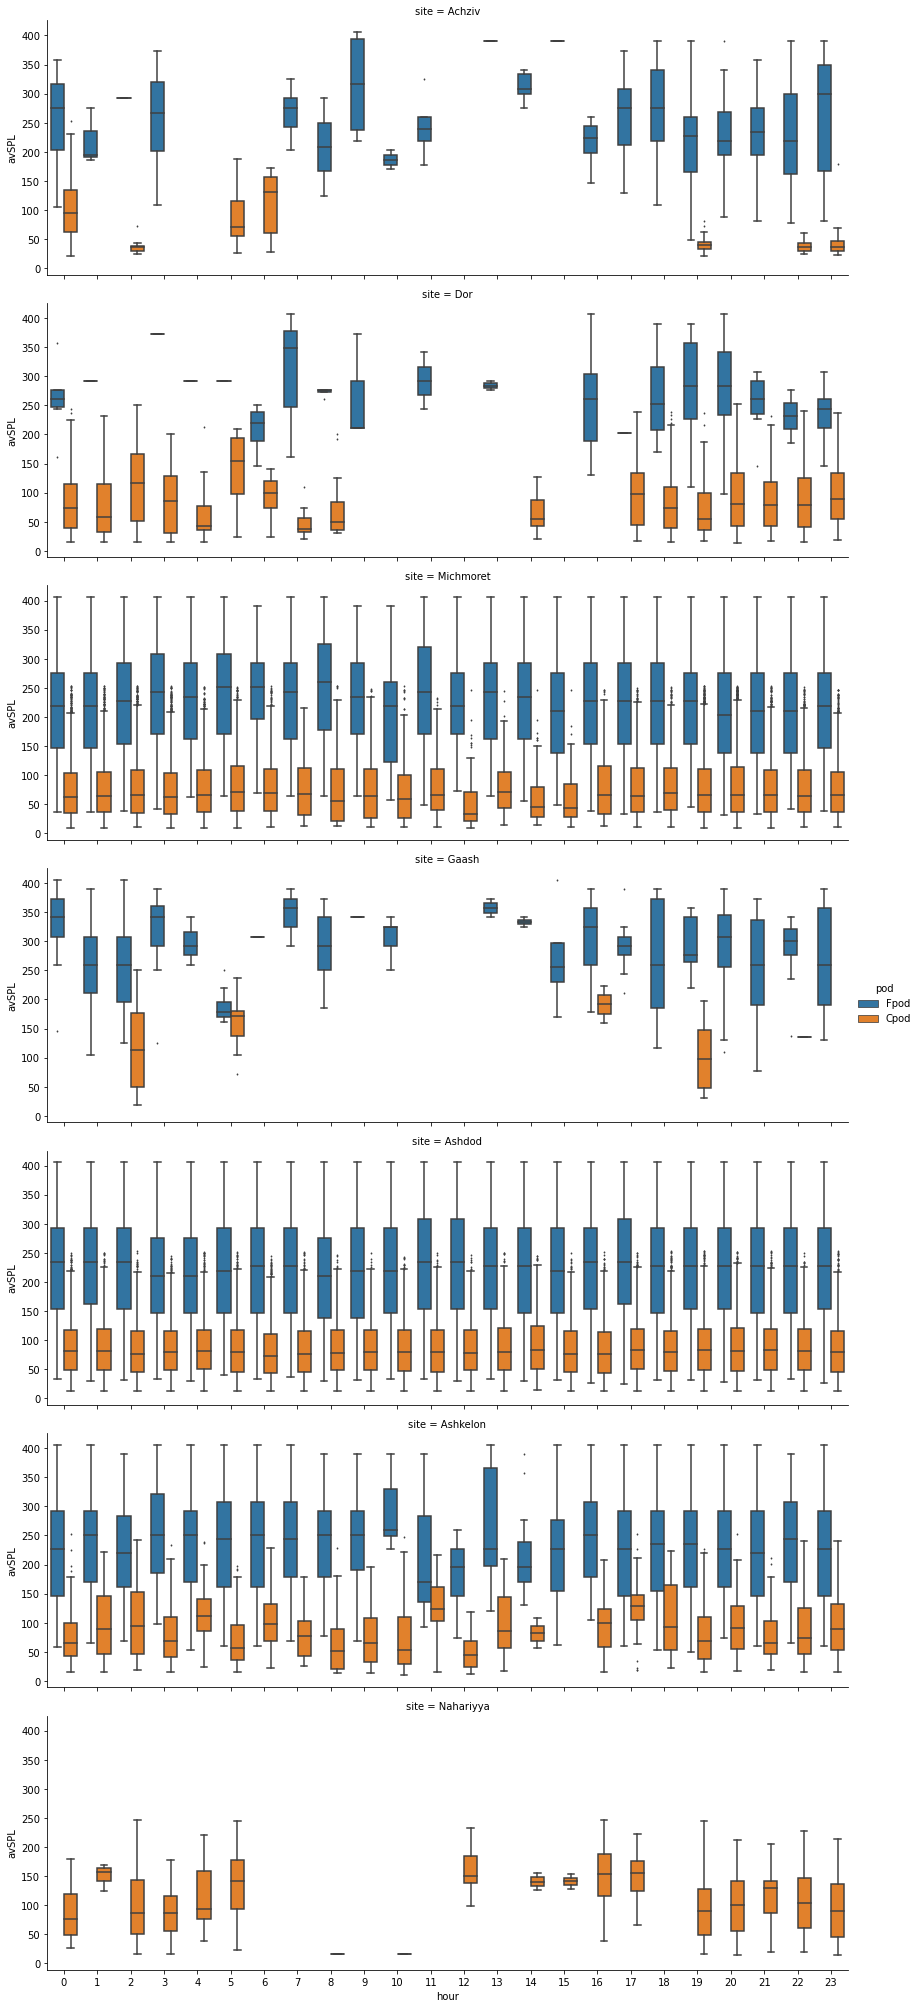

In [54]:
g = sns.catplot(x="hour", y="avSPL",
                 row="site", hue='pod',fliersize=1,
                data=all_pod, kind="box",
                height=4, aspect=3);
plt.savefig(f'For_Yotam/batch_200322/avSPL_sites_hour.png')

#### medianKHz

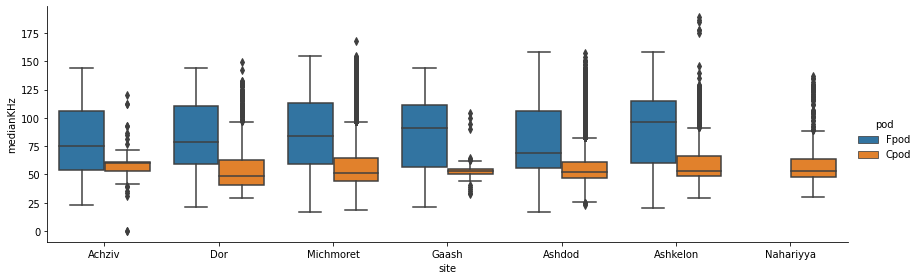

In [ ]:
g = sns.catplot(x="site", y="medianKHz",
                 hue='pod',fliersize=1,
                data=all_pod, kind="box",
                height=4, aspect=3);#hue=""
plt.savefig(f'For_Yotam/batch_200322/medianKHz_all.png')

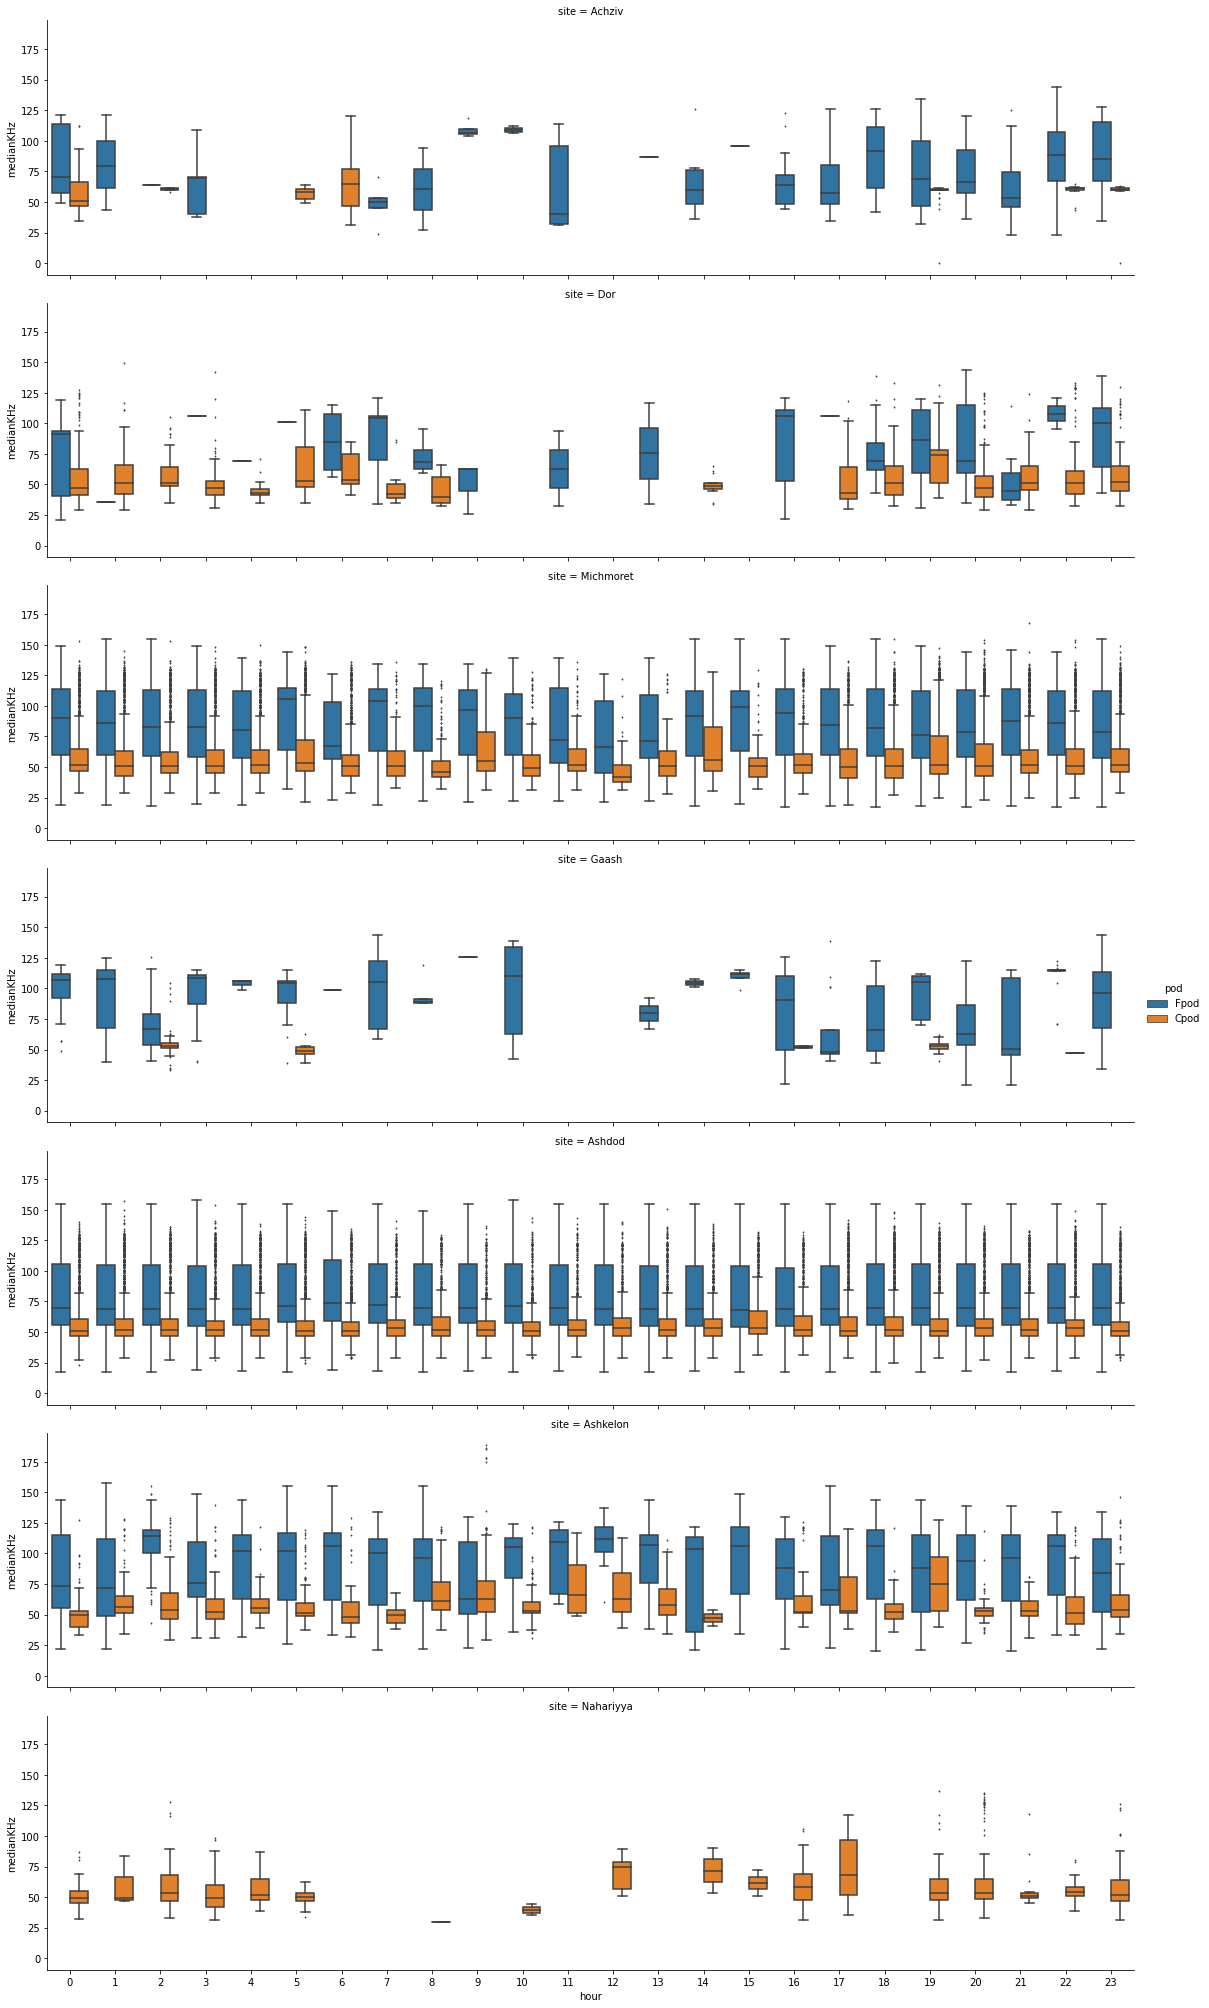

In [55]:
g = sns.catplot(x="hour", y="medianKHz",
                 row="site", hue='pod',fliersize=1,
                data=all_pod, kind="box",
                height=4, aspect=4);
plt.savefig(f'For_Yotam/batch_200322/medianKHz_sites_hour.png')

#### MedianPRF

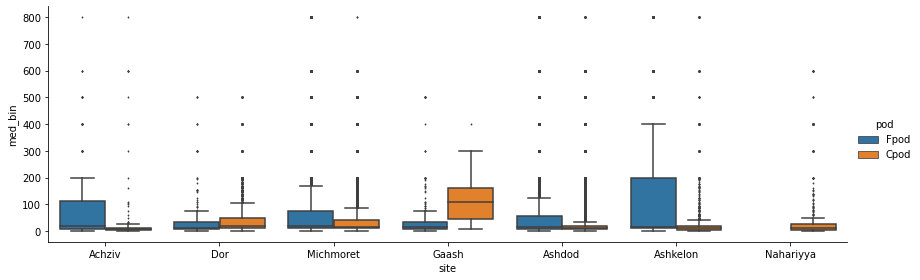

In [59]:
g = sns.catplot(x="site", y="med_bin",
                 hue='pod',fliersize=1,
                data=all_pod, kind="box",
                height=4, aspect=3);
plt.savefig(f'For_Yotam/batch_200322/med_bin_all.png')

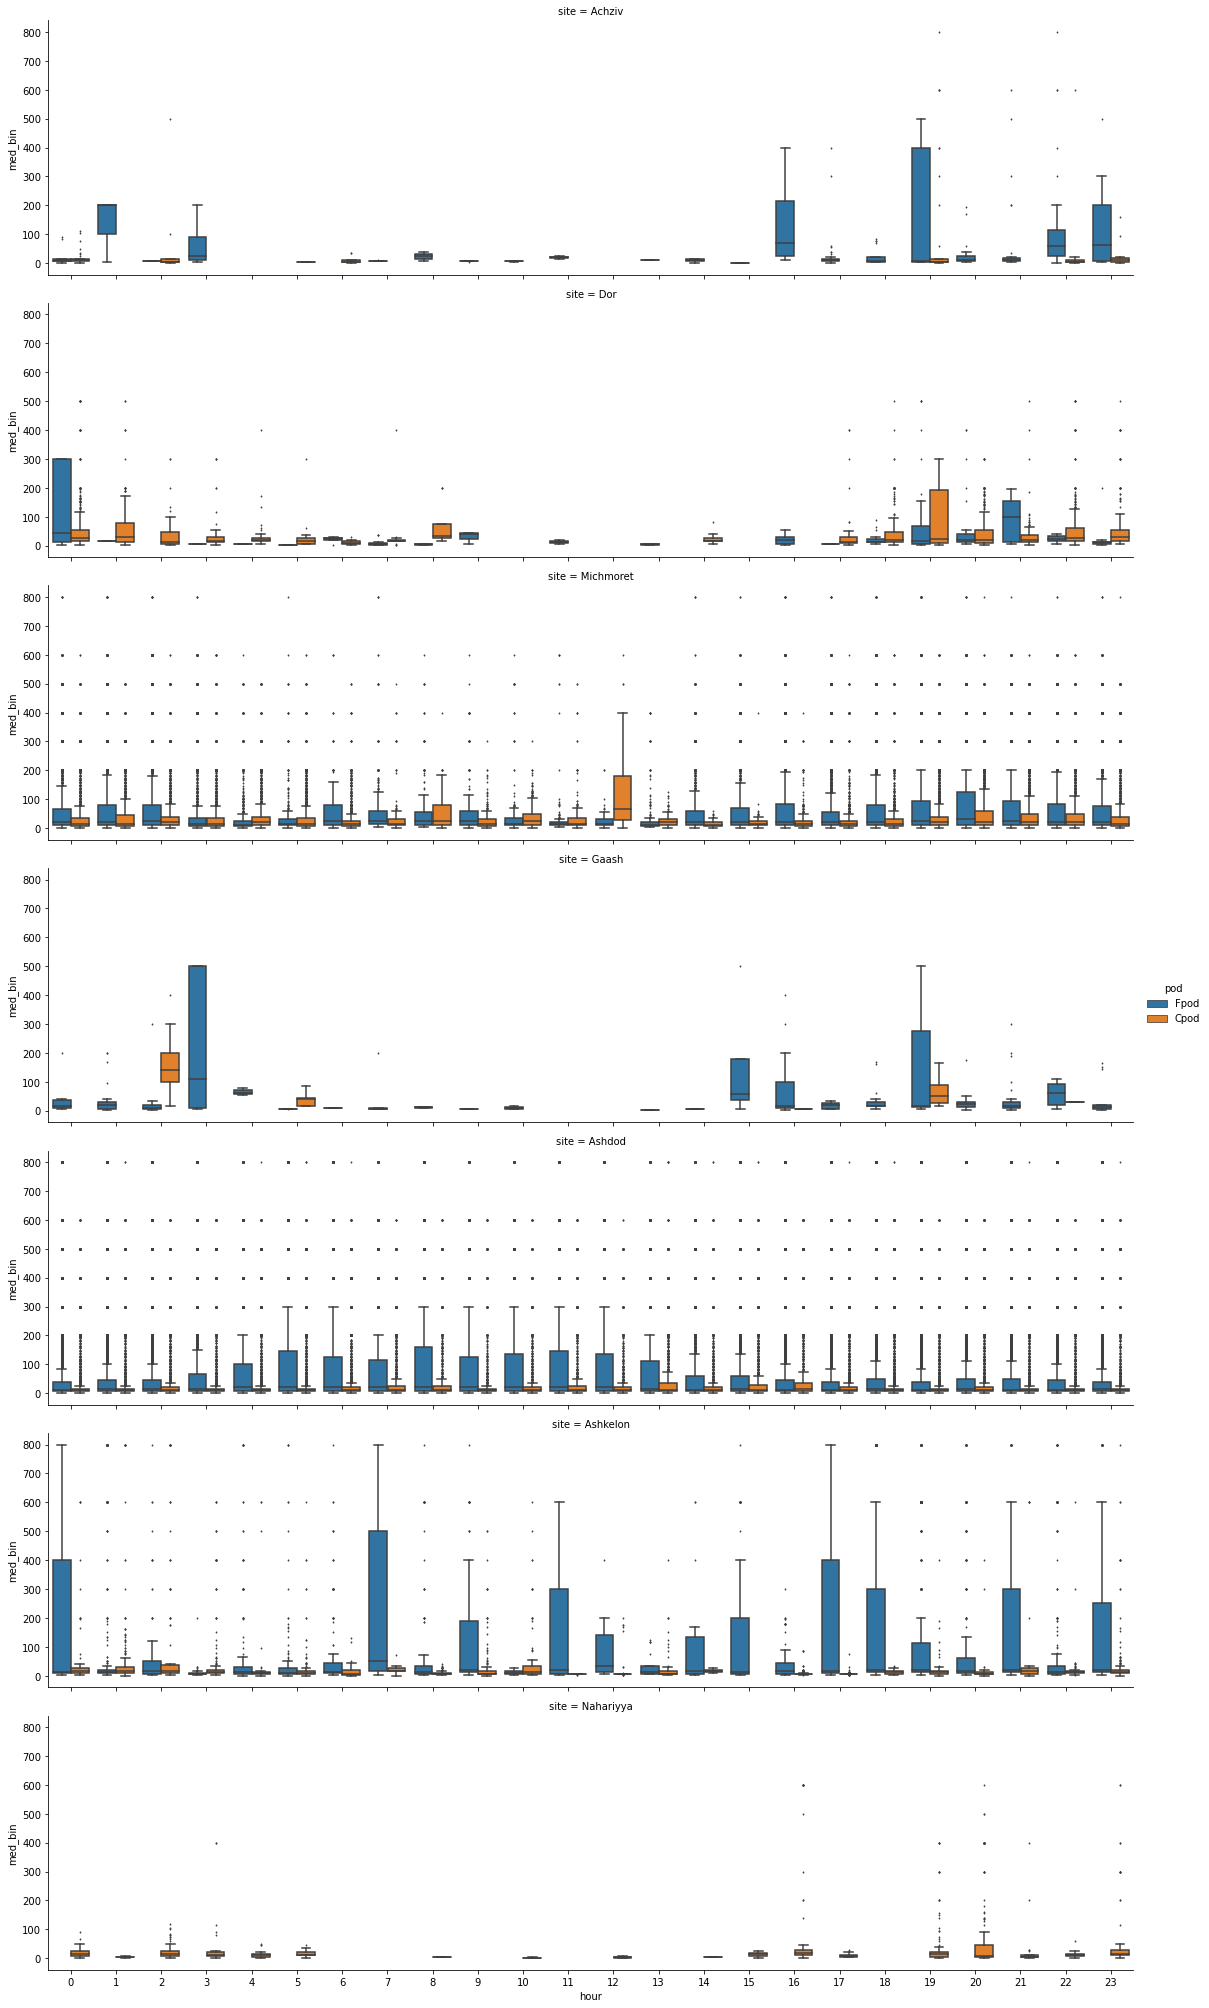

In [62]:
g = sns.catplot(x="hour", y="med_bin",fliersize=1,
                 row="site", hue='pod',
                data=all_pod, kind="box",
                height=4, aspect=4);
plt.savefig(f'For_Yotam/batch_200322/med_bin_sites_hour.png')

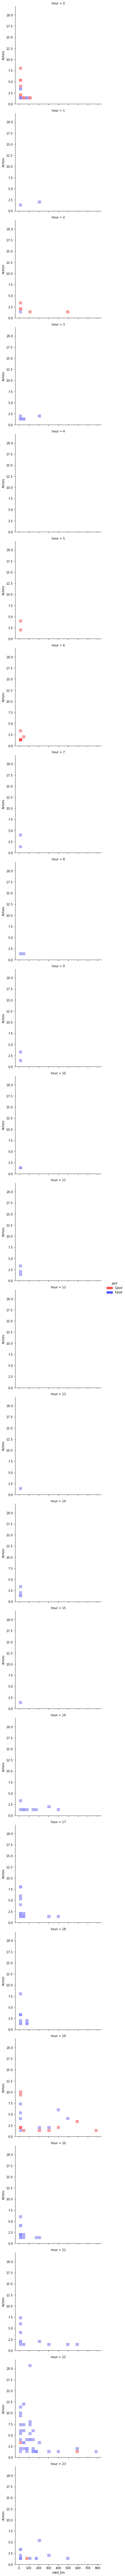

In [70]:
sns.displot(med_bins, x= 'med_bin',y='Achziv',hue = 'pod',row='hour',palette='seismic_r',kind ='hist')


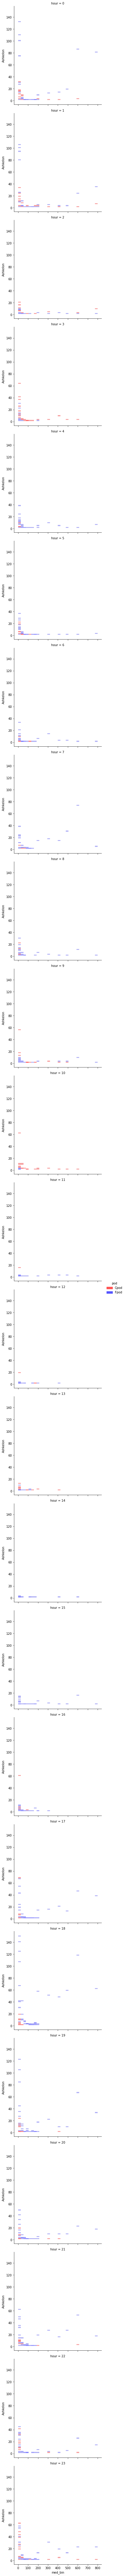

In [65]:
sns.displot(med_bins, x= 'med_bin',y='Ashkelon',hue = 'pod',row='hour',palette='seismic_r')


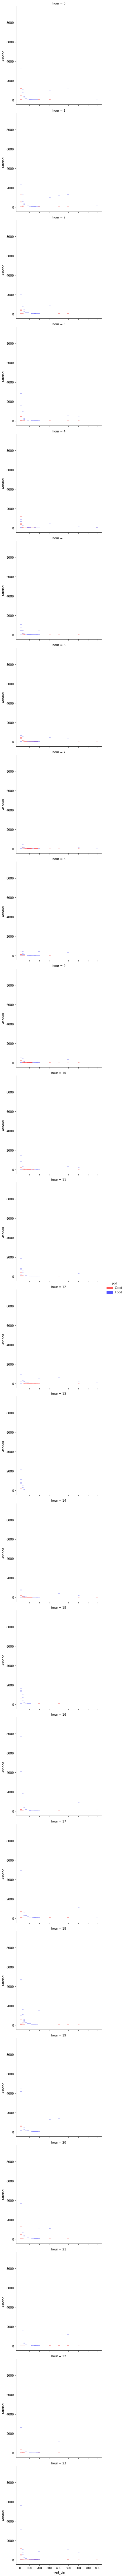

In [66]:
sns.displot(med_bins, x= 'med_bin',y='Ashdod',hue = 'pod',row='hour',palette='seismic_r')


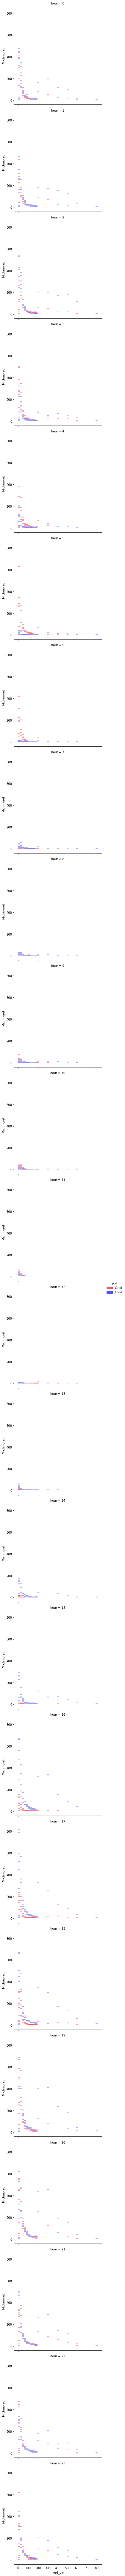

In [67]:
sns.displot(med_bins, x= 'med_bin',y='Michmoret',hue = 'pod',row='hour',palette='seismic_r')


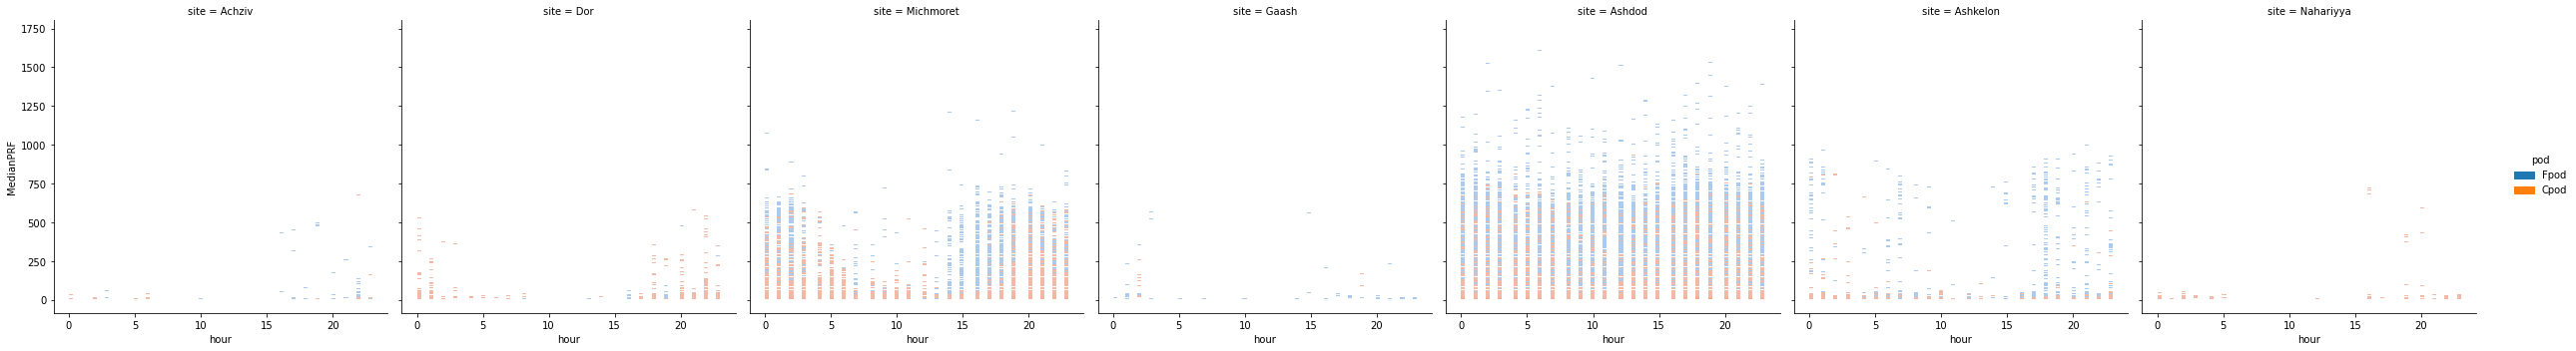

In [ ]:
sns.displot(data=all_pod, x="hour", y="MedianPRF", hue="pod", col="site")

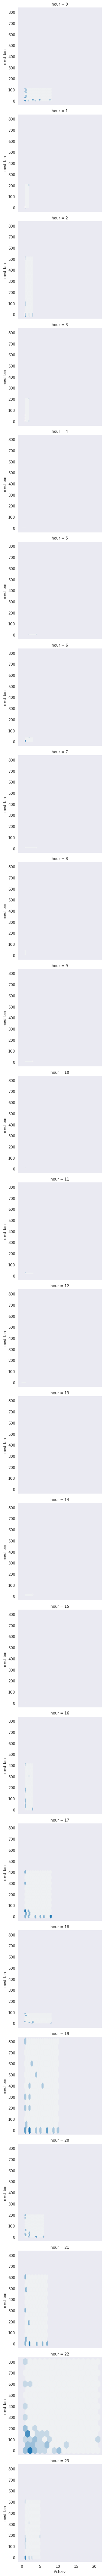

In [75]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(med_bins, row="hour" ,height=4)
g.map(hexbin, "Achziv", "med_bin");#,col='site'

<AxesSubplot:xlabel='hour', ylabel='MedianPRF'>

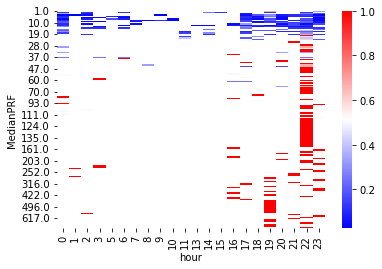

In [ ]:
# plt.rcParams['figure.figsize'] = [20, 10]
sns.heatmap(temp,cmap='bwr' )

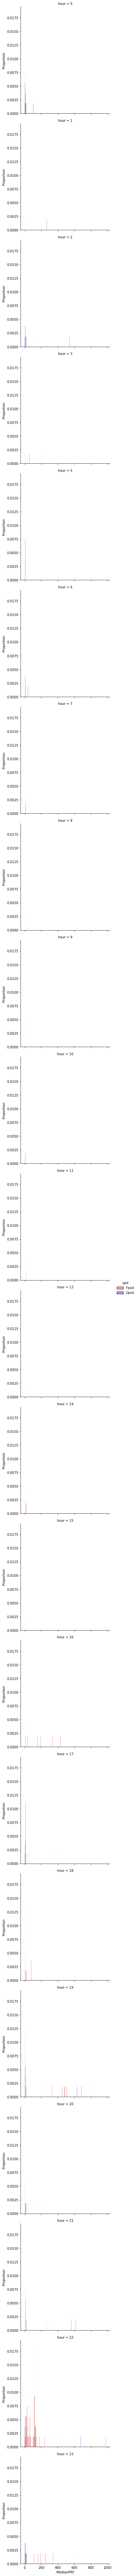

In [ ]:
sns.displot(Achzivall, x= 'MedianPRF',discrete=True,stat="proportion", hue = 'pod',row='hour', element="bars",palette='seismic_r')#, norm_hist='False'


#### FPOD Only

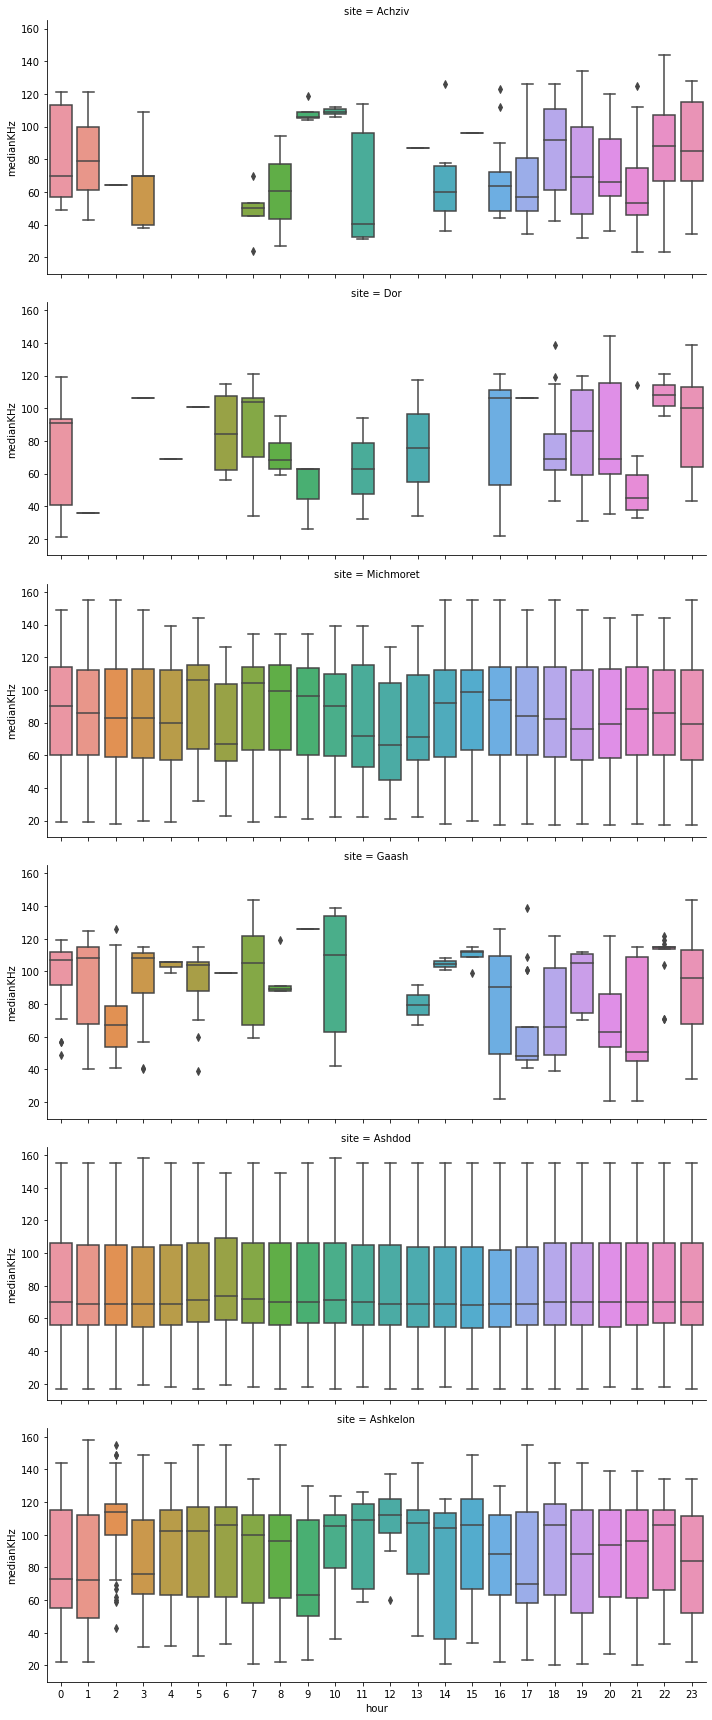

In [ ]:
g = sns.catplot(x="hour", y="MedianPRF",
                 row="site",
                data=f_pod, kind="box",
                height=4, aspect=2.5);#hue="smoker"

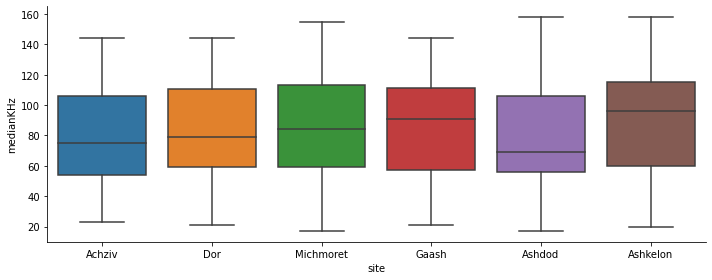

In [ ]:
g = sns.catplot(x="site", y="medianKHz",
                 
                data=f_pod, kind="box",
                height=4, aspect=2.5);#hue="smoker"

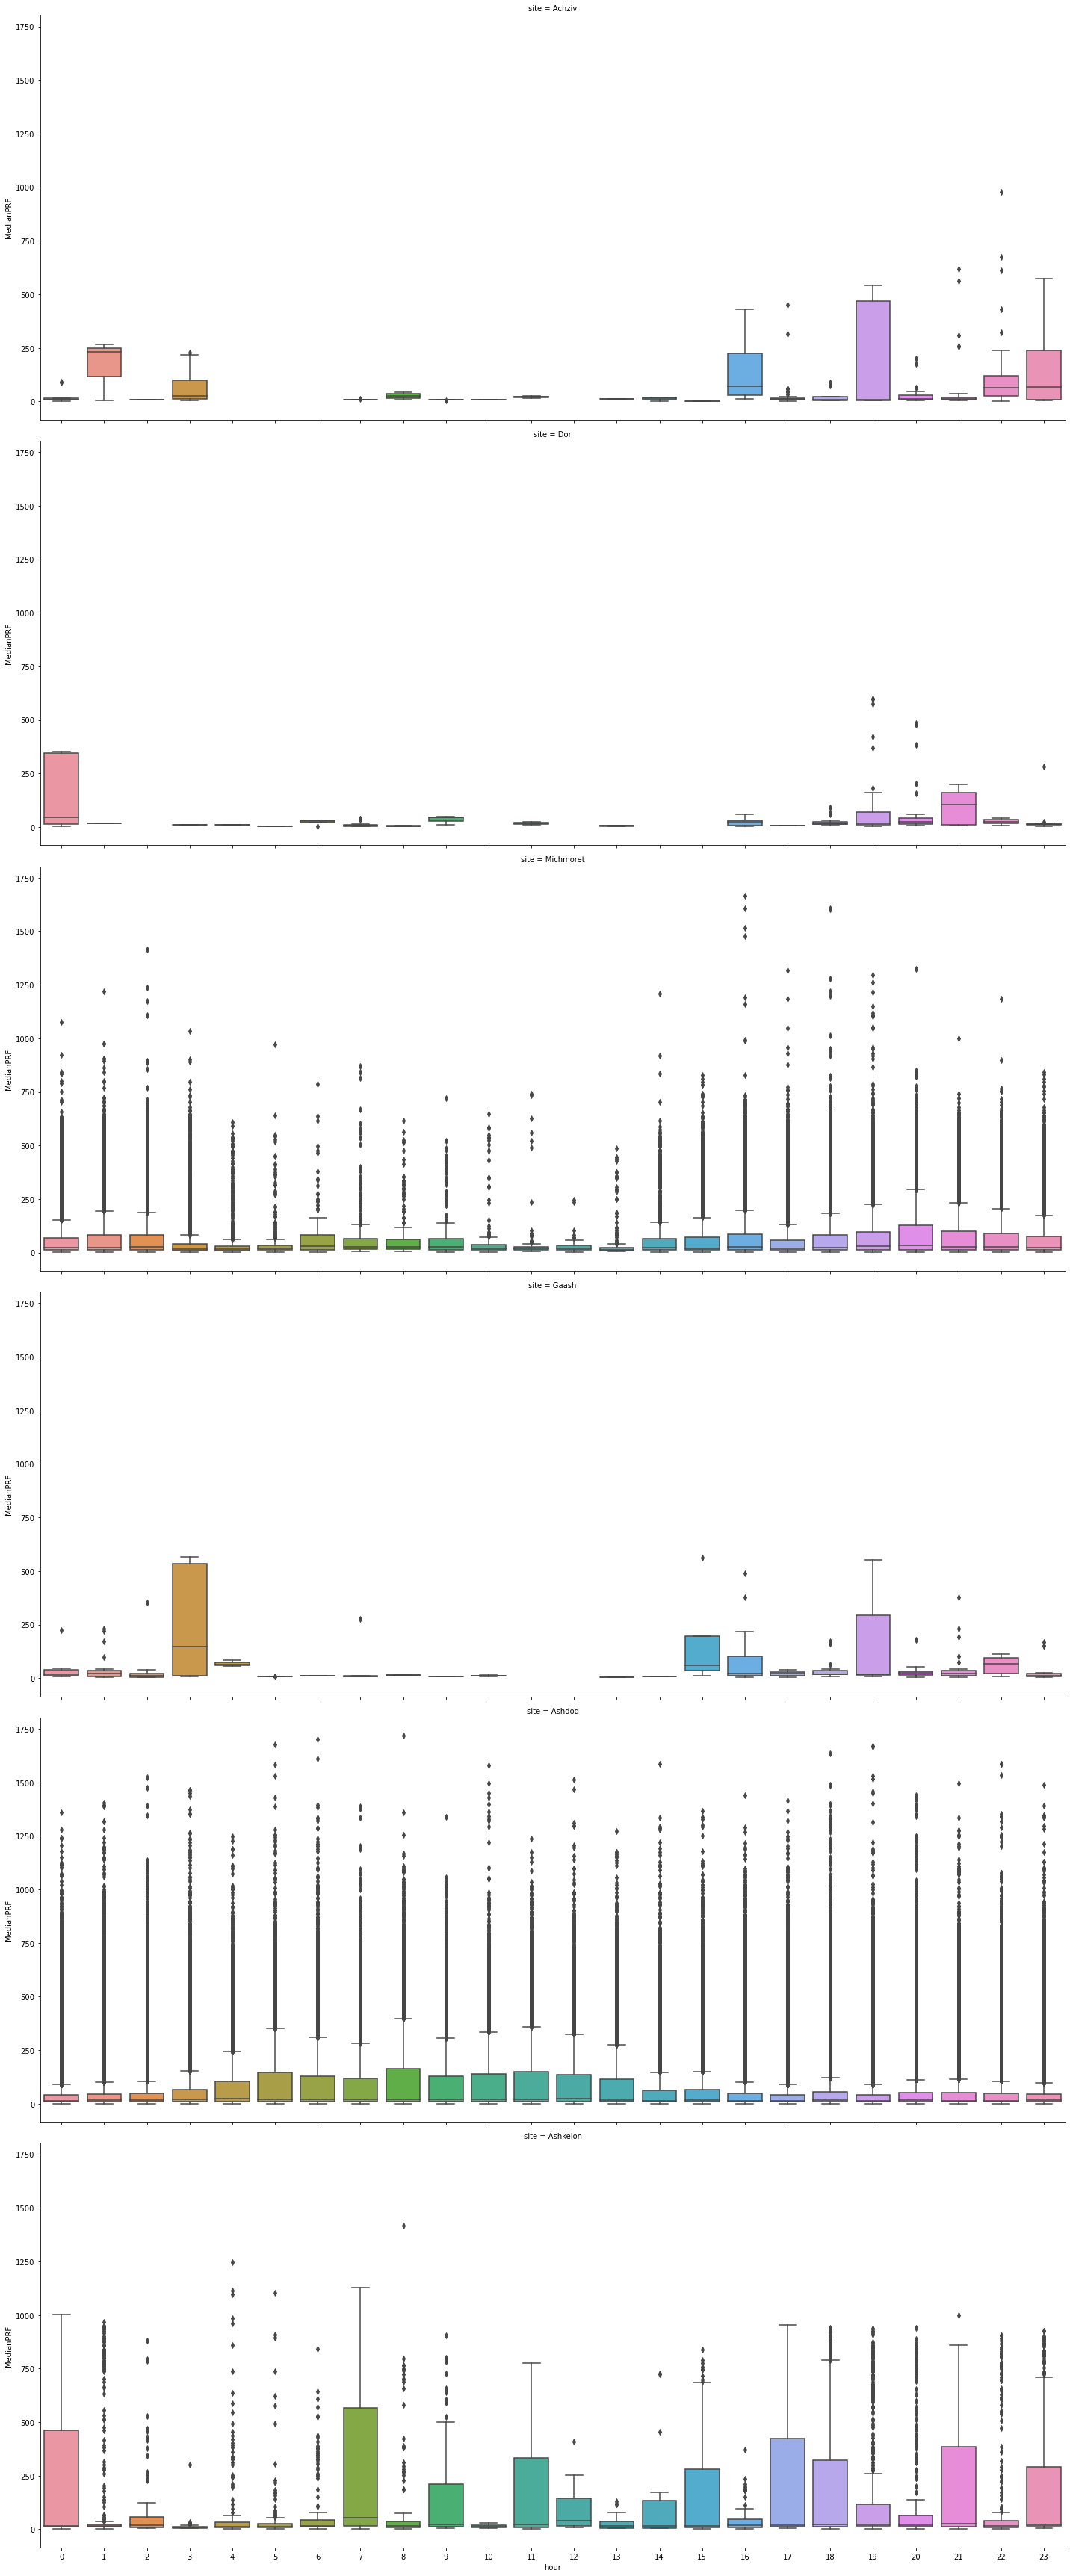

In [ ]:
g = sns.catplot(x="hour", y="MedianPRF",
                 row="site",facet_kws=dict(sharey=True),
                data=f_pod, kind="box",
                height=8, aspect=2.5);#hue="smoker"

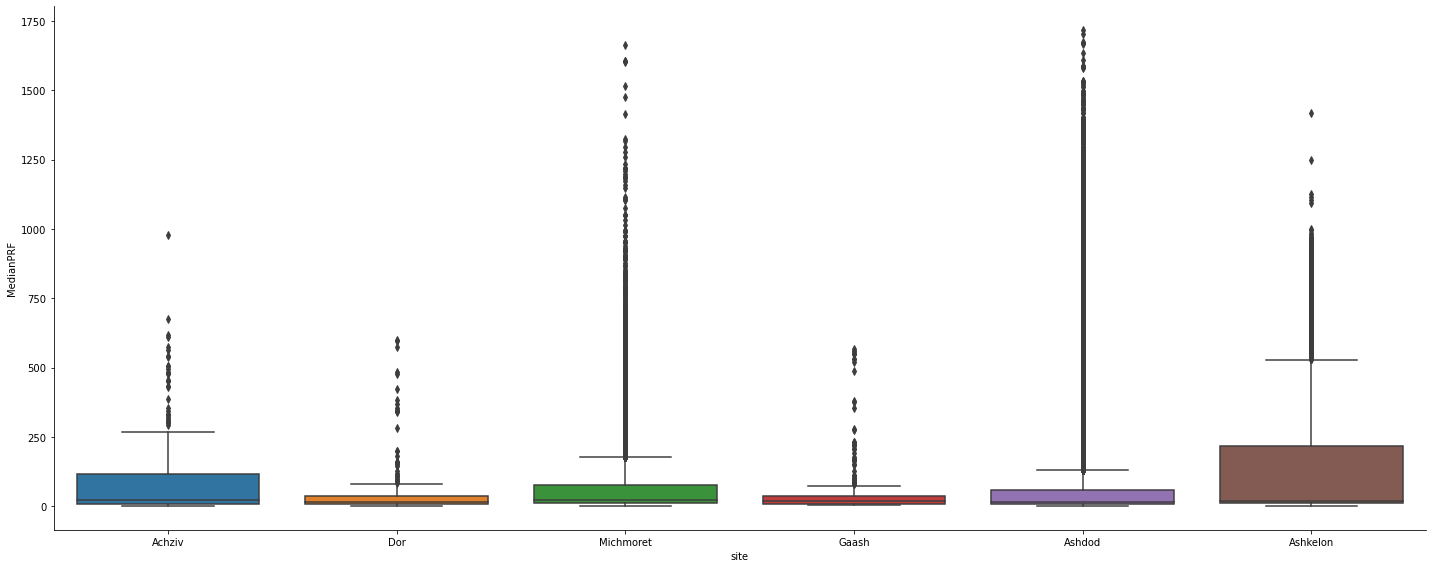

In [ ]:
g = sns.catplot(x="site", y="MedianPRF",
                 
                data=f_pod, kind="box",
                height=8, aspect=2.5);#hue="smoker"

In [81]:
# import matplotlib.dates as mdates
#     fig.autofmt_xdate()
#     ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
print(plt.rcParams['axes.autolimit_mode'])

temp = f_pod.site.unique()
fig, ax = plt.subplots(sharex=True )

for s in temp:
    tf_pod[tf_pod.site.isin([s])].MedianPRF.resample('D').median().plot.bar( ylabel = 'Number of Clicks/sec (MedianPRF)' ,  xlabel = 'Time', fontsize= 15, title = f'Daily Number of Clicks {s}' ,figsize = (20,5) )
    ax.legend()
    plt.xticks(tf_pod.month, rotation ='vertical')
    plt.savefig(f'For_Yotam/Daily_median_medianprf{s}.png')
    plt.show()

data



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f5c18f199d0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
temp = f_pod.groupby(['site','hour']).MedianPRF.median().unstack()
temp.to_csv('For_Yotam/Hourly_medianPRF.csv', encoding='utf-8')

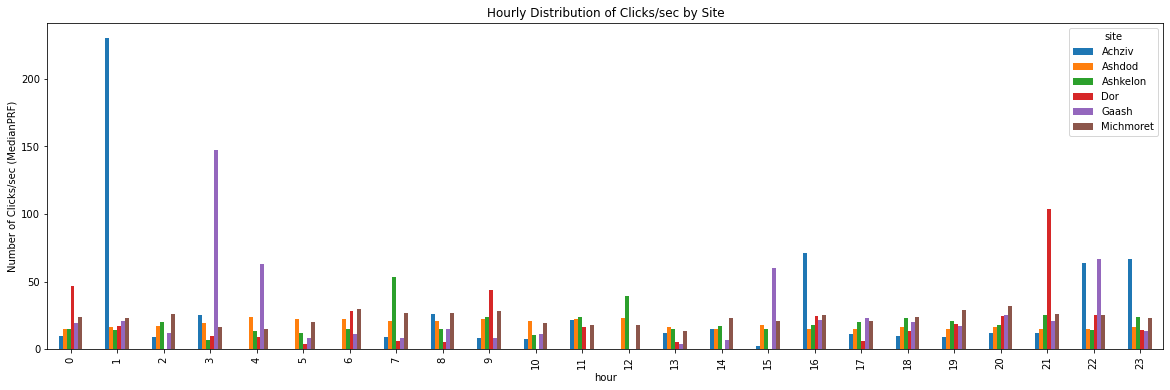

In [ ]:
f_pod.groupby(['hour','site']).MedianPRF.median().unstack().plot.bar(figsize = (20,6),ylabel = 'Number of Clicks/sec (MedianPRF)',
                                                                    title = f'Hourly Distribution of Clicks/sec by Site' )
plt.savefig('For_Yotam/Hourly_MedianPRF_site.png',)


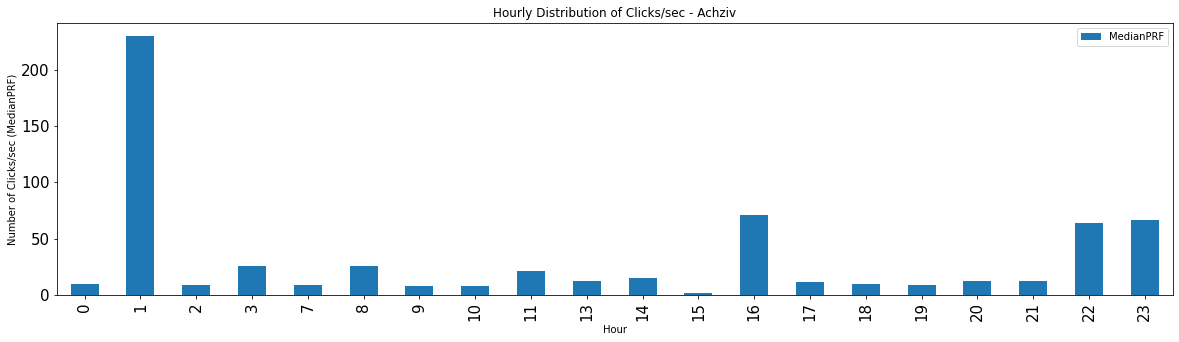

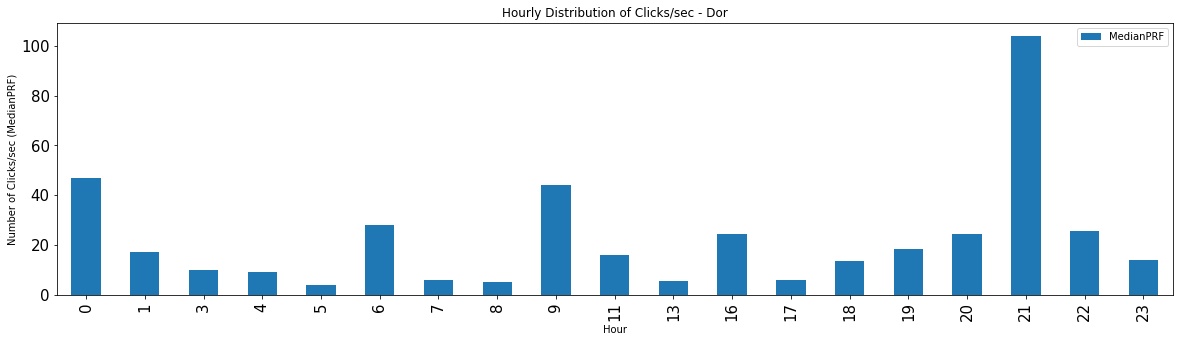

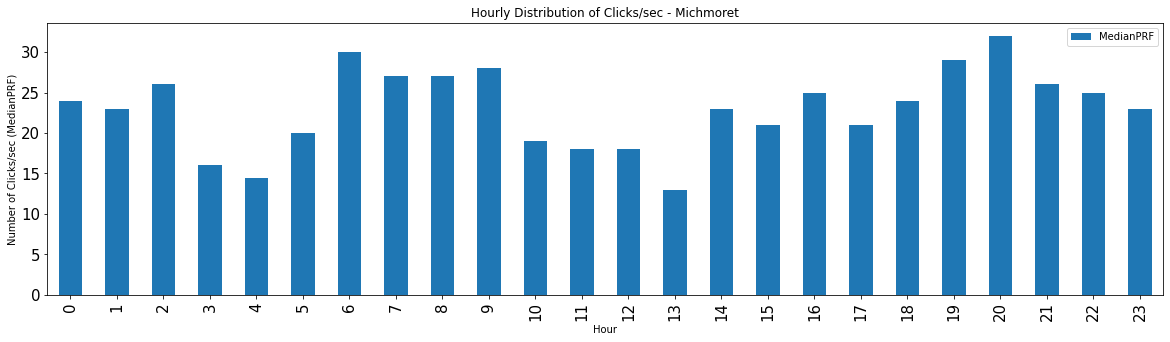

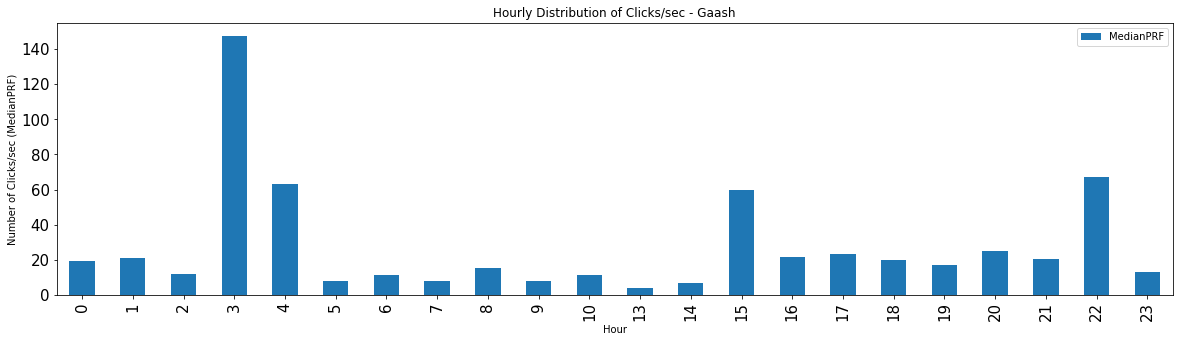

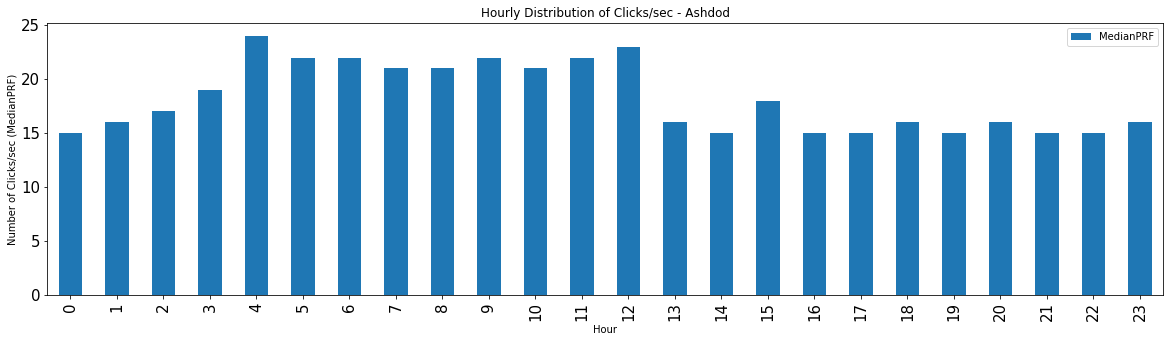

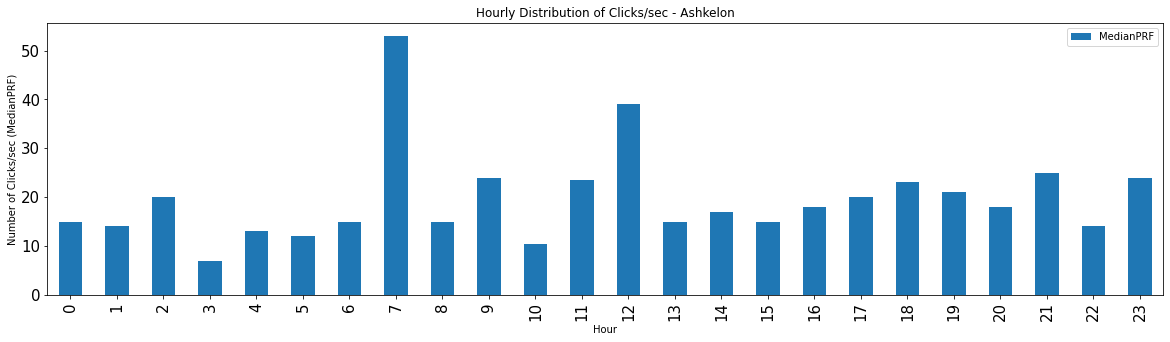

In [ ]:
temp = f_pod.site.unique()
for s in temp:
    site =  tf_pod[tf_pod.site.isin([s])]
    # DPM = site.resample('60Min').median()
    DPM = site.groupby('hour').MedianPRF.median().plot.bar( ylabel = 'Number of Clicks/sec (MedianPRF)' ,  xlabel = 'Hour', fontsize= 15, title = f'Hourly Distribution of Clicks/sec - {s}'  ,figsize = (20,5) )#.fillna(0)

    # DPM['Time_1'] = DPM.index
    # DPM['hour']=DPM.Time_1.apply(lambda x: x.strftime('%H'))
    # DPM['hour']=pd.to_numeric(DPM['hour'])
    # # DPM["Time_1"].dt.hour.MedianPRF.median().plot.bar( ylabel = 'Number of clicks(medianPRF)/second' ,  xlabel = 'Hour', fontsize= 15, title = f'Hourly distribution of median number of clicks {s}'  ,figsize = (20,5) )
    # DPM.groupby([DPM["Time_1"].dt.hour]).MedianPRF.median().plot( ylabel = 'DPM' ,  xlabel = 'Hour', fontsize= 15, title = f'Freq of events by hour - {s}'  ,figsize = (20,5) )
    plt.legend()
    plt.savefig(f'For_Yotam/bHourly_MedianPRF_per_s{s}.png')
    plt.show()

# F-POD - For Clustering

In [ ]:
#Split to F-Pod only
f_pod = all_train.drop(all_train.loc[:, "File":"Unnamed: 34"].columns, axis = 1)
f_pod.sample(3)

### Explore

In [ ]:
f_pod.Time.1.max()

In [ ]:
f_pod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614765 entries, 0 to 614764
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Line            608266 non-null  float64       
 1   File.1          608266 non-null  object        
 2   TrnID.1         608266 non-null  float64       
 3   Time.1          608266 non-null  datetime64[ns]
 4   Min.1           608266 non-null  float64       
 5   ON              608266 non-null  object        
 6   OpThreshold     608266 non-null  float64       
 7   ClksThisMin.1   608266 non-null  float64       
 8   SpClass.1       608266 non-null  object        
 9   Qn              608266 non-null  object        
 10  ICIgood.1       608266 non-null  object        
 11  tWUTrisk        608266 non-null  float64       
 12  Marked          608266 non-null  object        
 13  Start.1         608266 non-null  float64       
 14  NofClx.1        608266 non-null  flo

In [ ]:
f_pod.nunique()

Line              207444
TrnID_1              203
Time_1            112266
Min_1             112266
ON                     1
OpThreshold            8
ClksThisMin_1      11168
SpClass_1              1
Qn                     2
ICIgood_1              2
tWUTrisk               1
Marked                 1
Start_1           592796
NofClx_1             293
nActualClx_1         293
medianKHz            131
avEndF_1             143
nRisingIPIs          107
avSPL_1               63
avPkAt                 5
avBWx8                 9
TrDur_us_1         26306
MedianPRF           1317
nICIrising           155
MinICI_us_1        38592
midpointICI        47649
MaxICI_us_1        56982
ClkNofMinICI         257
ClkNofMaxICI         231
NofClstrs_1          151
avClstrNx8           762
avclF0               176
avclF1               169
avPkIPI              224
BeforeIPIratio       672
PreIPIratio          495
Post1IPIratio        463
Post2IPIratio        483
EndIPIratio          354
EncSpN                 0


### Feature engineering and functions


### For running the models start Here!
Run before:
   1. packages
   2. pd concat
   3. All data

In [ ]:
def time_stamp_decoration(func):
    def add_time_stamp(*args, **kwargs):
        t_start = time()
        print(f'Executing {func.__name__}...', end=' ')
        ret = func(*args, **kwargs)
        print("completed! ({:.3f} seconds)".format(time() - t_start))
        return ret
    return add_time_stamp
@time_stamp_decoration
def preprocess_data(data):
    # Dropping irrelevant culomns
    to_drop = ['SpClass.1', 'Marked', 'tWUTrisk', 'Qn', 'ICIgood.1', 'Line', 'EncSpN',
               'Start.1', 'TrnID.1', 'OpThreshold', 'avPkAt', 'nActualClx.1', 'avBWx8']  # ,'Min.1''ON',
    data.drop(to_drop, axis=1, inplace=True)

    # Dropping Nan
    data.dropna(inplace=True)

    # Removing the . from column names
    data.columns = data.columns.str.replace('.', '_')

    # Extracting name from Fiile column, assigining them to new column site, dropping File.1
    file_val = data['File_1'].value_counts().keys()
    site_name_map = ['Ashdod', 'Ashdod', 'Ashdod', 'Ashdod', 'Ashdod', 'Ashdod', 'Michmoret',
                     'Michmoret', 'Michmoret', 'Michmoret', 'Michmoret', 'Ashdod', 'Ashkelon',
                     'Ashkelon', 'Ashkelon', 'Achziv', 'Achziv', 'Gaash', 'Achziv', 'Gaash', 'Ashdod',
                     'Dor', 'Dor', 'Gaash', 'Ashkelon', 'Ashdod', 'Dor', 'Dor', 'Dor', 'Ashdod', 'Ashdod']


    data['site'] = data['File_1'].replace(file_val, site_name_map)
    data.drop('File_1', axis=1, inplace=True)


    # Datetime to columns
    data['month'] = data.Time_1.apply(lambda x: x.strftime('%m'))
    data['year'] = data.Time_1.apply(lambda x: x.strftime('%Y'))
    data['hour'] = data.Time_1.apply(lambda x: x.strftime('%H'))
    # f_pod['day365']=f_pod.Time_1.apply(lambda x: x.strftime('%-j'))
    # f_pod['Minute']=f_pod.Time_1.apply(lambda x: x.strftime('%-M'))
    data['month'] = pd.to_numeric(data['month'])
    data['year'] = pd.to_numeric(data['year'])
    data['hour'] = pd.to_numeric(data['hour'])
    tf_pod = data.set_index('Time_1', drop = False)
    tf_pod.index = pd.to_datetime(tf_pod.index)
    tf_pod = tf_pod.sort_index()
    return data

#Converting to datetime index in tf_pod


tf_pod = f_pod.set_index('Time_1', drop = False)
tf_pod.index = pd.to_datetime(tf_pod.index)
tf_pod = tf_pod.sort_index()

@time_stamp_decoration
def outliers_removal(data):
    # site =data  
    ####################################### NofClx_1
    rf_pod = data[data.NofClx_1 <200] # above 200 is removed
    ####################################### medianKHz
    temp = rf_pod.medianKHz.value_counts(normalize  = True) # # outliers under freq 0.0005 were removed
    temp = temp[temp<0.0005]
    medianKHz_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['medianKHz'].isin(medianKHz_out)]
    #######################################avEndF_1
    temp = rf_pod.avEndF_1.value_counts(normalize  = True) # under freq 0.0005
    temp = temp[temp<0.001]
    avEndF_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['avEndF_1'].isin(avEndF_out)]
    ####################################### nRisingIPIs
    temp = rf_pod.nRisingIPIs.value_counts(normalize  = True)# under freq 0.0009
    temp = temp[temp<0.0009]
    RisingIPI_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['nRisingIPIs'].isin(RisingIPI_out)]
    ####################################### avSPL_1
    temp = rf_pod.avSPL_1.value_counts(normalize  = True) # under freq 0.0002
    temp = temp[temp<0.002]
    avSPL_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['avSPL_1'].isin(avSPL_out)]
    ####################################### TrDur_us_1
    # f_pod.drop('TrDur_us_1', axis = 1, inplace = True) # I am not sure what to do about it, more than
    rf_pod = rf_pod[rf_pod['TrDur_us_1']<4000000]
    ####################################### MedianPRF
    temp = rf_pod.MedianPRF.value_counts() # under 5 occurences
    temp = temp[temp<5]
    MedianPRF_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['MedianPRF'].isin(MedianPRF_out)]
    ####################################### MaxICI_us_1
    rf_pod = rf_pod[f_pod['MaxICI_us_1']<100000] # cutting edge at 100000
    ####################################### ClkNofMinICI
    temp = rf_pod.ClkNofMinICI.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    ClkNofMinICI_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['ClkNofMinICI'].isin(ClkNofMinICI_out)]
    ####################################### ClkNofMaxICI
    temp = rf_pod.ClkNofMaxICI.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    ClkNofMaxICI_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['ClkNofMaxICI'].isin(ClkNofMaxICI_out)]
    ####################################### NofClstrs_1
    temp = rf_pod.NofClstrs_1.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    NofClstrs_1_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['NofClstrs_1'].isin(NofClstrs_1_out)]
    ####################################### NofClstrs_1
    temp = rf_pod.avClstrNx8.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    avClstrNx8_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['avClstrNx8'].isin(avClstrNx8_out)]
    ####################################### avclF0
    temp = rf_pod.avclF0.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    avclF0_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['avclF0'].isin(avclF0_out)]
    ####################################### avclF1
    temp = rf_pod.avclF1.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    avclF1_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['avclF1'].isin(avclF1_out)]
    ####################################### avPkIPI
    temp = rf_pod.avPkIPI.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    avPkIPI_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['avPkIPI'].isin(avPkIPI_out)]
    ####################################### BeforeIPIratio
    temp = rf_pod.BeforeIPIratio.value_counts(normalize=True) # under freq 0.0001
    temp = temp[temp<0.0001]
    BeforeIPIratio_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['BeforeIPIratio'].isin(BeforeIPIratio_out)]
    ####################################### BeforeIPIratio
    temp = rf_pod.BeforeIPIratio.value_counts(normalize=True) # under freq 0.0001 
    temp = temp[temp<0.0001]
    BeforeIPIratio_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['BeforeIPIratio'].isin(BeforeIPIratio_out)]
    ####################################### PreIPIratio
    temp = rf_pod.PreIPIratio.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    PreIPIratio_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['PreIPIratio'].isin(PreIPIratio_out)]
    ####################################### Post1IPIratio
    temp = rf_pod.Post1IPIratio.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    Post1IPIratio_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['Post1IPIratio'].isin(Post1IPIratio_out)]
    ####################################### Post2IPIratio
    temp = rf_pod.Post2IPIratio.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    Post2IPIratio_out = temp.index.tolist()
    rf_pod = rf_pod[~rf_pod['Post2IPIratio'].isin(Post2IPIratio_out)]
    ####################################### EndIPIratio
    temp = rf_pod.EndIPIratio.value_counts(normalize  = True) # under freq 0.0001
    temp = temp[temp<0.0001]
    EndIPIratio_out = temp.index.tolist()
    aa = data
    data = rf_pod[~rf_pod['EndIPIratio'].isin(EndIPIratio_out)]
    bb= len(aa)-len(data)
    print (f'{len(aa)}-{len(data)}={bb}')
    return  data, (print (f'{len(aa)}-{len(data)}={bb}'))
    

    # site_order = tf_pod.site.unique()
    # site_map = dict(zip(site_order, range(len(site_order))))
    # tf_pod.loc[:, 'site'] = tf_pod['site'].map(site_map)




KeyError: "None of ['Time_1'] are in the columns"

In [ ]:
attribs_noz = ['medianKHz','MedianPRF','MaxICI_us_1','MinICI_us_1','midpointICI','NofClx_1', 'avSPL_1']
attribs_z =  ['avclF0', 'PreIPIratio','Post1IPIratio','Post2IPIratio']
zero_pipeline = Pipeline(steps = [('minmax_scaler0', MinMaxScaler(feature_range=(0, 1)))])
other_pipeline = Pipeline([('minmax_scaler', MinMaxScaler(feature_range=(0.001, 1)))])
myscaler = ColumnTransformer([
        ("zero_cols", zero_pipeline, attribs_z),("no_zero_cols", other_pipeline, attribs_noz)
]).fit_transform



In [ ]:
@time_stamp_decoration
def myclusterer(data):
    clusterer = hdbscan.HDBSCAN(algorithm='best',
                                 approx_min_span_tree=True,
                                gen_min_span_tree=False, leaf_size=80,metric='euclidean',
                                min_samples=1,min_cluster_size=20,cluster_selection_method = 'leaf',alpha=1.0,cluster_selection_epsilon=0.01
                                )

In [ ]:
#Preprocess---------------------------
f_pod = preprocess_data(f_pod)

# Splitting df to sites---------------------------
Achziv = f_pod[f_pod.site.isin(['Achziv'])]
Michmoret = f_pod[f_pod.site.isin(['Michmoret'])]
Ashdod = f_pod[f_pod.site.isin(['Ashdod'])]
Ashkelon = f_pod[f_pod.site.isin(['Ashkelon'])]
Gaash = f_pod[f_pod.site.isin(['Gaash'])]
Dor = f_pod[f_pod.site.isin(['Dor'])]

# #Removing Outliers---------------------------
sss,Achziv = outliers_removal(Achziv)
print(sss)
Achziv
# Ashdod = outliers_removal(Ashdod)
# Ashkelon = outliers_removal(Ashkelon)
# Dor = outliers_removal(Dor)
# Gaash = outliers_removal(Gaash)
# Michmoret = outliers_removal(Michmoret)


In [ ]:

# Minmax Scaling---------------------------
cachz= myscaler(Achziv)
cashd = myscaler(Ashdod)
cashk = myscaler(Ashkelon)
cgaash = myscaler(Gaash)
cdor = myscaler(Dor)
cmich = myscaler(Michmoret)

# HDBSCAN Clustering---------------------------
clusterer.fit(cashk)
Ashkelon['hdb'] = clusterer.labels_
clusterer.fit(cachz)
Achziv['hdb'] = clusterer.labels_
clusterer.fit(cmich)
Michmoret['hdb'] = clusterer.labels_
clusterer.fit(cdor)
Dor['hdb'] = clusterer.labels_
clusterer.fit(cgaash)
Gaash['hdb'] = clusterer.labels

In [ ]:
a=clusterer.probabilities_
a

In [ ]:
Ashkelon.hdb.value_counts().value_counts()

In [ ]:
Achziv.hdb.value_counts().value_counts()

In [ ]:
Michmoret.hdb.value_counts().value_counts()

In [ ]:
Dor.hdb.value_counts().value_counts()

In [ ]:
Gaash.hdb.value_counts().value_counts()

### HDBSCAN

In [ ]:
# rf_pod['hdbs'] = pd.Series(hdbs.values[:,1])

In [ ]:
# rf_pod.groupby(['site','hdbs']).size()

site       hdbs
Achziv     -1.0       355
            0.0        13
            1.0         7
Ashdod     -1.0    414994
            0.0     22474
            1.0      5465
Dor        -1.0       190
            1.0         2
Gaash      -1.0       240
            0.0         2
Michmoret  -1.0     65407
            0.0       519
            1.0       111
dtype: int64

In [ ]:
clusterer = hdbscan.HDBSCAN(algorithm='best',
                             approx_min_span_tree=True,
                            gen_min_span_tree=False, leaf_size=80,metric='euclidean',
                            min_samples=1,min_cluster_size=20,cluster_selection_method = 'leaf',alpha=1.0,cluster_selection_epsilon=0.01
                            ).fit(Clus)#, min_samples  = 2, p=None,min_cluster_size=30,,cluster_selection_epsilon=0.2


In [ ]:
all_median['hdb'] = clusterer.labels_

In [ ]:
all_median.hdb.value_counts().value_counts()

20       10
21        7
23        6
26        6
22        5
24        5
25        5
31        4
37        4
36        4
44        4
29        3
32        2
48        2
28        2
38        2
39        2
40        2
43        2
61        2
50        1
76        1
134       1
125       1
116       1
98        1
89        1
87        1
81        1
80        1
30        1
79        1
33        1
53        1
34        1
35        1
70        1
64        1
63        1
60        1
41        1
151       1
59        1
54375     1
Name: hdb, dtype: int64

In [ ]:
all_median.to_csv('all_median_clus.csv', encoding='utf-8')


In [ ]:
# clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.2,
#                                       node_size=1,
#                                       edge_linewidth=2)

In [ ]:
Michmoret.groupby(['site','hdb']).size()

site       hdb
Michmoret  -1      4043
            0        26
            1     61968
dtype: int64

In [ ]:
# header = ["hdb"]
# Ama_median.to_csv('fAma_median_hdb200.csv')

<AxesSubplot:ylabel='$\\lambda$ value'>

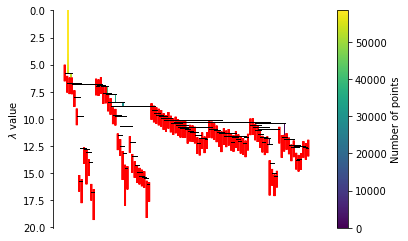

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 15))

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

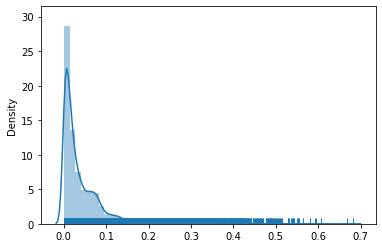

In [ ]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

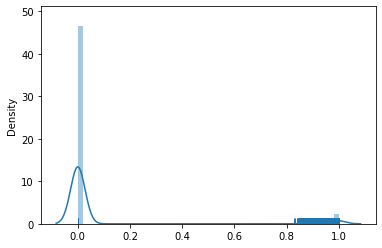

In [ ]:

sns.distplot(clusterer.probabilities_ [np.isfinite(clusterer.probabilities_)], rug=True)


In [ ]:
temp = all_median_clus.hdb.value_counts() # under freq 0.0001
temp = temp[temp.index<=50]
temp = temp.index.tolist()
hdb_out = temp
# dbclus_out = temp.index.tolist()
all_median_clus = all_median_clus[all_median_clus['hdb'].isin([85,87,51,24,89,28,101,35,94,10,58,34,80,67,61])]
# Ashdod_out = samp_pod[samp_pod['hdb'].isin([-1])]
all_median_clus

ClksThisMin_1  NofClx_1  medianKHz  avEndF_1  nRisingIPIs  avSPL_1  \
307           3059.0      10.0       60.0      66.5          0.0     95.0   
519           2672.0      24.0      106.0      95.0          3.0    357.0   
529           1010.0      26.0       61.0      64.0          5.0    243.0   
547           2495.0       9.0       32.0      32.0          0.0    138.0   
627           3822.5      20.0       43.5      47.0          3.0    203.0   
...              ...       ...        ...       ...          ...      ...   
58306          663.0      11.0       42.0      43.0          1.0    170.0   
58320         4935.0      10.0       41.0      42.0          3.0    235.0   
58323         3580.0      14.0       40.5      36.5          3.5    239.0   
58362         1876.0      12.0       68.5      73.0          1.0    243.0   
58398         5329.5       8.5       41.0      54.0          0.0    166.0   

       TrDur_us_1  MedianPRF  nICIrising  MinICI_us_1  midpointICI  \
307       19212.0      513.5         4.5        373.0        399.0   
519     1571428.0       15.0         9.0       9393.0      12846.0   
529     2000000.0       13.0        11.0      12154.0      16127.0   
547      409090.0       24.0         3.0       8410.0       8554.0   
627      271493.5       78.5         8.0       2308.0       2687.5   
...           ...        ...         ...          ...          ...   
58306    307692.0       39.0         8.0       4675.0       4891.0   
58320    222222.0       45.0         3.0       4346.0       4403.0   
58323    387121.0       37.0         9.5       5031.0       5526.0   
58362    583333.0       21.0         5.0       8702.0       9830.0   
58398    291574.0       31.5         5.0       6905.0       6957.5   

       MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  NofClstrs_1  avClstrNx8  \
307          426.0           5.0           6.5          0.0         0.0   
519        16953.0          14.0           6.0          8.0        75.0   
529        21960.0          12.0          17.0         12.0        23.0   
547         9440.0           8.0           4.0          6.0         8.0   
627         3038.0          11.0          14.0          5.5        16.5   
...            ...           ...           ...          ...         ...   
58306       6758.0           2.0          11.0          6.0        16.0   
58320       4600.0           2.0           4.0          4.0        23.0   
58323       6374.5           2.0          12.5          6.5        16.0   
58362      11157.5           7.5           6.0          6.0        17.0   
58398       7261.5           2.5           7.0          6.0         8.0   

       avclF0  avclF1  avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  \
307       0.0     0.0     73.5           0.765        0.815          0.990   
519      86.0    97.0     43.0           2.110        1.220          1.050   
529      69.0    42.0     73.0           1.310        1.040          1.030   
547       0.0     0.0    131.0           0.410        0.960          0.970   
627      41.5    26.0    111.0           0.920        0.965          1.050   
...       ...     ...      ...             ...          ...            ...   
58306    50.0    48.0     90.0           0.960        1.040          0.960   
58320    33.0    24.0     98.0           1.010        0.890          0.950   
58323    38.0    38.5    112.0           0.380        0.870          0.860   
58362    56.5    43.0     62.0           1.145        1.070          1.005   
58398     0.0     0.0     88.5           0.630        0.770          1.095   

       Post2IPIratio  EndIPIratio  month    year  hour  day365  Minute  \
307            0.000        1.095    9.5  2020.0  16.0   271.5    24.0   
519            1.040        0.980    7.0  2020.0  15.0   183.0    43.0   
529            1.180        1.010   12.0  2019.0  16.0   352.0    32.0   
547            0.000        1.000    9.0  2019.0  21.0   263.0    41.0   
627            0.860        1.055

In [ ]:
# mich_out = Michmoret_out.groupby('hdb').median().reset_index(drop=True)
# mich_hdbout = Michmoret_hdbout.groupby('hdb').median().reset_index(drop=True)
# Mich_median =pd.concat([mich_out,mich_hdbout])
# Mich_median.to_csv('Mich_median140322.csv', encoding='utf-8')
# ashk_out = Ashkelon_out.groupby('hdb').median().reset_index(drop=True)
# ashk_hdbout = Ashkelon_hdbout.groupby('hdb').median().reset_index(drop=True)
# Ashk_median =pd.concat([ashk_out,ashk_hdbout])
Mich_median=pd.read_csv('Mich_median130322.csv')
Ashk_median=pd.read_csv('Ashk_median130322.csv')

Ashk_median.to_csv('Ashk_median140322.csv', encoding='utf-8')
ashd_out = Ashdod_out.groupby('hdb').median().reset_index(drop=True)
ashd_hdbout = Ashdod_hdbout.groupby('hdb').median().reset_index(drop=True)
Ashd_median =pd.concat([ashd_out,ashd_hdbout])
Ashd_median.to_csv('Ashd_median140322.csv', encoding='utf-8')
Dor_median = Dor.groupby('hdb').median().reset_index(drop=True)
Achziv_median = Achziv.groupby('hdb').median().reset_index(drop=True)
Gaash_median = Gaash.groupby('hdb').median().reset_index(drop=True)

Mich_median =  Mich_median.assign(site='Mich')
Ashd_median =  Ashd_median.assign(site='Ashd')
Ashk_median =  Ashk_median.assign(site='Ashk')
Achziv_median =  Achziv_median.assign(site='Achz')
Gaash_median =  Gaash_median.assign(site='Ga')
Dor_median =  Dor_median.assign(site='Dor')
all_median =pd.concat([Mich_median,Ashk_median,Dor_median,Ashd_median,Achziv_median,Gaash_median])
all_median.to_csv('all_median140322.csv', encoding='utf-8')


In [ ]:
all_median_clus.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
all_median.site.value_counts()

Ashd    53641
Mich     4107
Ashk      539
Ga         53
Dor        43
Achz       33
Name: site, dtype: int64

In [ ]:
all_median_clus=pd.read_csv('all_median_clus.csv')


In [ ]:
all_median_clus.hdb.value_counts().nlargest(15) [85,87,51,24,89,28,101,35,94,10,58,34,80,67,61]

85     151
87     134
51     125
24     116
89      98
28      89
101     87
35      81
94      80
10      79
58      76
34      70
80      64
67      63
64      61
Name: hdb, dtype: int64

/tmp/ipykernel_24/876186954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_median_clus['norm_SPL'] = scaler.fit_transform(all_median_clus[tt])


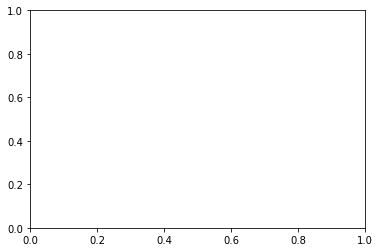

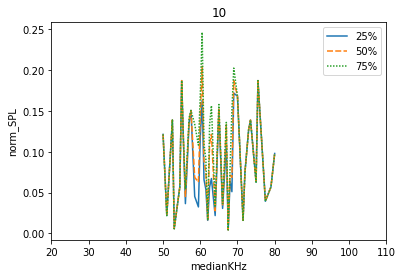

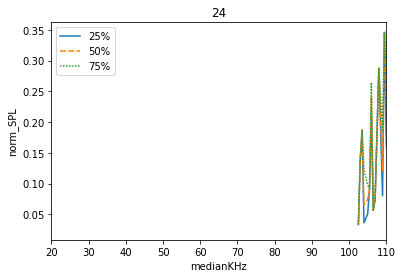

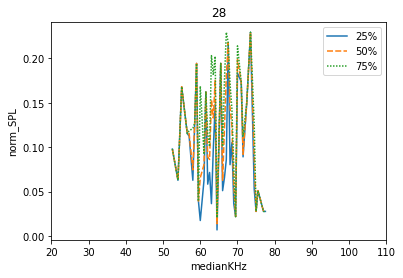

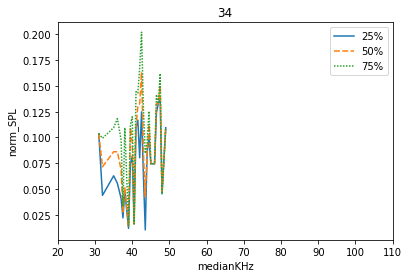

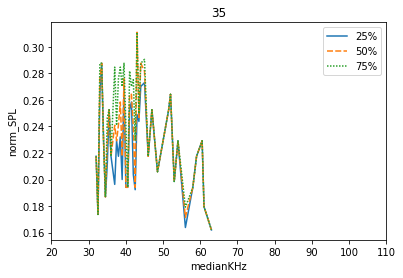

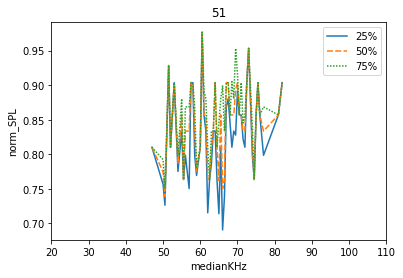

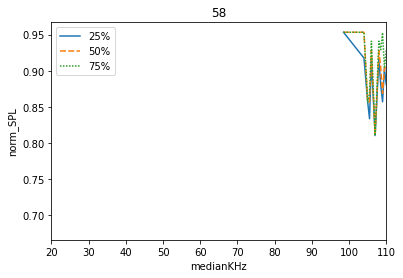

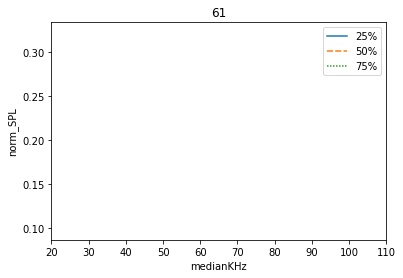

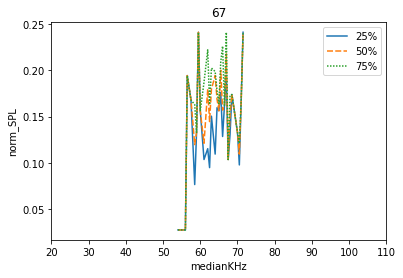

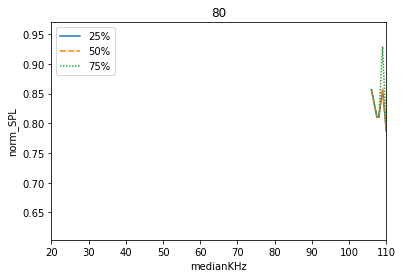

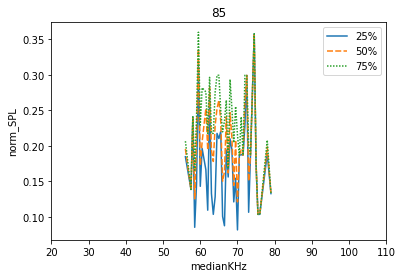

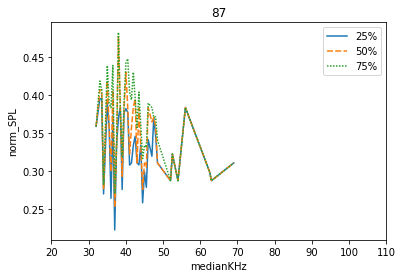

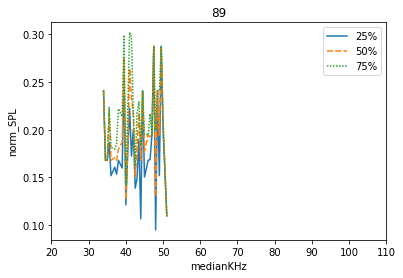

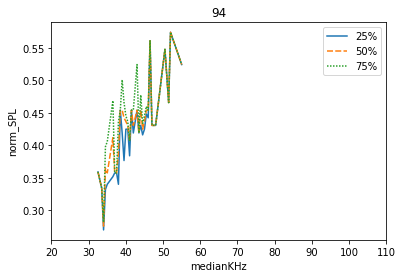

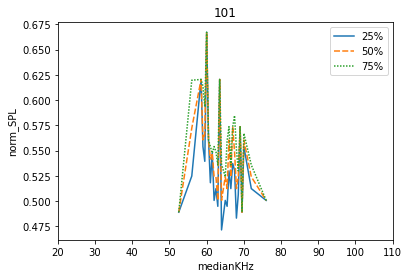

In [ ]:
tt = [  'avSPL_1']
scaler = MinMaxScaler(feature_range=(0, 1))
all_median_clus['norm_SPL'] = scaler.fit_transform(all_median_clus[tt]) 
temp = sorted(all_median_clus.hdb.unique())
fig, ax = plt.subplots()

for cl in temp:
    plt.figure()
    clus_0 = all_median_clus[all_median_clus.hdb==cl]
    Norm_SPL = clus_0.groupby(['medianKHz']).describe() 
    sns.lineplot(data=Norm_SPL['norm_SPL'][['25%', '50%', '75%']])
    plt.xlim(20,110)
    plt.ylabel('norm_SPL')
    plt.title(cl)
    plt.savefig(f'finals/hdbs_medianKHz_Norm_SPL{cl}.png')


/tmp/ipykernel_24/3434256617.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

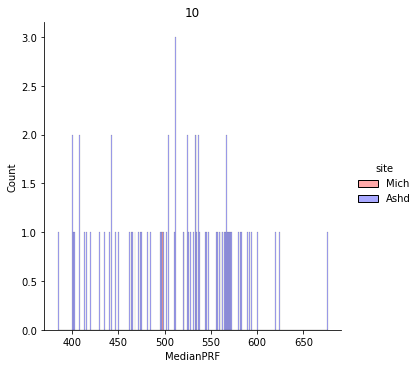

<Figure size 432x288 with 0 Axes>

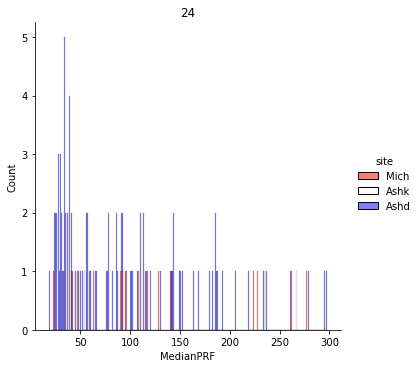

<Figure size 432x288 with 0 Axes>

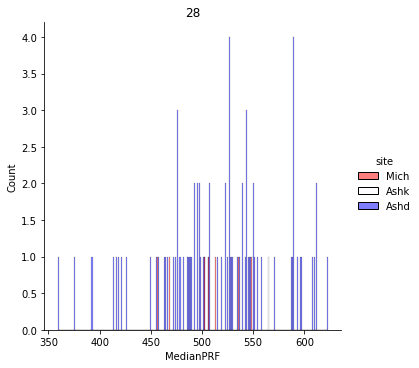

<Figure size 432x288 with 0 Axes>

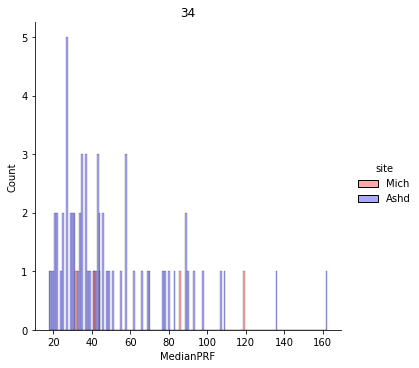

<Figure size 432x288 with 0 Axes>

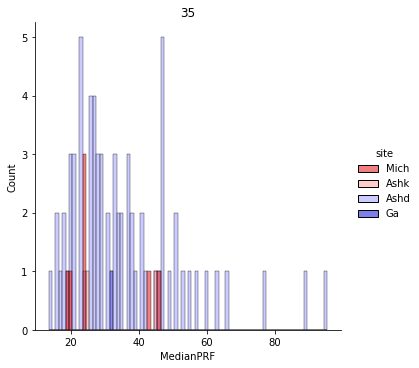

<Figure size 432x288 with 0 Axes>

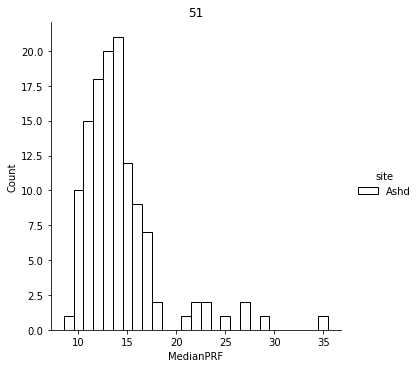

<Figure size 432x288 with 0 Axes>

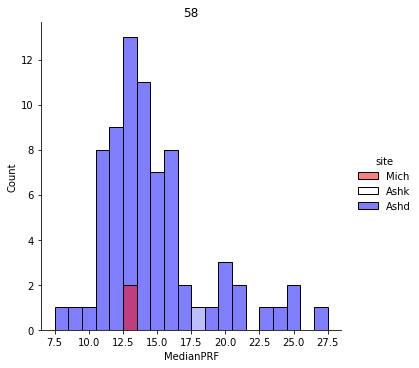

<Figure size 432x288 with 0 Axes>

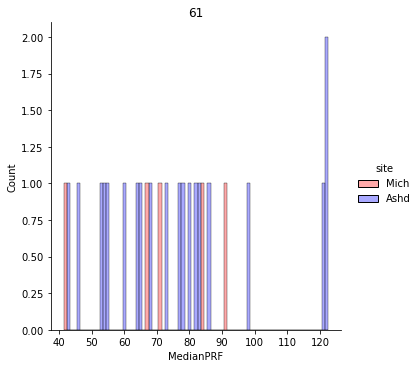

<Figure size 432x288 with 0 Axes>

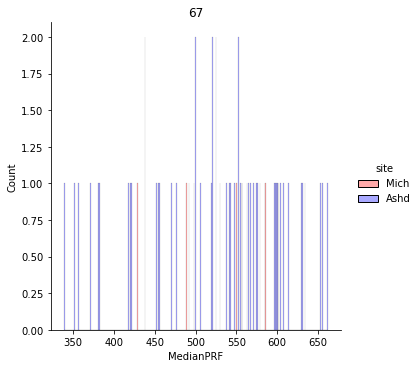

<Figure size 432x288 with 0 Axes>

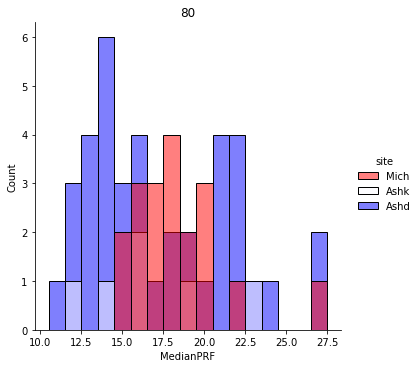

<Figure size 432x288 with 0 Axes>

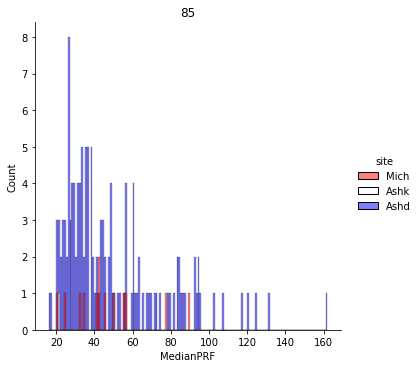

<Figure size 432x288 with 0 Axes>

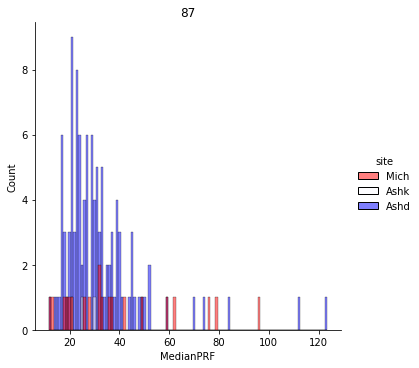

<Figure size 432x288 with 0 Axes>

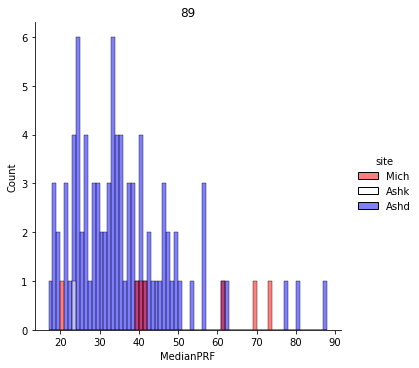

<Figure size 432x288 with 0 Axes>

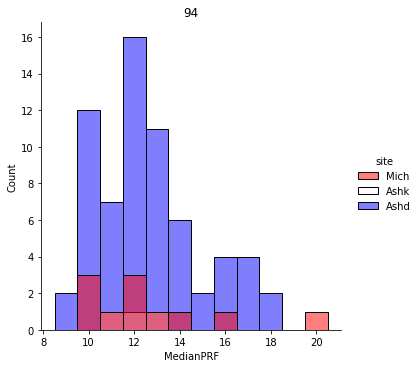

<Figure size 432x288 with 0 Axes>

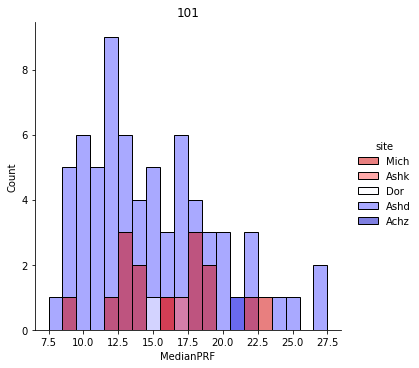

In [ ]:
temp = sorted(all_median_clus.hdb.unique())
for cl in temp:
    plt.figure()
    clus_0 = all_median_clus[all_median_clus.hdb==cl]
    sns.displot(clus_0, x= 'MedianPRF',discrete=True,hue = 'site', element="bars",palette='seismic_r')
    plt.title(cl)
    plt.savefig(f'finals/all_median{cl}.png')

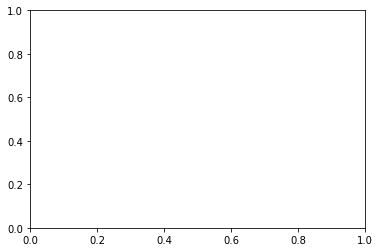

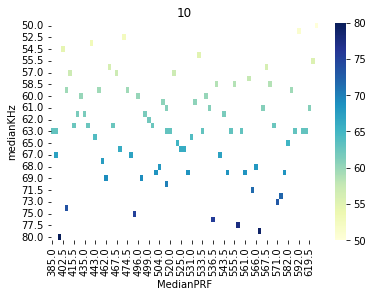

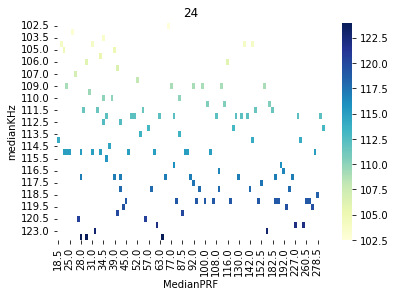

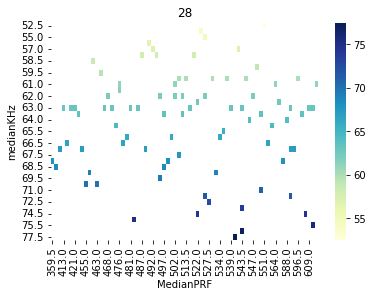

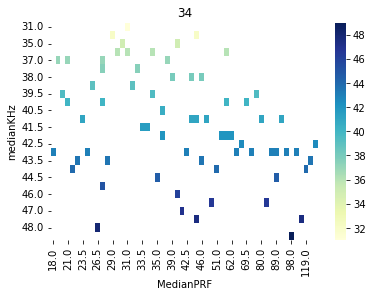

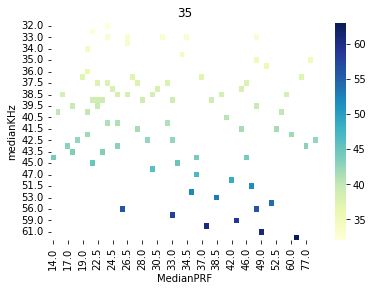

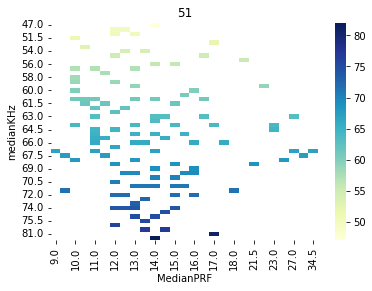

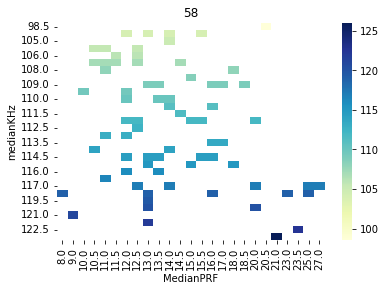

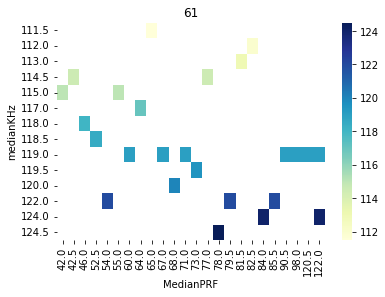

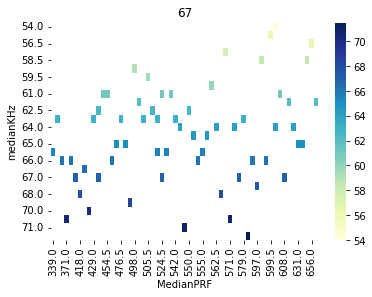

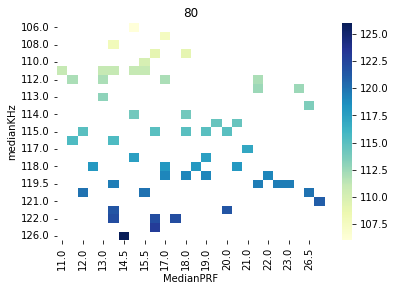

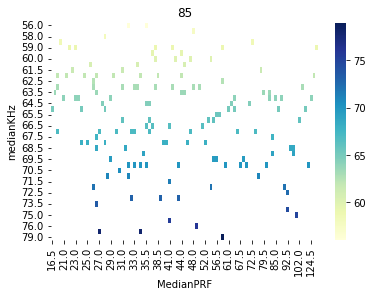

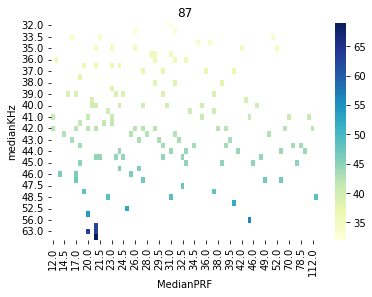

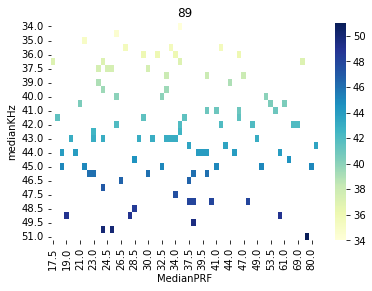

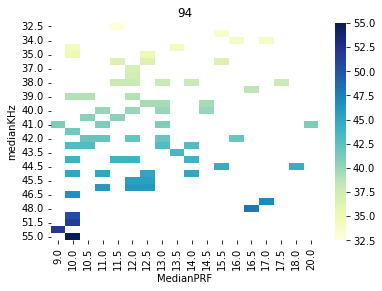

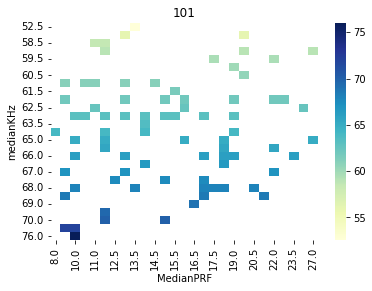

In [ ]:
temp = sorted(all_median_clus.hdb.unique())
fig, ax = plt.subplots()
for cl in temp:
    plt.figure()
    clus_0 = all_median_clus[all_median_clus.hdb==cl]
    NofClx_group = clus_0.groupby(['medianKHz','MedianPRF']).medianKHz.mean().unstack()
    ax = sns.heatmap(NofClx_group, cmap="YlGnBu")
    # plt.ylim(20,110)
    plt.title(cl)
    plt.savefig(f'finals/hdb_heat_NofClx_1{cl}.png')




## Elaborated EDA and Feature Engineering 

### Dealing with Nan

In [ ]:
f_pod.shape

(608266, 32)

In [ ]:
f_pod.dropna(inplace=True)

In [ ]:
f_pod.isna().sum()

File_1            0
Time_1            0
ClksThisMin_1     0
NofClx_1          0
medianKHz         0
avEndF_1          0
nRisingIPIs       0
avSPL_1           0
TrDur_us_1        0
MedianPRF         0
nICIrising        0
MinICI_us_1       0
midpointICI       0
MaxICI_us_1       0
ClkNofMinICI      0
ClkNofMaxICI      0
NofClstrs_1       0
avClstrNx8        0
avclF0            0
avclF1            0
avPkIPI           0
BeforeIPIratio    0
PreIPIratio       0
Post1IPIratio     0
Post2IPIratio     0
EndIPIratio       0
site              0
month             0
year              0
hour              0
day365            0
Minute            0
dtype: int64

In [ ]:
f_pod.shape

(608266, 32)

In [ ]:
# (f_pod==0).astype(int).sum(axis=0)     

File.1                 0
Time.1                 0
ClksThisMin.1          0
NofClx.1               0
medianKHz              0
avEndF.1               0
nRisingIPIs       271835
avSPL.1                0
avBWx8                 0
TrDur_us.1             0
MedianPRF              0
nICIrising         10102
MinICI_us.1            0
midpointICI            0
MaxICI_us.1            0
ClkNofMinICI           0
ClkNofMaxICI           0
NofClstrs.1        83159
avClstrNx8         83159
avclF0            233581
avclF1            287812
avPkIPI                0
BeforeIPIratio     26081
PreIPIratio           24
Post1IPIratio      25374
Post2IPIratio     110483
EndIPIratio           15
dtype: int64

There are many zeros, how should I treat them?


### Categorical Data

In [ ]:
f_pod['File_1'].value_counts()

Asdod fish farm 2020 01 13 FPOD_6101 file0.FP3       207444
Ashdod ff 2020 07 05 FPOD_6068 file0.FP3              79876
Asdod fish farm 2020 01 13 FPOD_6101 file1.FP3        73196
Ashdod ff 2021 04 05 FPOD_6101 file0.FP3              64387
Ashdod f.f 2019 06 21 FPOD_6068 file0.FP3             53453
Ashdod ff 2020 11 16 FPOD_6070 file0.FP3              46532
michmoret ff 2020 08 18 FPOD_6101 file0.FP3           32502
michmoret f.f 2019 07 02 FPOD_6069 file0.FP3          16097
michmoret ff 2020 02 16 FPOD_6069 file0.FP3           10970
michmoretff 2019 10 23 FPOD_6070 file0.FP3             7226
michmoret ff 2020 08 18 FPOD_6101 file1.FP3            4612
Ashdod ff 2021 04 05 FPOD_6101 file1.FP3               4041
Ashkekon 2021 04 07 FPOD_6070 file0.FP3                3849
Ashkelon 2020 05 17 FPOD_6069 file0.FP3                1808
seagard Ashkelon 2020 03 08 FPOD_6070 file0.FP3        1183
Achiv 2020 01 27 FPOD_6068 file0.FP3                    157
Achziv 2019 11 10 FPOD_6069 file0.FP3   

In [ ]:
f_pod.site.unique()

array(['Achziv', 'Dor', 'Michmoret', 'Gaash', 'Ashdod', 'Ashkelon'],
      dtype=object)

** Since there are such big differences in sites detections its hard to know if the unique values represent something

### Datetime

<AxesSubplot:xlabel='Time_1'>

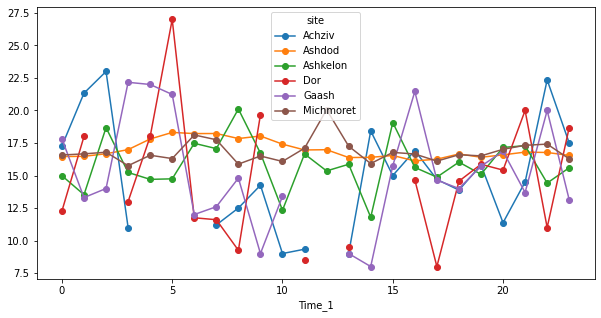

In [ ]:
# # # # in this way I can work with any index

# f_pod.groupby(
#     [f_pod["Time_1"].dt.hour, "site"])["NofClx_1"].mean().unstack().plot(style="-o", figsize=(10, 5))

In [ ]:
# site_order = tf_pod.site.unique()
# site_map = dict(zip(site_order, range(len(site_order))))
# tf_pod.loc[:, 'site'] = tf_pod['site'].map(site_map)

In [ ]:
# f_pod.drop('Time_1', axis = 1, inplace = True)


### Site

In [ ]:
# site_order = f_pod.site.unique()
# site_map = dict(zip(site_order, range(len(site_order))))
# f_pod.loc[:, 'site'] = f_pod['site'].map(site_map)

In [ ]:
f_pod.groupby(['site']).size()

site
Achziv          410
Ashdod       529073
Ashkelon       6885
Dor             214
Gaash           277
Michmoret     71407
dtype: int64

### DPM

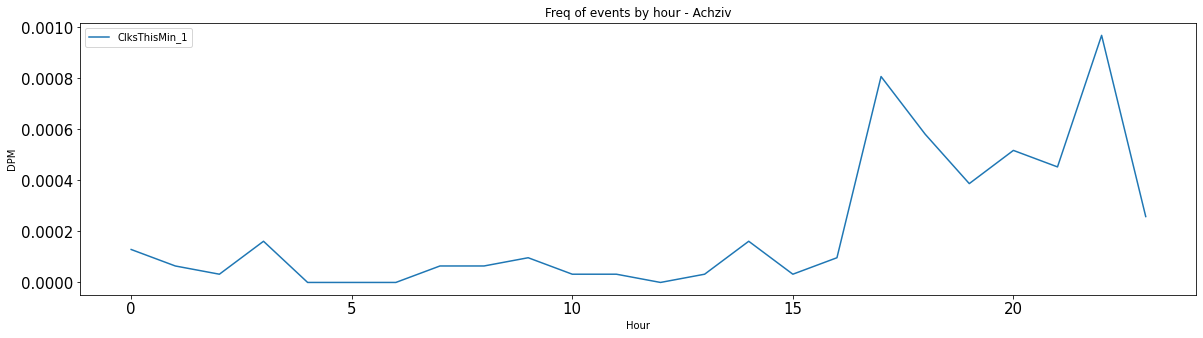

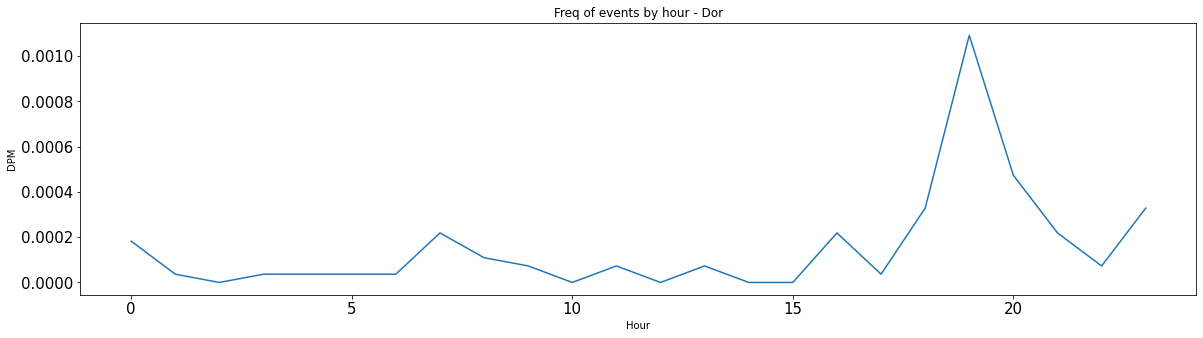

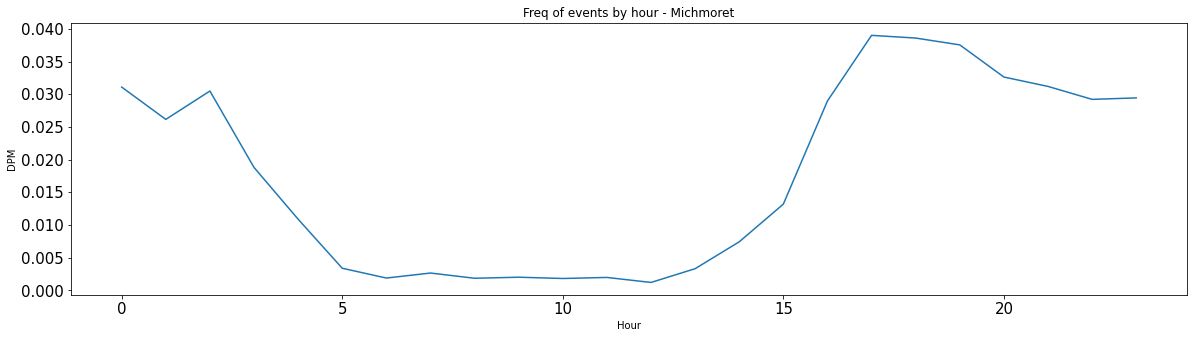

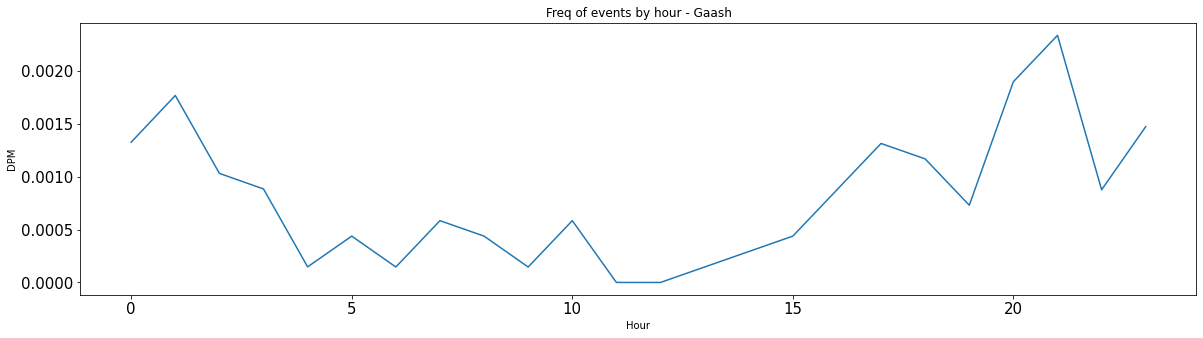

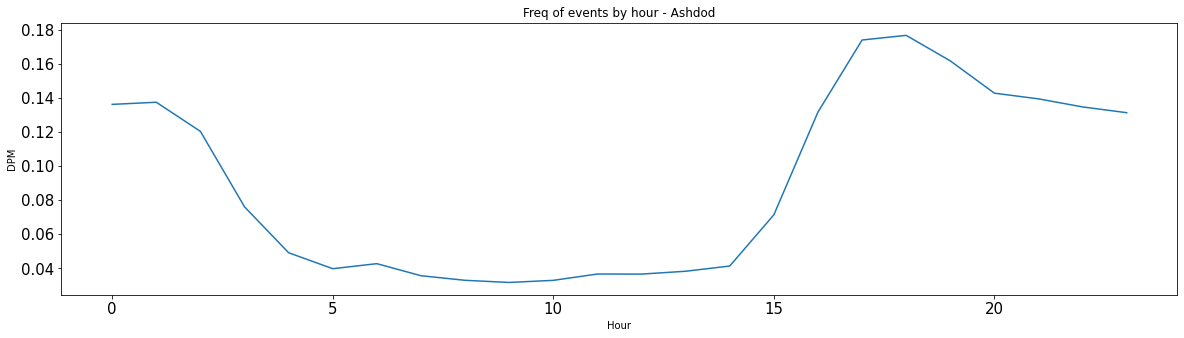

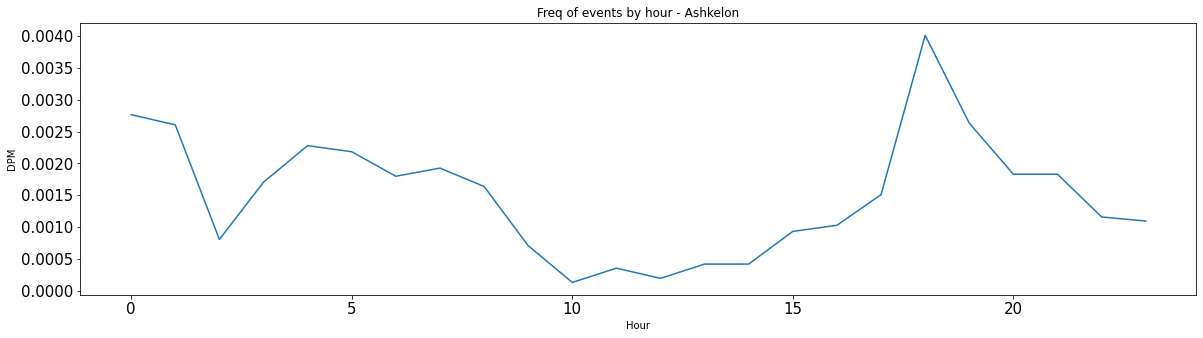

In [ ]:
temp = f_pod.site.unique()
fig, ax = plt.subplots(sharex = True)
for s in temp:
    site =  tf_pod[tf_pod.site.isin([s])]
    DPM = (site.resample('Min').count()/site.resample('Min').count())
    DPM = DPM.resample('60Min').count()/60
    DPM['Time_1'] = DPM.index
    DPM.groupby([DPM["Time_1"].dt.hour]).ClksThisMin_1.mean().plot( ylabel = 'DPM' ,  xlabel = 'Hour', fontsize= 15, title = f'Freq of events by hour - {s}'  ,figsize = (20,5) )

In [ ]:
temp = f_pod.site.unique()
fig, ax = plt.subplots()
for s in temp:
    tf_pod[tf_pod.site.isin([s])].medianKHz.resample('Min').count().plot( ylabel = 'DPM' ,  xlabel = 'Time', fontsize= 15, title = f'DPM {s}'  ,figsize = (20,5) )
    ax.legend()
    plt.savefig(f'site_events{s}.png')
    plt.show()

    

### Seasonality and daily patterns

I was trying to work with datetimeindex but it was a problem due to the duplicated dates coming from differnt sites.
I tried cumcount to create multindex but still a problem. 

In [ ]:
# #df_time.loc['2017-11-02 23:00' : '2017-12-01'].count()
# #df_time.resample('M').mean().head()
# #df_time.resample('10Min').mean().head()
# #df_time.resample('10Min').mean().ffill().head()
# sns.set_style("darkgrid") #darkgrid 
# # sns.set()
# # tf_pod = f_pod.pivot(index="Time_1", columns="site", values="NofClx_1")
# temp = tf_pod.resample('D').mean()

# # tf_pod.plot(style="-o", figsize=(10, 5))
# # plt.title('Mean NofClx_1 for Site by day ')
# # plt.ylabel('NofClx_1')
# # plt.xticks(rotation=45)
# # plt.show()


In [ ]:
# tf_pod.set_index(tf_pod.groupby(tf_pod.index).cumcount(), append=True)

### Site daily, hourly and monthly EDA

In [ ]:
# (temp==0).astype(int).sum(axis=0)

In [ ]:
# len(temp)

In [ ]:
# #Sample plotting
# temp = tf_pod.loc['2020-01-28 08:52:00':'2020-06-13 19:06:00']
# temp = temp[temp.site.isin(['Ashkelon'])]
# sns.set_style("darkgrid") #darkgrid 
# temp.groupby(
#     [temp["Time_1"].dt.hour, "site"]).TrDur_us_1.size().unstack().plot( figsize=(10, 5))# style="-o"
# # plt.xticks(rotation=45)

In [ ]:
# plt.style.use ('ggplot')
# plt.rcParams['figure.figsize'] = [10, 4]
# tf_pod.groupby(['year','month','site']).size().unstack().plot()

In [ ]:
# tf_pod.groupby(['hour','site']).size().unstack().plot()

<AxesSubplot:xlabel='month'>

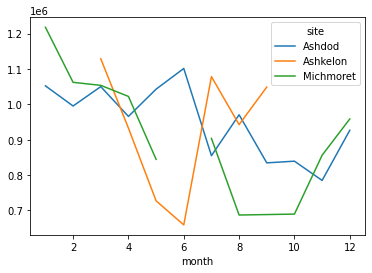

In [ ]:
asmas.groupby(['month','site']).TrDur_us_1.mean().unstack().plot()

<AxesSubplot:xlabel='hour'>

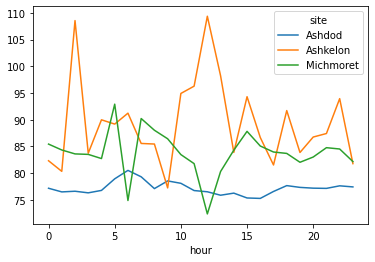

In [ ]:
asmas.groupby(['hour','site']).medianKHz.mean().unstack().plot()

<AxesSubplot:xlabel='hour'>

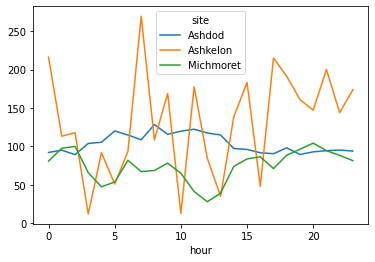

In [ ]:
asmas.groupby(['hour','site']).MedianPRF.mean().unstack().plot()


<AxesSubplot:xlabel='hour'>

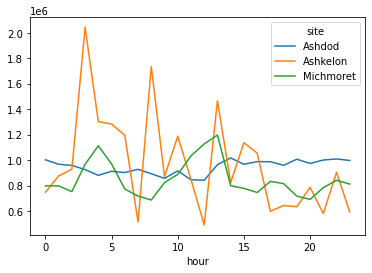

In [ ]:
asmas.groupby(['hour','site']).TrDur_us_1.mean().unstack().plot()


<AxesSubplot:xlabel='hour'>

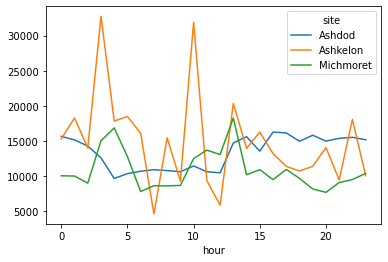

In [ ]:
asmas.groupby(['hour','site']).MaxICI_us_1.median().unstack().plot()


Since I see monthly patterns will be hard to establish it might be better to build a daily behaviour.
I do need to see if the daily behavior is correlated to the fish farm activity

### Correleation

In [ ]:
# # maybe interesting - TrDur_us_1,MedianPRF,nICIrising,MinICI_us_1,midpointICI,MaxICI_us_1,ClkNofMaxICI
# h_fpod = f_pod.groupby(['hour']).mean()
# h_fpod = h_fpod.reset_index(drop=False)
# pp = sns.pairplot(data=h_fpod,
#                   y_vars=h_fpod.columns,
#                   x_vars=['hour'])

In [ ]:
f_corr =f_pod.corr().abs()
# f_corr = f_corr.loc[f_corr != 1] #removinfg all values equal to 1
u_f_corr =f_corr.unstack()[f_corr.unstack()!=1]
so = u_f_corr.sort_values(kind="quicksort",ascending=False)
so.head(30)

medianKHz       avPkIPI           0.812363
avPkIPI         medianKHz         0.812363
avEndF_1        medianKHz         0.796681
medianKHz       avEndF_1          0.796681
avEndF_1        avPkIPI           0.781877
avPkIPI         avEndF_1          0.781877
ClkNofMinICI    NofClx_1          0.738824
NofClx_1        ClkNofMinICI      0.738824
MaxICI_us_1     TrDur_us_1        0.726993
TrDur_us_1      MaxICI_us_1       0.726993
avclF0          avclF1            0.684526
avclF1          avclF0            0.684526
EndIPIratio     PreIPIratio       0.638470
PreIPIratio     EndIPIratio       0.638470
NofClx_1        ClkNofMaxICI      0.619374
ClkNofMaxICI    NofClx_1          0.619374
NofClstrs_1     TrDur_us_1        0.550833
TrDur_us_1      NofClstrs_1       0.550833
nRisingIPIs     NofClx_1          0.545606
NofClx_1        nRisingIPIs       0.545606
NofClstrs_1     NofClx_1          0.533546
NofClx_1        NofClstrs_1       0.533546
avclF1          avClstrNx8        0.531041
avClstrNx8 

In [ ]:
# plt.rcParams['figure.figsize'] = [20, 10]
# sns.heatmap(f_pod.corr().abs(),cmap='bwr' )


In [ ]:
#Crashed..
# f_pod_num = f_pod.select_dtypes(include=np.number)
# sns.pairplot(f_pod_num, height=1.5)

### Distribution of data (Distplots)

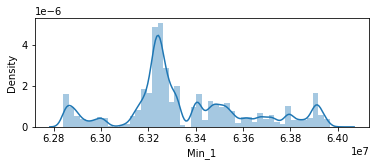

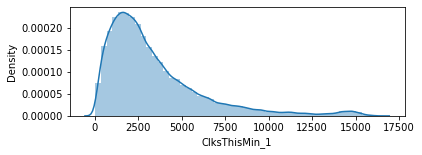

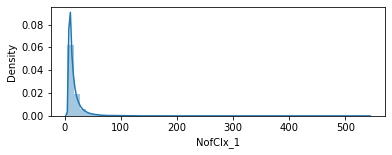

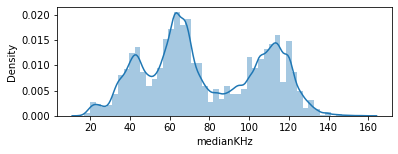

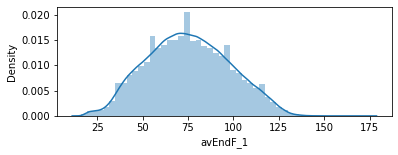

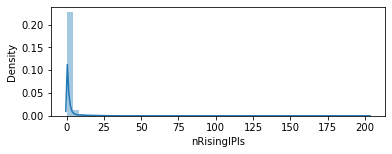

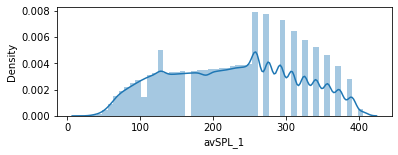

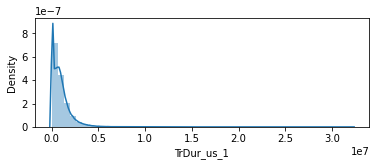

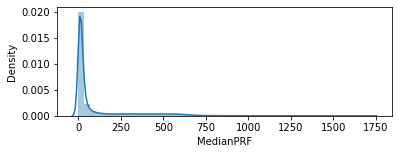

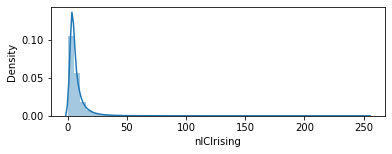

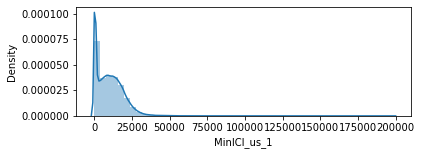

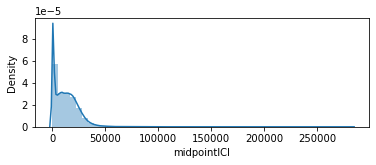

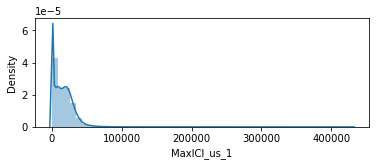

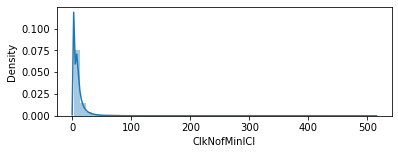

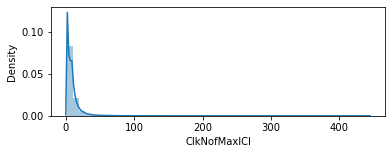

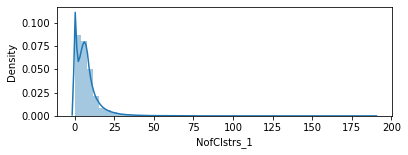

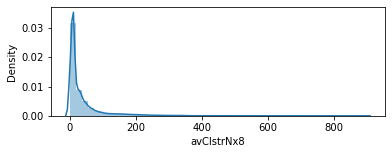

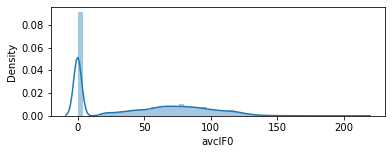

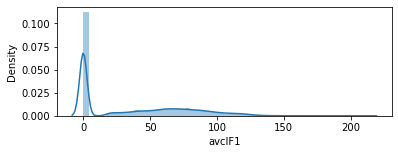

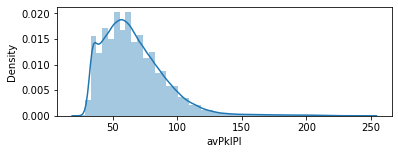

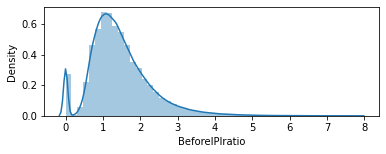

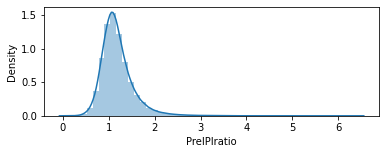

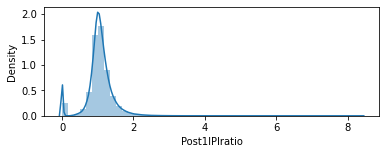

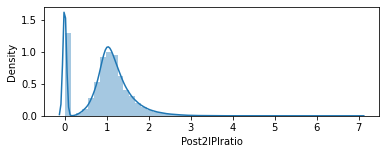

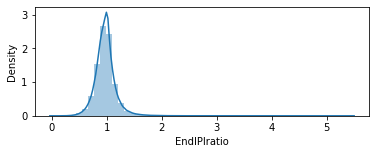

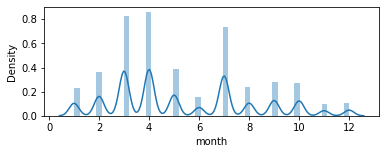

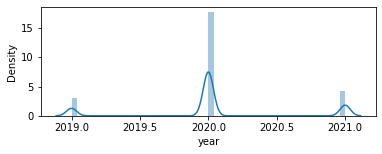

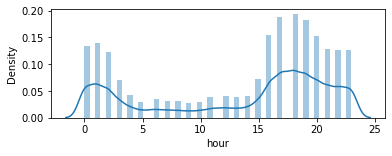

In [ ]:
# create distplots
plt.rcParams['figure.figsize'] = [6, 2]
f_pod_num = f_pod.select_dtypes(include=np.number)
for col in f_pod_num.columns:
    plt.figure()             # <==================== important to draw each plo!
    sns.distplot(f_pod[col])

### Removing outliers

In [ ]:
####################################### NofClx_1
rf_pod = f_pod[f_pod.NofClx_1 <200] # above 200 is removed 
####################################### medianKHz
temp = rf_pod.medianKHz.value_counts(normalize  = True) # # outliers under freq 0.0005 were removed 
temp = temp[temp<0.0005]
medianKHz_out = temp.index.tolist() 
rf_pod = rf_pod[~rf_pod['medianKHz'].isin(medianKHz_out)]
#######################################avEndF_1
temp = rf_pod.avEndF_1.value_counts(normalize  = True) # under freq 0.0005 
temp = temp[temp<0.001]
avEndF_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['avEndF_1'].isin(avEndF_out)]
####################################### nRisingIPIs
temp = rf_pod.nRisingIPIs.value_counts(normalize  = True)# under freq 0.0009 
temp = temp[temp<0.0009]
RisingIPI_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['nRisingIPIs'].isin(RisingIPI_out)]
####################################### avSPL_1
temp = rf_pod.avSPL_1.value_counts(normalize  = True) # under freq 0.0002 
temp = temp[temp<0.002]
avSPL_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['avSPL_1'].isin(avSPL_out)]
####################################### TrDur_us_1
# f_pod.drop('TrDur_us_1', axis = 1, inplace = True) # I am not sure what to do about it, more than 
rf_pod = rf_pod[rf_pod['TrDur_us_1']<4000000]
####################################### MedianPRF
temp = rf_pod.MedianPRF.value_counts() # under 5 occurences 
temp = temp[temp<5]
MedianPRF_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['MedianPRF'].isin(MedianPRF_out)]  
####################################### MaxICI_us_1
rf_pod = rf_pod[f_pod['MaxICI_us_1']<100000] # cutting edge at 100000
####################################### ClkNofMinICI
temp = rf_pod.ClkNofMinICI.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
ClkNofMinICI_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['ClkNofMinICI'].isin(ClkNofMinICI_out)]
####################################### ClkNofMaxICI
temp = rf_pod.ClkNofMaxICI.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
ClkNofMaxICI_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['ClkNofMaxICI'].isin(ClkNofMaxICI_out)]
####################################### NofClstrs_1
temp = rf_pod.NofClstrs_1.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
NofClstrs_1_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['NofClstrs_1'].isin(NofClstrs_1_out)]
####################################### NofClstrs_1
temp = rf_pod.avClstrNx8.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
avClstrNx8_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['avClstrNx8'].isin(avClstrNx8_out)]
####################################### avclF0
temp = rf_pod.avclF0.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
avclF0_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['avclF0'].isin(avclF0_out)]
####################################### avclF1
temp = rf_pod.avclF1.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
avclF1_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['avclF1'].isin(avclF1_out)]
####################################### avPkIPI
temp = rf_pod.avPkIPI.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
avPkIPI_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['avPkIPI'].isin(avPkIPI_out)] 
####################################### BeforeIPIratio
temp = rf_pod.BeforeIPIratio.value_counts(normalize=True) # under freq 0.0001 
temp = temp[temp<0.0001]
BeforeIPIratio_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['BeforeIPIratio'].isin(BeforeIPIratio_out)]  
####################################### BeforeIPIratio
temp = rf_pod.BeforeIPIratio.value_counts(normalize=True) # under freq 0.0001 
temp = temp[temp<0.0001]
BeforeIPIratio_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['BeforeIPIratio'].isin(BeforeIPIratio_out)] 
####################################### PreIPIratio
temp = rf_pod.PreIPIratio.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
PreIPIratio_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['PreIPIratio'].isin(PreIPIratio_out)]  
####################################### Post1IPIratio
temp = rf_pod.Post1IPIratio.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
Post1IPIratio_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['Post1IPIratio'].isin(Post1IPIratio_out)]  
####################################### Post2IPIratio
temp = rf_pod.Post2IPIratio.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
Post2IPIratio_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['Post2IPIratio'].isin(Post2IPIratio_out)]  
####################################### EndIPIratio
temp = rf_pod.EndIPIratio.value_counts(normalize  = True) # under freq 0.0001 
temp = temp[temp<0.0001]
EndIPIratio_out = temp.index.tolist()
rf_pod = rf_pod[~rf_pod['EndIPIratio'].isin(EndIPIratio_out)] 

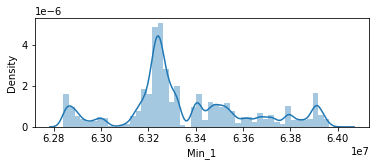

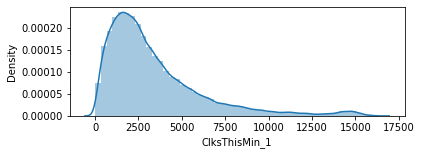

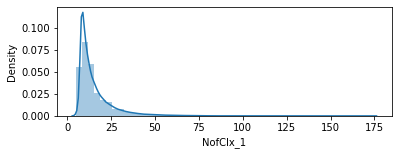

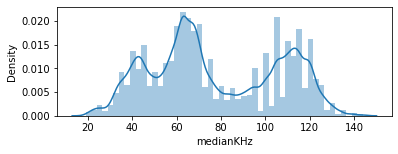

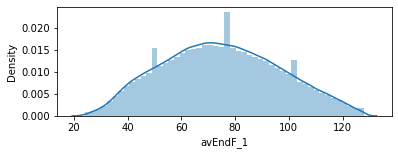

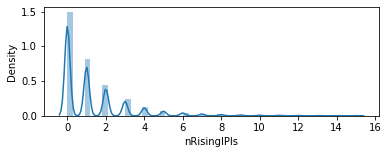

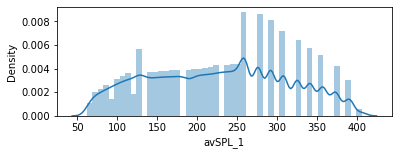

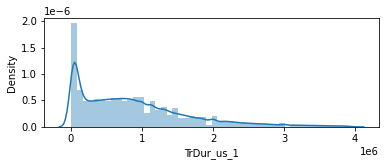

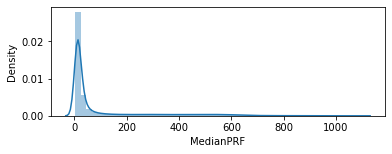

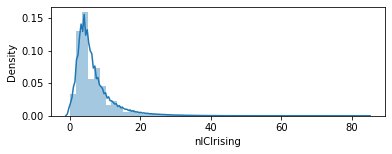

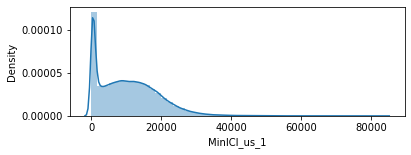

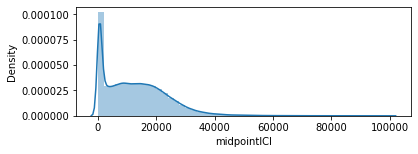

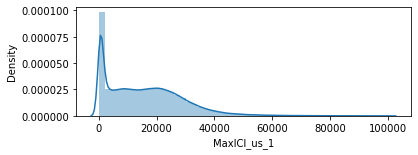

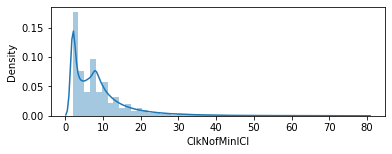

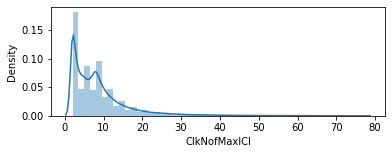

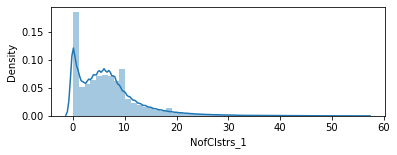

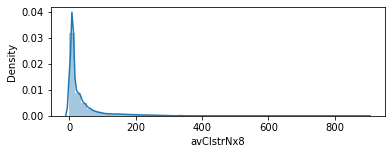

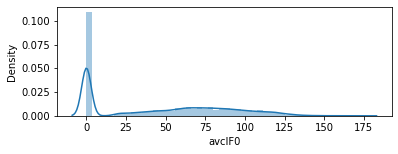

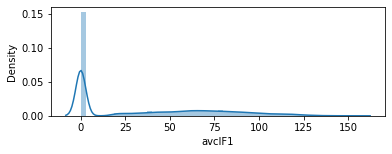

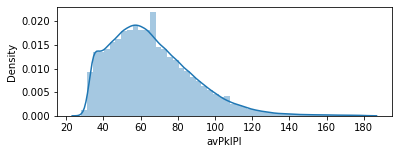

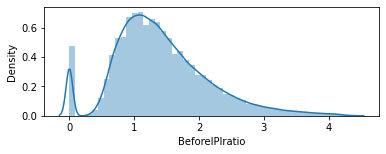

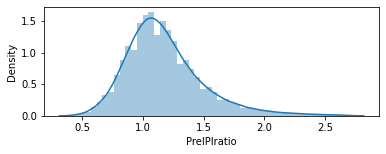

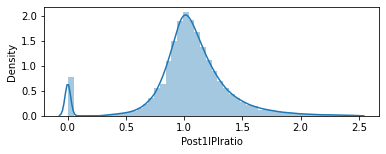

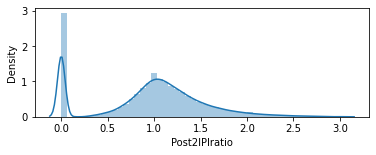

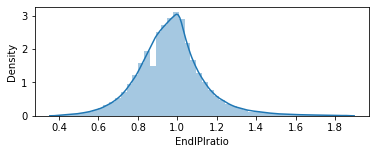

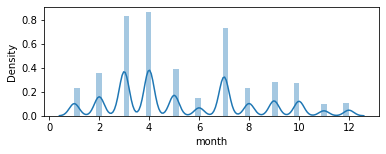

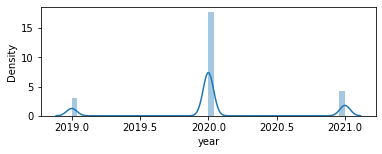

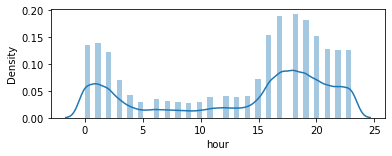

In [ ]:
# create distplots
plt.rcParams['figure.figsize'] = [6, 2]
f_pod_num = rf_pod.select_dtypes(include=np.number)
for col in f_pod_num.columns:
    plt.figure()             # <==================== important to draw each plo!
    sns.distplot(rf_pod[col])

### remove outliers exploration

In [ ]:
rf_pod.groupby('site').size()

site
Achziv          375
Ashdod       486561
Ashkelon       6322
Dor             192
Gaash           242
Michmoret     66037
dtype: int64

In [ ]:
a = temp.index.tolist()
rf_pod = f_pod[f_pod['EndIPIratio'].isin(a)]
rf_pod.groupby('site').size()

site
Achziv          1
Ashdod       1676
Ashkelon       34
Dor             1
Michmoret     271
dtype: int64

In [ ]:
f_pod.MedianPRF.value_counts().sum()

608266

In [ ]:
f_pod[f_pod.MaxICI_us_1 >100000].groupby('site').size()

site
Achziv         5
Ashdod       852
Ashkelon      12
Dor            3
Michmoret    167
dtype: int64

In [ ]:
medKHzout =[131,135,142,138,152,158,136,146,17,133,141,155,137,98,18,149]

In [ ]:
# rf_pod = f_pod[f_pod.medianKHz >140]
temp = f_pod.EndIPIratio.value_counts(normalize=True)
temp = temp[temp<0.0001]
# avEndF_out = temp.index.tolist()
temp

1.88    0.000097
0.34    0.000095
1.90    0.000084
1.93    0.000082
1.87    0.000076
          ...   
3.82    0.000002
4.88    0.000002
3.79    0.000002
4.21    0.000002
3.11    0.000002
Name: EndIPIratio, Length: 200, dtype: float64

In [ ]:
f_pod.EndIPIratio.value_counts().to_frame()

EndIPIratio
1.00        19523
1.01        19152
0.99        18692
0.98        18185
0.97        17939
...           ...
3.82            1
4.88            1
3.79            1
4.21            1
3.11            1

[354 rows x 1 columns]

In [ ]:
f_pod.ClkNofMinICI.nlargest(10)

194928    513.0
569678    395.0
89029     390.0
499259    364.0
94752     356.0
142716    345.0
327071    336.0
592891    321.0
89026     318.0
320373    312.0
Name: ClkNofMinICI, dtype: float64

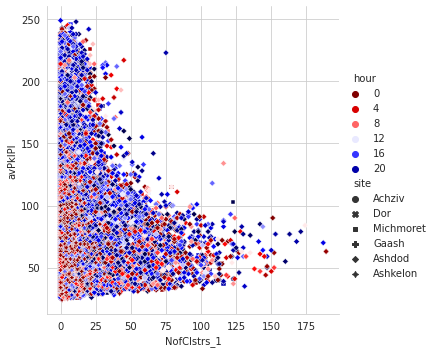

In [ ]:
sns.set_style('whitegrid')
sns.relplot(x="NofClstrs_1", y="avPkIPI", hue="hour", style="site",palette='seismic_r', data=f_pod)


(0.0, 100.0)

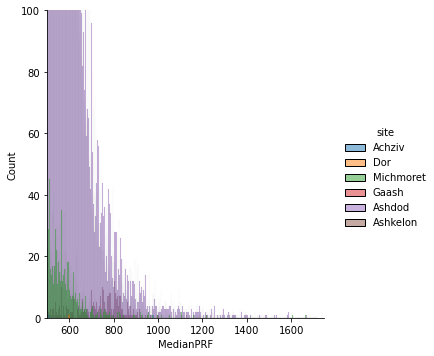

In [ ]:
sns.displot(f_pod, x= 'MedianPRF',hue = 'site', element="bars")
plt.xlim(500,1750)
plt.ylim(0,100)

In [ ]:
# plt.rcParams['figure.figsize'] = [6, 2]
# for col in f_pod.columns:
#     temp =f_pod[col]
#     temp.value_counts()#[f_pod['ClksThisMin_1'].value_counts()]
#     plt.figure()
#     a = len(temp)
#     sns.histplot(temp,bins= a)


KeyboardInterrupt



Error in callback <function flush_figures at 0x7f45a5cfcca0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
f_pod.NofClx_1.value_counts().value_counts()

1       40
2       25
4       18
3       15
5        9
        ..
1295     1
1339     1
1375     1
1472     1
230      1
Name: NofClx_1, Length: 141, dtype: int64

### Binning

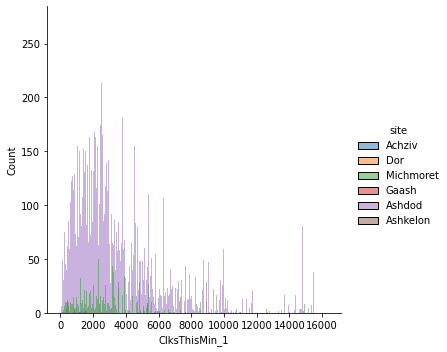

In [ ]:
# ClksThisMin  =  all clicks logged in the minute
#Since it has much variability it affects the models more than it should

sns.displot(f_pod, x= 'ClksThisMin_1',discrete=True,hue = 'site', element="bars")

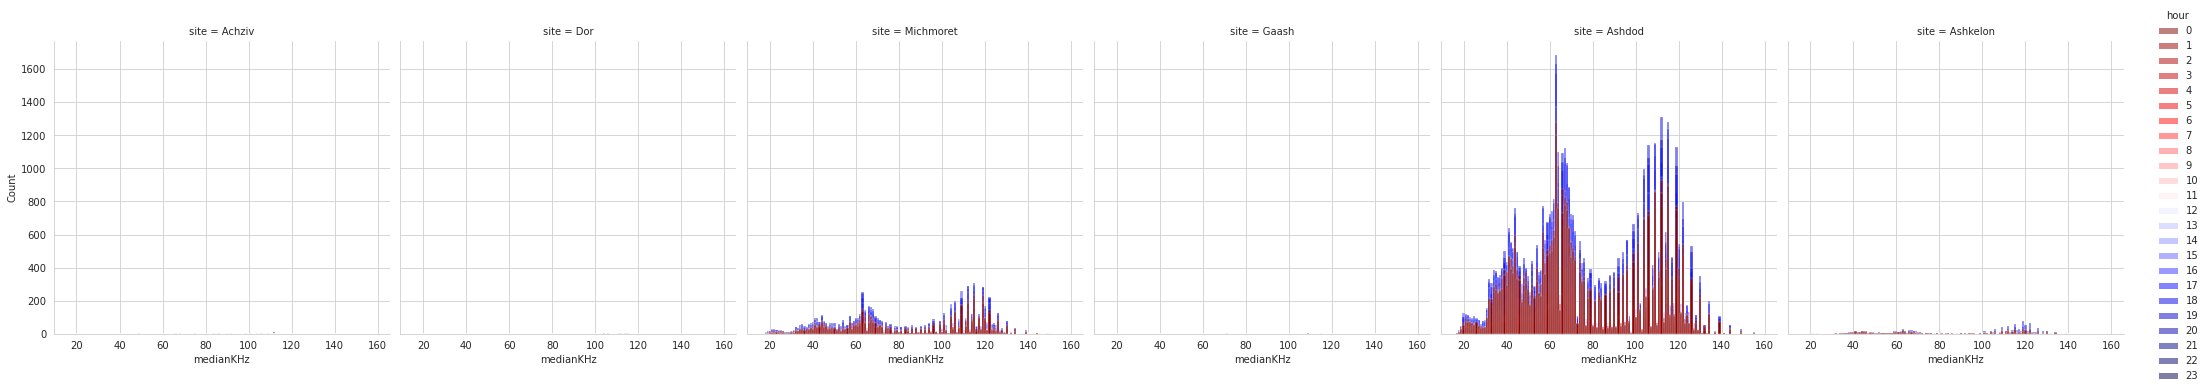

In [ ]:
sns.set_style('whitegrid')seismic_r
# sns.color_palette("gggplot")
sns.displot(f_pod, x= 'medianKHz',discrete=True,hue = 'hour', element="bars",palette='seismic_r',col="site")

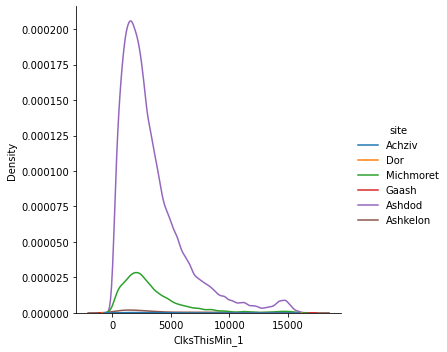

In [ ]:
sns.displot(f_pod, x= 'ClksThisMin_1',hue = 'site', kind="kde")

In [ ]:
# >>>data['column_bin']=0
# >>>data.loc[(data['column']<=1000) ,'column_bin']= 0
# >>>data.loc[(data['column']>1000) & (data['column']>=5000) ,'column_bin']=1
# >>>data.loc[(data['column']>5000) & (data['column']>=50000, 'column_bin']=2
# >>>data.loc[(data['column']>50000) & (data['column']>=100000) ,'column_bin']= 3

In [ ]:
cut_labels = np.arange(1, 327)

# Define bin edges
cut_bins = np.arange(15, 16365, 50)

rf_pod['ClMin_bin'] = pd.cut(rf_pod['ClksThisMin_1'], bins=cut_bins, labels=cut_labels)
rf_pod.dropna(inplace=True)
rf_pod.ClMin_bin = rf_pod.ClMin_bin.astype(int)

# All different trials To Model

### Split again

In [ ]:
f_pod_model = pd.get_dummies(f_pod_model , drop_first= True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0.01, 1.01))
Clus = f_pod_model
tt = [ 'medianKHz','MedianPRF','MaxICI_us_1','MinICI_us_1','midpointICI','NofClx_1', 'avSPL_1']
Clus[tt] = scaler.fit_transform(Clus[tt])
zscaler = MinMaxScaler(feature_range=(0, 1))
attribs_z= ['avclF0', 'PreIPIratio','Post1IPIratio','Post2IPIratio']
Clus[attribs_z] = zscaler.fit_transform(Clus[attribs_z])


/tmp/ipykernel_45/658902432.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clus[tt] = scaler.fit_transform(Clus[tt])
/tmp/ipykernel_45/658902432.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clus[attribs_z] = zscaler.fit_transform(Clus[attribs_z])


In [ ]:
Clus.shape

(486561, 11)

### DBSCAN

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
# sClus = Clus.sample(frac=0.75, replace=True, random_state=112211)
# tClus = Clus
# tClus['kcluster'] = labels

In [ ]:
dbscan = DBSCAN(eps=0.1, min_samples=2,algorithm='ball_tree', metric='euclidean' )#leaf_size=30
Ashkelon['dbclus'] = dbscan.fit_predict(Clus)

/tmp/ipykernel_25/3722544306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ashkelon['dbclus'] = dbscan.fit_predict(Clus)


In [ ]:
Ashkelon.groupby(['dbclus']).size()

dbclus
-1     1118
 0     5068
 1       12
 2       14
 3        4
 4       11
 5       10
 6       10
 7       10
 8        4
 9        9
 10       4
 11       4
 12       5
 13       5
 14       6
 15       6
 16       5
 17       8
 18       5
 19       4
dtype: int64

In [ ]:
len(samp_pod)

242

In [ ]:
samp_pod.dbclus.value_counts()

-1     142
 0      43
 10     10
 7       8
 11      6
 3       5
 8       4
 6       2
 5       2
 4       2
 9       2
 2       2
 1       2
 12      2
 13      2
 14      2
 15      2
 16      2
 17      2
Name: dbclus, dtype: int64

In [ ]:
temp = samp_pod.dbclus.unique() # under freq 0.0001 
temp = temp[temp==-1]
dbclus_out = temp
# dbclus_out = temp.index.tolist()
samp_pod8 = samp_pod[~samp_pod['dbclus'].isin(dbclus_out)]

In [ ]:
samp_pod8

ClksThisMin_1  NofClx_1  medianKHz  avEndF_1  nRisingIPIs  avSPL_1  \
29            1220.0      11.0       62.0      76.0          1.0    138.0   
214           1087.5       9.5      110.5      99.0          0.0    284.0   
238           1344.5      11.5      110.5      91.5          0.5    333.0   
257           3687.0       9.5      100.0      87.5          0.5    341.0   
310           1835.5      10.0       67.0      65.0          1.0    186.0   
...              ...       ...        ...       ...          ...      ...   
10594         2093.5      17.0      114.5      98.5          0.5    243.0   
10662         2296.0       8.0      113.5     108.0          0.5    341.0   
10852         1700.0      10.5      112.0     107.0          1.0    357.0   
10889         2893.0       8.0      111.5     102.0          0.0    357.0   
10936         1727.0       9.0      119.0     102.0          0.0    357.0   

       TrDur_us_1  MedianPRF  nICIrising  MinICI_us_1  midpointICI  \
29       243902.0       45.0         3.0       3852.0       4176.0   
214      481250.0       20.5         5.0       7394.0       9783.5   
238     1211111.0        9.5         5.0      16695.5      21926.0   
257     1476190.0        6.5         4.5      21098.0      22279.0   
310      301339.0       35.5         4.0       5189.5       5378.0   
...           ...        ...         ...          ...          ...   
10594   1007017.0       17.0         7.5      10525.5      12389.0   
10662    588942.0       15.5         3.0       9767.5      12353.5   
10852   1630952.0        6.5         4.0      22655.0      27208.5   
10889    651514.5       11.5         3.5      12200.0      14165.0   
10936   1200000.0        9.0         5.0      18389.0      30797.0   

       MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  NofClstrs_1  avClstrNx8  \
29          4593.0          10.0           4.0          2.0         8.0   
214        11602.0           4.0           8.0          5.5        62.0   
238        30045.5           9.0           9.0          4.5        54.5   
257        39745.5           5.0           2.5          7.5       182.5   
310         7446.5           5.5           8.5          1.5         8.0   
...            ...           ...           ...          ...         ...   
10594      12607.0          16.5          10.0          6.5        21.5   
10662      15122.0           4.5           8.0          2.0        64.0   
10852      37521.0           7.5           8.0          6.5        66.5   
10889      17211.0           6.5           3.5          6.5       112.5   
10936      38541.0           9.0           5.0          9.0       114.0   

       avclF0  avclF1  avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  \
29        0.0     0.0     62.0           1.210        1.010          1.150   
214      91.5    93.0     40.5           2.245        1.265          0.960   
238      77.5    97.5     43.0           1.690        1.325          0.920   
257      84.0    76.5     41.5           2.060        1.340          1.160   
310       0.0     0.0     68.0           1.145        1.070          0.845   
...       ...     ...      ...             ...          ...            ...   
10594   108.5   105.5     49.0           1.420        1.135          1.155   
10662   118.5   118.0     38.5           2.260        1.225          1.095   
10852    51.0    80.5     37.5           1.990        1.560          1.070   
10889    96.5    78.5     38.0           2.900        1.365          1.050   
10936    70.0    88.0     40.0           1.850        1.310          1.010   

       Post2IPIratio  EndIPIratio  month    year  hour  ClMin_bin  site  \
29             0.870        0.950    7.0  2020.0  15.0       25.0  Mich   
214            1.190        0.930    8.0  2019.5  18.0       22.0  Mich   
238            1.285        0.825    4.0  2019.5  11.5       27.0  Mich   
257            1.085        0.820    7.5  2019.0  12.5       74.0  Mich   
310            1.010        

In [ ]:
dbscan = DBSCAN(eps=0.2, min_samples=30)
rf_pod4['dbclus'] = dbscan.fit_predict(Clus2)


/tmp/ipykernel_46/1901660080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_pod4['dbclus'] = dbscan.fit_predict(Clus2)


In [ ]:
header = ["dbclus"]
rf_pod4.to_csv('dbclus5_eps02_min30.csv', columns = header)

In [ ]:
rf_pod5.groupby(['site','dbclus']).MaxICI_us_1.agg('mean')

site       dbclus
Achziv     2         0.016655
           7         0.084397
Ashdod     0         0.083065
           1         0.054465
           2         0.079167
           3         0.027898
           4         0.056310
           5         0.202460
           6         0.018876
           7         0.110002
           8         0.197701
           9         0.020835
           10        0.012426
           11        0.179016
           12        0.194798
           13        0.124795
Ashkelon   0         0.040390
           1         0.026289
           2         0.098958
           3         0.021555
           4         0.058167
           5         0.168626
           6         0.020841
           7         0.116801
           9         0.016837
           13        0.104314
Dor        2         0.032854
Gaash      1         0.017860
           3         0.018634
Michmoret  0         0.089515
           1         0.056277
           2         0.074629
           3         0

In [ ]:
Xf = tClus.drop('dbclus', axis=1)
yf = tClus['dbclus']

In [ ]:
perm = PermutationImportance(db, random_state=123123).fit(Xf, yf)
eli5.show_weights(perm, feature_names = Xf.columns.tolist())

In [ ]:
dbscan = DBSCAN(eps=0.4, min_samples=10)
dbscan.fit(Clus)
# Compute the silhouette scores for each algorithm
# kmeans_silhouette = silhouette_score(
#     scaled_features, kmeans.labels_
# .round(2)


In [ ]:
set(dbscan.labels_)

In [ ]:
all_five.dbclus.unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [ ]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus)
labels = k_means.labels_
print(labels)

[4 1 1 ... 4 0 3]


In [ ]:
rf_pod["cluster_5"] = labels


In [ ]:
rf_pod.groupby(['cluster_5']).size()

cluster_5
0     49128
1    125899
2     75190
3    149094
4    160417
dtype: int64

In [ ]:
rf_pod.groupby(['site','cluster_5']).nunique()

Time_1  ClksThisMin_1  NofClx_1  medianKHz  avEndF_1  \
site      cluster_5                                                         
Achziv    0              19             19        31         31        32   
          1              44             44        23         41        55   
          2              14             14        16         28        32   
          3              76             76        21         60        55   
          4              61             61        22         48        50   
Ashdod    0           27412           7948       142        115       104   
          1           44269           9171        52         99       104   
          2           22773           7674        85        115       104   
          3           62482           9949        40        113       100   
          4           49054           9092        54        110       103   
Ashkelon  0             208            205        64         72        83   
          1             502            482        35         77        85   
          2             291            283        60        102        99   
          3             629            595        31         98        85   
          4             530            504        30         74        75   
Dor       0              13             12        12         12        12   
          1              34             34        17         22        33   
          2               6              6        10          9        10   
          3              41             41        18         37        42   
          4              40             40        19         33        36   
Gaash     0              15             15        17         16        17   
          1              33             33        17         24        34   
          2              16             16        17         12        18   
          3              55             55        19         41        48   
          4              47             47        24         34        41   
Michmoret 0            3617           2737       100        113       103   
          1            7014           4269        48         94       104   
          2            3572           2697        70        108       104   
          3            7834           4479        39        111        92   
          4            6542           4007        43        103        96   

                     nRisingIPIs  avSPL_1  TrDur_us_1  MedianPRF  MaxICI_us_1  \
site      cluster_5                                                             
Achziv    0                   12       25          38         28           38   
          1                    5       31          77         56           84   
          2                    5       22          36         36           36   
          3                    5       19          64         29          104   
          4                    7       29          94         66          109   
Ashdod    0                   16       43        8348        752        23568   
          1                   16       43        5736        681        35489   
          2                   16       43       13981        942         4378   
          3                   13       43        2615        542        44891   
          4                   16       43        6477        738        36828   
Ashkelon  0                   16       32         253        134          289   
          1                   10       41         468        182         1216   
          2                   15       42        1304        649          600   
          3                   10       30         348         87         1898   
          4                   11       43         432        157         1359   
Dor       0                    9       12          14         12           14   
          1                    6       17          40         28           42   
          2      

In [ ]:
rf_pod.groupby(['cluster_5','site']).size()

cluster_5  site     
0          Achziv           40
           Ashdod        43272
           Ashkelon        294
           Dor              14
           Gaash            19
           Michmoret      5489
1          Achziv           85
           Ashdod       105851
           Ashkelon       1241
           Dor              42
           Gaash            55
           Michmoret     18625
2          Achziv           37
           Ashdod        64151
           Ashkelon       1428
           Dor              13
           Gaash            24
           Michmoret      9537
3          Achziv          104
           Ashdod       130789
           Ashkelon       1949
           Dor              72
           Gaash            71
           Michmoret     16109
4          Achziv          109
           Ashdod       142497
           Ashkelon       1410
           Dor              51
           Gaash            73
           Michmoret     16277
dtype: int64

### PCA

In [ ]:
f_corr =f_pod.corr().abs()
# f_corr = f_corr.loc[f_corr != 1] #removinfg all values equal to 1
u_f_corr =f_corr.unstack()[f_corr.unstack()!=1]
so = u_f_corr.sort_values(kind="quicksort",ascending=False)
so.head(30)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(15)
 #Transform the data
df = pca.fit_transform(Clus)
# df = pca.fit_transform(Clus)

In [ ]:
components = pd.DataFrame(df.components_, columns=Clus.columns)
components.max(axis=1)

# sns.heatmap(components,cmap='bwr' )

0    0.328246
1    0.422406
2    0.503669
3    0.554258
4    0.304677
5    0.478882
6    0.545300
7    0.946203
8    0.297427
9    0.551019
dtype: float64

In [ ]:
n_components = 10 # the components number can change to every number that you want.

# Create PCA with components number
pca = PCA(n_components = n_components)
# fit transform with PCA on dataset
pca_Clus = pca.fit_transform(Clus)
# inverse transform back to regular dataset 
inverse_transform_Clus = pca.inverse_transform(pca_Clus)

print("dataset_7 shape",Clus.shape)
print("pca_dataset_7 shape",pca_Clus.shape)
print("inverse_transform_dataset_7 shape",inverse_transform_Clus.shape)

dataset_7 shape (608264, 28)
pca_dataset_7 shape (608264, 10)
inverse_transform_dataset_7 shape (608264, 28)


In [ ]:
Clus.corr

ClMin_bin  NofClx_1  medianKHz  avEndF_1  nRisingIPIs   avSPL_1  \
4171     1.606047 -0.598509  -1.739425 -1.466608    -0.523052 -1.134938   
4172    -0.655540 -0.116093   0.957726  2.943902     0.508035  1.889041   
4173    -0.655540  0.366323   0.889444  2.105905     1.539121  2.071621   
4174     0.333904 -0.391759   0.957726  2.194115    -0.523052 -0.244861   
4175     0.333904 -0.667425   1.162573  2.326431    -0.179357 -0.621432   
...           ...       ...        ...       ...          ...       ...   
614760  -0.443517  0.641989  -0.237214  0.032965    -0.179357 -0.336151   
614761  -0.902902 -0.598509  -0.920037 -0.540401    -0.523052  0.120299   
614762  -0.902902  0.021740  -0.373779 -0.408086     0.851730 -0.804012   
614763  -0.902902  2.020319   1.777114  2.282326    -0.523052  1.329890   
614764  -0.902902 -0.460676  -0.203073  0.782752    -0.523052  0.302879   

        TrDur_us_1  MedianPRF  MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  \
4171     -0.778441  -0.306208    -0.724999     -0.164299     -0.707752   
4172      0.948400  -0.513821     0.899271     -0.424865     -0.222891   
4173      1.840795  -0.513821     0.961797     -0.598576      0.261970   
4174      0.438461  -0.513821     0.812527      0.009412     -0.707752   
4175      0.056006  -0.519588     1.055272     -0.511720     -0.610780   
...            ...        ...          ...           ...           ...   
614760    1.446750  -0.496520     0.279084     -0.338010      1.425636   
614761    0.201703  -0.519588     1.469078     -0.424865     -0.125919   
614762   -0.754983  -0.081293    -0.926177      0.617400     -0.610780   
614763   -0.552344   0.097485    -0.954490      3.049352     -0.610780   
614764    0.169326  -0.508054     0.607324     -0.338010     -0.707752   

        NofClstrs_1  avClstrNx8    avclF0    avclF1   avPkIPI  BeforeIPIratio  \
4171       0.089225   -0.471698 -1.087189 -0.917625  2.329737       -1.190891   
4172       0.216235    0.509039  2.807518  3.457516 -1.208351       -0.300692   
4173       1.232312    0.525385  2.924829  2.602603 -1.128844       -1.817792   
4174      -0.926853   -0.602463 -1.087189 -0.917625 -1.128844        1.391940   
4175      -0.672833   -0.471698 -1.087189 -0.917625 -1.128844       -0.601605   
...             ...         ...       ...       ...       ...             ...   
614760     0.089225   -0.422661  0.226688 -0.917625 -0.254260       -0.526377   
614761    -0.164795   -0.471698 -1.087189 -0.917625  0.143278       -0.701909   
614762     1.105302   -0.471698 -1.087189 -0.917625 -0.254260       -1.065511   
614763     0.089225   -0.324587  0.649006  1.345379 -1.208351       -0.037394   
614764    -0.545824   -0.340933  2.033269  2.502025 -0.771059        1.128641   

        PreIPIratio  Post1IPIratio  Post2IPIratio  EndIPIratio      hour  \
4171      -0.795828      -0.515908       1.398533     0.523009 -0.708681   
4172      -0.908706      -0.017321       0.125129     1.317159 -0.578680   
4173      -1.021585       0.010378       0.091619     0.946556 -0.578680   
4174      -0.711169      -0.072720       0.544012     0.470066 -0.448680   
4175       0.474055       0.619762       0.728321     0.470066 -0.448680   
...             ...            ...            ...          ...       ...   
614760    -0.570071       0.259672       0.745076    -0.112311  0.201324   
614761    -0.005678      -0.488208       0.158640    -0.059368  0.201324   
614762    -0.795828      -0.294314      -0.159711     0.046519  0.201324   
614763    -0.457192      -0.100419       0.309438     0.840669  0.201324   
614764     0.784471       1.201446       0.879118    -0.694688  0.201324   

           month  site_Ashdod  site_Ashkelon  site_Dor  site_Gaash  \
4171   -1.554642            0              0         0           0   
4172   -1.554642            0              0         0           0   
4173   -1.554642            0              0         0           0   
4174   -1.554642            0              0        

In [ ]:
MSE_score = ((Clus-inverse_transform_Clus)**2).sum(axis=1)

MSE_score.nlargest(50)

569678    2514.749128
220545    1727.913454
147379    1483.837141
89021     1421.501364
340856    1404.473698
317758    1372.819079
358060    1296.670608
274244    1162.213533
194928    1094.527011
142716     913.911631
27551      909.794610
386495     863.021226
358757     859.741021
93094      769.429715
276765     757.779244
511088     744.435608
342860     733.383993
230701     681.562953
614274     653.121289
127187     631.656747
369515     618.761532
59508      613.018960
243068     598.902384
102366     581.811570
83521      531.160695
190390     516.224646
338552     509.987291
108259     497.474638
334542     491.160720
112147     481.295385
327071     478.470606
122093     477.779653
186453     463.591442
392957     458.817549
205305     443.759062
261769     427.039975
277037     421.984123
160760     418.504891
184712     417.263308
11861      416.438412
237189     409.466673
71842      405.140248
545438     404.882920
381685     404.264506
109825     401.651007
389639    

In [ ]:
MSE_score50 = MSE_score[MSE_score>50]


[4331,
 4335,
 4336,
 4340,
 4485,
 4570,
 4573,
 4574,
 4604,
 4610,
 4611,
 4619,
 4627,
 4789,
 7528,
 7881,
 8092,
 8180,
 8873,
 8953,
 9744,
 9905,
 10265,
 10281,
 11861,
 12023,
 12164,
 12490,
 12544,
 12652,
 12945,
 12959,
 16288,
 16679,
 16871,
 17256,
 18155,
 18331,
 18541,
 19045,
 19117,
 19191,
 19434,
 20173,
 20665,
 20698,
 20739,
 20980,
 21661,
 21912,
 22149,
 22211,
 22749,
 23640,
 23691,
 24041,
 24042,
 24106,
 24800,
 24814,
 24850,
 25135,
 25170,
 26075,
 26097,
 26370,
 26405,
 26914,
 27285,
 27453,
 27512,
 27551,
 27582,
 27804,
 27897,
 27971,
 27975,
 28381,
 28398,
 29161,
 29619,
 29778,
 30327,
 31595,
 31784,
 32707,
 32710,
 32716,
 32918,
 32929,
 33588,
 33901,
 34152,
 34702,
 35100,
 35112,
 36750,
 36933,
 37105,
 37299,
 37352,
 37410,
 37620,
 37794,
 38053,
 38054,
 38244,
 38265,
 38351,
 38583,
 39096,
 39958,
 40114,
 40126,
 40134,
 40863,
 40990,
 41277,
 41280,
 41746,
 41826,
 41978,
 42858,
 44718,
 45046,
 45242,
 45462,
 46491

In [ ]:
# MSE_score.where(MSE_score>50)
Filter_df  = f_pod[f_pod.index.isin(MSE_score50.index.tolist())]

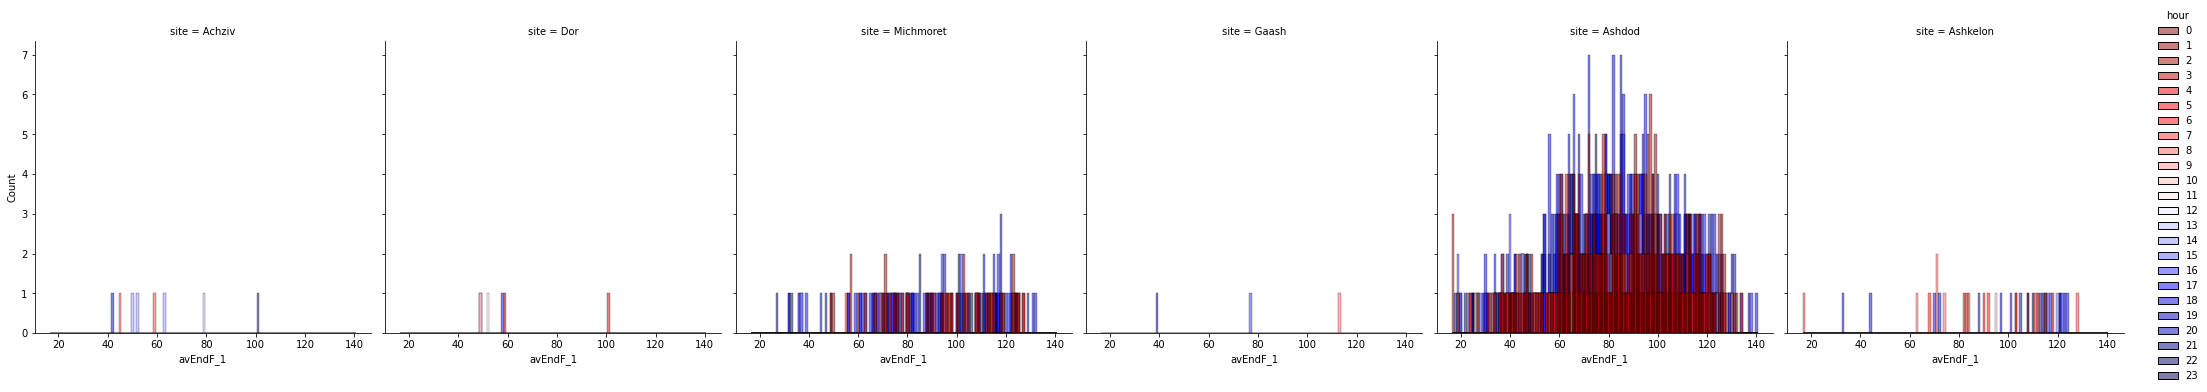

In [ ]:
# sns.displot( Filter_df, x= Filter_df.medianKHz ,hue = 'site', kind="bars")
# plt.xlim(50, 2515)
sns.displot(Filter_df, x= 'avEndF_1',discrete=True,hue = 'hour', element="bars",palette='seismic_r',col="site")

In [ ]:
update_df = f_pod.drop(Filter_df.index.tolist())
c

Time_1  ClksThisMin_1  NofClx_1  medianKHz  avEndF_1  \
4171   2020-01-28 08:52:00         7944.0       8.0       27.0      42.0   
4172   2020-01-28 09:14:00         1536.0      15.0      106.0     142.0   
4173   2020-01-28 09:14:00         1536.0      22.0      104.0     123.0   
4174   2020-01-28 10:29:00         4316.0      11.0      106.0     125.0   
4175   2020-01-28 10:29:00         4316.0       7.0      112.0     128.0   
...                    ...            ...       ...        ...       ...   
614760 2020-05-09 15:55:00         2165.0      26.0       71.0      76.0   
614761 2020-05-09 15:57:00          861.0       8.0       51.0      63.0   
614762 2020-05-09 15:57:00          861.0      17.0       67.0      66.0   
614763 2020-05-09 15:57:00          861.0      46.0      130.0     127.0   
614764 2020-05-09 15:57:00          861.0      10.0       72.0      93.0   

        nRisingIPIs  avSPL_1  avBWx8  TrDur_us_1  MedianPRF  MaxICI_us_1  \
4171            0.0    125.0    15.0    181818.0       44.0       5468.0   
4172            3.0    390.0    15.0   1875000.0        8.0      28874.0   
4173            6.0    406.0    15.0   2750000.0        8.0      29775.0   
4174            0.0    203.0    15.0   1375000.0        8.0      27624.0   
4175            1.0    170.0    15.0   1000000.0        7.0      31122.0   
...             ...      ...     ...         ...        ...          ...   
614760          1.0    195.0    15.0   2363636.0       11.0      19937.0   
614761          0.0    235.0    15.0   1142857.0        7.0      37085.0   
614762          4.0    154.0    15.0    204819.0       83.0       2569.0   
614763          0.0    341.0    15.0    403508.0      114.0       2161.0   
614764          0.0    251.0    15.0   1111111.0        9.0      24667.0   

        ClkNofMinICI  ClkNofMaxICI  NofClstrs_1  avClstrNx8  avclF0  avclF1  \
4171             8.0           2.0          8.0         8.0     0.0     0.0   
4172             5.0           7.0          9.0        68.0   166.0   174.0   
4173             3.0          12.0         17.0        69.0   171.0   140.0   
4174            10.0           2.0          0.0         0.0     0.0     0.0   
4175             4.0           3.0          2.0         8.0     0.0     0.0   
...              ...           ...          ...         ...     ...     ...   
614760           6.0          24.0          8.0        11.0    56.0     0.0   
614761           5.0           8.0          6.0         8.0     0.0     0.0   
614762          17.0           3.0         16.0         8.0     0.0     0.0   
614763          45.0           3.0          8.0        17.0    74.0    90.0   
614764           6.0           2.0          3.0        16.0   133.0   136.0   

        avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  Post2IPIratio  \
4171      125.0            0.50         0.90           0.87           1.81   
4172       36.0            1.21         0.86           1.05           1.05   
4173       38.0            0.00         0.82           1.06           1.03   
4174       38.0            2.56         0.93           1.03           1.30   
4175       38.0            0.97         1.35           1.28           1.41   
...         ...             ...          ...            ...            ...   
614760     60.0            1.03         0.98           1.15           1.42   
614761     70.0            0.89         1.18           0.88           1.07   
614762     60.0            0.60         0.90           0.95           0.88   
614763     36.0            1.42         1.02           1.02           1.16   
614764     47.0            2.35         1.46           1.49           1.50   

        EndIPIratio      site  month  year  hour day365 Minute ClMin_bin  
4171           1.07    Achziv      1  2020     8     28     52       159  
4172           1.22    Achziv      1  2020     9     28     14        31  
4173           1.15    Achziv      1  2020     9     28     14        31  
4174    

In [ ]:
# points_of_cluster_0 = dist[labels==0,:]
# centroid_of_cluster_0 = np.mean(points_of_cluster_0, axis=0) 
# print(centroid_of_cluster_0)

# points_of_cluster_1 = dist[labels==1,:]
# centroid_of_cluster_1 = np.mean(points_of_cluster_1, axis=0)
# print(centroid_of_cluster_1)

AttributeError: 'DBSCAN' object has no attribute 'feature_names_in_'

In [ ]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(df)
dflabels = k_means.labels_
print(dflabels)

[2 4 4 ... 2 3 0]


In [ ]:
rf_pod['km5'] = dflabels

In [ ]:
label = k_means.fit_predict(df)
# label = all_five.dbclus

/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


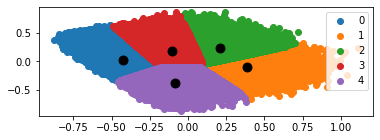

In [ ]:
centroids = k_means.cluster_centers_
u_labels = np.unique(dflabels)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [ ]:
rf_pod.groupby(['km5']).size()


km5
0    149133
1     75100
2    160475
3     48987
4    126033
dtype: int64

In [ ]:
rf_pod.groupby(['km5','site']).size()

km5  site     
0    Achziv          104
     Ashdod       130914
     Ashkelon       1944
     Dor              72
     Gaash            70
     Michmoret     16029
1    Achziv           37
     Ashdod        64110
     Ashkelon       1433
     Dor              13
     Gaash            24
     Michmoret      9483
2    Achziv          108
     Ashdod       142494
     Ashkelon       1409
     Dor              51
     Gaash            73
     Michmoret     16340
3    Achziv           41
     Ashdod        43150
     Ashkelon        292
     Dor              14
     Gaash            19
     Michmoret      5471
4    Achziv           85
     Ashdod       105892
     Ashkelon       1244
     Dor              42
     Gaash            56
     Michmoret     18714
dtype: int64

In [ ]:
# temp =f_pod
# # temp.reset_index(inplace=True, drop=False)
# temp['hour']=temp['Time_1'].apply(lambda x: x.strftime('%H'))


<AxesSubplot:xlabel='hour'>

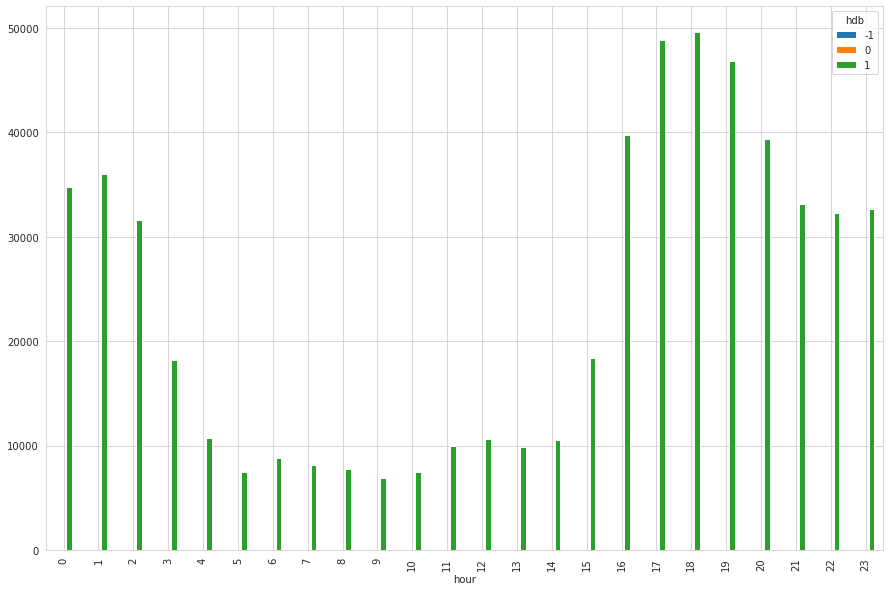

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
rf_pod.groupby(['hour']).hdb.value_counts().unstack().plot(kind='bar')

### DenseClus 


In [ ]:
%matplotlib inline
!pip install Amazon-DenseClus
import warnings
warnings.filterwarnings("ignore")
import joblib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})

from sklearn import metrics
from sklearn import preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=2be47605be14b4dc51a0e2e5de298039904729332cc62a7101e5ed0e3e524c5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-apw_hld0/wheels/4a/66/81/205d77bd58539a1d07fb8b795fcea0b17f4d59912c0f4202b7
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=abe1276e352888844e16acf3c192ada55b3341217ada3dcaebc1ab5aa7644660
  Stored in directory: /tmp/pip-ephem-wheel-cache-apw_hld0/wheels/c0/f0/1d/20aa0dcee54ef40c179a4a4f57fad413437864a67757013a99
Successfully built umap-learn pynndescent


In [ ]:
from denseclus import DenseClus

clf = DenseClus(
    random_state=123321,
    cluster_selection_method="leaf",
    umap_combine_method="intersection_union_mapper"
)

clf.fit(Clus)

SyntaxError: positional argument follows keyword argument (1285505407.py, line 7)

In [ ]:
for i in range(clf.n_components):
    sns.kdeplot(clf.mapper_.embedding_[:, i], shade=True)

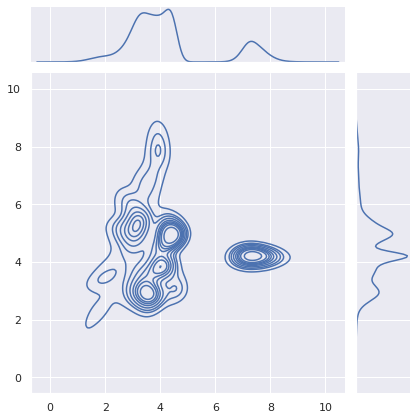

In [ ]:
sns.jointplot(
    x=clf.mapper_.embedding_[:, 0], y=clf.mapper_.embedding_[:, -1], kind="kde")

In [ ]:
labels = clf.score()

print(labels, "\n")
print(pd.DataFrame(labels).value_counts(normalize=True))

[-1  7 -1 ... -1  3  7] 

-1     0.823000
 7     0.083965
 3     0.014698
 4     0.014181
 2     0.012147
 16    0.011023
 15    0.008108
 9     0.006620
 0     0.005385
 10    0.004039
 1     0.003189
 5     0.002743
 13    0.002257
 6     0.001842
 8     0.001792
 12    0.001731
 14    0.001205
 11    0.001053
 17    0.001022
dtype: float64


In [ ]:
labels = clf.score()
samp_pod5['hdbdens'] = labels

In [ ]:
samp_pod5.to_csv('hdbdens_first_Ama1', columns = header)

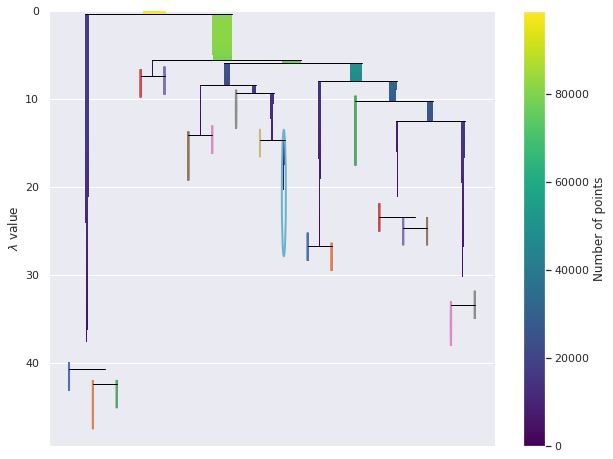

In [ ]:
_ = clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(labels).shape[0]),
)

In [ ]:
numerics = samp_pod5.select_dtypes(include=[int, float]).drop(["hdbdens"], 1).columns.tolist()

samp_pod5[numerics + ["hdbdens"]].groupby(["hdbdens"]).median()

TrnID_1  ClksThisMin_1  NofClx_1  medianKHz  avEndF_1  nRisingIPIs  \
hdbdens                                                                       
-1          16.0         2240.0      10.0       64.0      68.0          0.0   
 0          15.0         2128.0       9.0      114.0     111.0          0.0   
 1          16.0         1993.0      10.0      118.0     118.0          0.0   
 2          16.0         2530.0      10.0      112.0     103.0          0.0   
 3          17.0         2236.0      10.0       67.0      74.0          1.0   
 4          18.0         2293.0      12.0       50.0      55.0          1.0   
 5          19.0         2271.0      11.0       63.0      68.0          0.0   
 6          19.0         2260.5      12.0      119.0     112.0          0.0   
 7          17.0         2279.0      10.0       63.0      64.0          0.0   
 8          16.0         2185.0      11.0       55.0      63.0          2.0   
 9          14.5         2119.0      11.0       61.0      63.0          1.0   
 10         13.0         2011.0      10.0       59.0      63.0          1.0   
 11         17.0         2810.5       9.0       88.0      80.5          0.0   
 12         16.0         2550.0       9.0       58.0      67.0          0.0   
 13         19.0         2533.0       9.0       61.0      64.0          0.0   
 14         16.0         2127.0      10.0       58.0      55.0          0.0   
 15         14.0         2053.0       9.0       50.0      51.0          0.0   
 16         17.0         2546.0      10.0       56.0      63.0          1.0   
 17         20.0         2424.0      10.0       68.0      75.0          1.0   

         avSPL_1  TrDur_us_1  MedianPRF  nICIrising  MinICI_us_1  midpointICI  \
hdbdens                                                                         
-1         170.0    481481.0       21.0         4.0       8272.0       9440.0   
 0         130.0    350000.0       27.0         4.0       6732.0       7333.0   
 1         170.0    444444.0       22.0         4.0       8409.0       9149.0   
 2         121.0     26262.0      400.0         3.0        461.0        483.0   
 3         178.0    833333.0       12.0         4.0      14536.5      16857.0   
 4         130.0     28622.0      444.0         5.0        416.0        448.0   
 5         125.0     27118.0      435.0         4.0        428.0        453.0   
 6         134.0     30781.5      449.5         5.0        422.5        440.0   
 7         113.0     26402.0      416.0         4.0        446.0        467.0   
 8         260.0   1000000.0       10.0         5.0      15957.0      19139.0   
 9         251.0   1000000.0       11.0         5.0      14613.0      18251.0   
 10        251.0   1000000.0       10.0         5.0      15430.0      19102.0   
 11        211.0    759615.0       12.0         4.0      14466.0      16458.0   
 12        235.0    875000.0       11.0         4.0      15532.0      18130.0   
 13        211.0    812500.0       12.0         4.0      13748.0      15840.0   
 14        125.0    264705.0       38.0         4.0       5033.0       5179.0   
 15        130.0    500000.0       19.0         4.0       9218.0      10294.0   
 16        227.0    900000.0       11.0         4.0      14833.0      17466.0   
 17        243.0   1000000.0       11.0         4.0      15452.0      17841.0   

         MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  NofClstrs_1  avClstrNx8  \
hdbdens                                                                     
-1           10933.0           6.0           6.0          5.0         8.0   
 0            8047.0           6.0           5.0          8.0         8.0   
 1            9992.0           6.0           5.0          7.0         8.0   
 2             549.5           5.0           5.0          0.0         0.0   
 3           19431.0           6.0           6.0          6.0        10.0   
 4             485.0           5.0           7.0          0.0         0.0   
 5             497.0           

In [ ]:
samp_pod5.columns

Index(['TrnID_1', 'Time_1', 'ClksThisMin_1', 'NofClx_1', 'medianKHz',
       'avEndF_1', 'nRisingIPIs', 'avSPL_1', 'TrDur_us_1', 'MedianPRF',
       'nICIrising', 'MinICI_us_1', 'midpointICI', 'MaxICI_us_1',
       'ClkNofMinICI', 'ClkNofMaxICI', 'NofClstrs_1', 'avClstrNx8', 'avclF0',
       'avclF1', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio', 'Post1IPIratio',
       'Post2IPIratio', 'EndIPIratio', 'site', 'month', 'year', 'hour',
       'day365', 'Minute', 'dbclus', 'hdbdens'],
      dtype='object')

### By sites

In [ ]:
Mich_median = Ashkelon_hdbout.groupby('hdb').median()
Ashd_median = Ashdod.groupby('hdb').median()
Ashk_median = Ashkelon_hdbout.groupby('hdb').median()
Dor_median = Dor.groupby('hdb').median()
Gaash_median = Gaash.groupby('hdb').median()
Achziv_median = Achziv.groupby('hdb').median()

### Variance threshold

In [ ]:
# selector = VarianceThreshold(0.008)
# selector.fit(asmas_to_model)


In [ ]:
# selector.transform(asmas_to_model)

In [ ]:
# new_columns = asmas_to_model.columns[selector.get_support()]
# new_num_X = asmas_to_model[new_columns]
# new_num_X.columns

NameError: name 'asmas_to_model' is not defined

In [ ]:
# new_num_X.columns

NameError: name 'new_num_X' is not defined

In [ ]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# tt = [ 'ClksThisMin_1','NofClx_1', 'medianKHz', 'avEndF_1', 'avSPL_1',
#        'MaxICI_us_1', 'ClkNofMinICI', 'ClkNofMaxICI', 'NofClstrs_1', 'TrDur_us_1', 'MedianPRF',
#        'avClstrNx8', 'avclF0', 'avclF1', 'avPkIPI', 'BeforeIPIratio',
#        'PreIPIratio', 'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio']
# new_num_X[tt] = scaler.fit_transform(new_num_X[tt])

NameError: name 'new_num_X' is not defined

In [ ]:
# vClus_dataSet = full_pipeline.fit_transform(new_num_X)

In [ ]:
# new_num_X

In [ ]:
# clusterNum = 7
# k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
# k_means.fit(vClus_dataSet)
# labels = k_means.labels_
# print(labels)

In [ ]:
# temp = asmas

In [ ]:
# temp["cluster_7"] = labels
# temp.sample(10)

In [ ]:
from sklearn.manifold import TSNE


In [ ]:
projection = TSNE().fit_transform(Clus)
plt.scatter(*projection.T, **plot_kwds)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(Clus)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

### Feature importance

In [ ]:
Clus["cluster_5"] = labels


In [ ]:
Xf = Clus.drop('cluster_5', axis=1)
yf = Clus['cluster_5']

In [ ]:
# Xf = Clus.drop('site', axis=1)

In [ ]:
# Xxf = full_pipeline.fit_transform(Xf)

In [ ]:
k_means = KMeans(init = "k-means++", n_clusters = 5, n_init = 12).fit(Xf)


#### Permutation importance for feature evaluation [BRE].

The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set. The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

In [ ]:
# # from sklearn.linear_model import LogisticRegression
# from sklearn.inspection import permutation_importance

# # clf = LogisticRegression().fit(Xf, yf)
# result = permutation_importance(k_means, Xxf, yf, n_repeats=10,
#                                 random_state=0)
# print(result.importances_mean)
# result.importances_std


In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(k_means, random_state=1).fit(Xf, yf)
eli5.show_weights(perm, feature_names = Xf.columns.tolist())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 KB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 KB 144.6 MB/s eta 0:00:00


In [ ]:
explained = eli5.explain_weights_df(perm, feature_names = Xf.columns.tolist())

In [ ]:
explained

feature      weight       std
0           avclF1  747.540560  3.339422
1           avclF0  640.596535  3.327466
2        site_ashd  589.196842  5.969837
3        site_ashk  510.427991  7.129999
4          avSPL_1  494.916711  8.174873
5        medianKHz  225.881876  3.392150
6       avClstrNx8  208.596976  1.014893
7         avEndF_1  205.037709  1.699443
8          avPkIPI  107.701889  1.533566
9        MedianPRF  101.149668  0.619407
10   Post2IPIratio   82.892714  0.686830
11   ClksThisMin_1   51.453391  1.682004
12  BeforeIPIratio   35.955753  0.583684
13      TrDur_us_1   19.993140  0.150456
14     MaxICI_us_1   18.988003  0.244323
15   Post1IPIratio   15.233675  0.301350
16     NofClstrs_1    9.327985  0.215433
17     PreIPIratio    4.401413  0.112068
18       site_achz    4.013010  0.094025
19        site_gaa    3.070253  0.063808
20        site_dor    1.748523  0.030344
21     nRisingIPIs    0.524774  0.015416
22        NofClx_1    0.344874  0.030223
23    ClkNofMinICI    0.265031  0.013426
24    ClkNofMaxICI    0.243135  0.010878
25     EndIPIratio    0.212897  0.025696
26          avBWx8    0.000184  0.000186

In [ ]:
# kmeans = KMeans(n_clusters=7)
# cluster_found = kmeans.fit_predict(Clus_dataSet)
# cluster_found_sr = pd.Series(cluster_found, name='cluster')
# asmastt = asmas_to_model.set_index(cluster_found_sr, append=True )

# fig, ax= plt.subplots(1,1, figsize=(18,10))
# color_list = ['blue','red','green', 'yellow', 'orange', 'black', 'purple']
# cluster_values = sorted(asmastt.index.get_level_values('cluster').unique())

# for cluster, color in zip(cluster_values, color_list):
#     asmastt.xs(cluster, level=1).T.plot(
#         ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
#         )
#     asmastt.xs(cluster, level=1).median().plot(
#         ax=ax, color=color, alpha=0.9, ls='--'
#     )

# ax.set_xticks(np.arange(1,25))
# ax.set_ylabel('cluster')
# ax.set_xlabel('hour')
# ax.legend()

In [ ]:
# asmastt = asmas.set_index('cluster_7' )
# cluster_values = sorted(asmastt.index.get_level_values('cluster_7').unique())
# color_list = ['blue','red','green', 'yellow', 'orange', 'black', 'purple']


In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.colors

# tsne = TSNE()
# results_tsne = tsne.fit_transform(Clus_dataSet)

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

# plt.scatter(results_tsne[:,0], results_tsne[:,1],
#     c=asmastt.index.get_level_values('cluster'),
#     cmap=cmap, 
#     alpha=0.6, 
#     )

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D 
# fig = plt.figure(1, figsize=(8, 6))
# plt.clf()
# ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plt.cla()
# # plt.ylabel('Age', fontsize=18)
# # plt.xlabel('Income', fontsize=16)
# # plt.zlabel('Education', fontsize=16)
# ax.set_xlabel('MaxF')
# ax.set_ylabel('MinF')
# ax.set_zlabel('avSlope2')

# ax.scatter(X[:, 17], X[:, 16], X[:, 25], c= labels.astype(np.float))

### The Elbow Method


In [ ]:
# # function returns WSS score for k values from 1 to kmax
# def calculate_WSS(points, kmax):
#   sse = []
#   for k in range(1, kmax+1):
#     kmeans = KMeans(n_clusters = k).fit(points)
#     centroids = kmeans.cluster_centers_
#     pred_clusters = kmeans.predict(points)
#     curr_sse = 0
    
#     # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
#     for i in range(len(points)):
#       curr_center = centroids[pred_clusters[i]]
#       curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
#     sse.append(curr_sse)
#   return sse

In [ ]:
# elbow = calculate_WSS(Clus_dataSet,8)

In [ ]:
# type(elbow)

In [ ]:
# #save results, run took more than 10 min
# import csv 
# rows = [elbow]
# with open('8elbowclust', 'w') as f:
    
#     # using csv.writer method from CSV package
#     write = csv.writer(f)
#     write.writerows(rows)

In [ ]:
# sns.scatterplot(x=[0,1,2,3,4,5,6,7], y=elbow)


From what I understand I'll choose 8 because of the plato afterwards

### The Silhouette Method
The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

In [ ]:
from sklearn.metrics import silhouette_score
sil = []
kmax = 10
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(Clus)
  labels = kmeans.labels_
  sil.append(silhouette_score(Clus, labels))


KeyboardInterrupt: 

In [ ]:
#save results, run took more than 1.5 Hour!!
rows = [sil]
with open('10silclust', 'w') as f:
    
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(rows)

In [ ]:
sns.scatterplot(x=[2,3,4,5,6,7,8,9,10], y=sil)
plt.savefig('sil10.png')


### 5 min average bins 

In [ ]:
tf_pod.site.unique()

array(['Ashdod', 'Michmoret', 'Achziv', 'Ashkelon', 'Dor', 'Gaash'],
      dtype=object)

In [ ]:
Ashd = tf_pod[tf_pod.site.isin(['Ashdod'])].resample('5Min').mean()
Ashd.dropna(inplace=True)
Ashd['site'] = 'ashd'
Ashd 

ClksThisMin_1  NofClx_1   medianKHz   avEndF_1  \
Time_1                                                                
2019-06-23 18:35:00     729.000000     12.00  104.000000  97.000000   
2019-06-23 18:40:00    1857.500000     11.75  105.250000  99.750000   
2019-06-23 18:45:00    1462.000000      8.00   93.000000  72.000000   
2019-06-23 18:50:00    1690.000000     16.25   79.250000  79.500000   
2019-06-23 18:55:00    1158.000000      9.00   76.500000  75.500000   
...                            ...       ...         ...        ...   
2021-08-04 01:45:00    1705.666667     14.00   54.333333  50.333333   
2021-08-04 01:50:00    2054.000000     20.00   68.000000  71.000000   
2021-08-04 08:35:00     764.000000     13.00   62.000000  61.000000   
2021-08-04 09:45:00    1755.000000     20.00  108.000000  96.666667   
2021-08-04 09:50:00    6867.000000     35.00  103.000000  87.000000   

                     nRisingIPIs     avSPL_1  avBWx8    TrDur_us_1  \
Time_1                                                               
2019-06-23 18:35:00     1.000000  211.000000    15.0  1.500000e+06   
2019-06-23 18:40:00     0.750000  257.750000    15.0  1.834821e+06   
2019-06-23 18:45:00     0.000000  211.000000    15.0  1.600000e+06   
2019-06-23 18:50:00     2.000000  263.500000    15.0  2.065476e+06   
2019-06-23 18:55:00     0.000000  235.500000    15.0  9.642855e+05   
...                          ...         ...     ...           ...   
2021-08-04 01:45:00     2.333333  139.000000    15.0  3.888140e+05   
2021-08-04 01:50:00     0.000000  203.000000    15.0  2.666660e+05   
2021-08-04 08:35:00     1.000000  138.000000    15.0  1.444444e+06   
2021-08-04 09:45:00     0.666667  197.333333    15.0  3.294133e+04   
2021-08-04 09:50:00     3.500000  137.500000    15.0  1.873115e+05   

                      MedianPRF  MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  \
Time_1                                                                     
2019-06-23 18:35:00    8.000000     29850.00     10.000000      2.000000   
2019-06-23 18:40:00    6.500000     39163.00      5.250000      7.750000   
2019-06-23 18:45:00    5.000000     42064.00      6.000000      8.000000   
2019-06-23 18:50:00    8.500000     31587.25      6.500000     13.750000   
2019-06-23 18:55:00   13.500000     24495.00      9.000000      3.500000   
...                         ...          ...           ...           ...   
2021-08-04 01:45:00   50.666667      6217.00     10.333333      8.666667   
2021-08-04 01:50:00   75.000000      3091.00      6.000000     20.000000   
2021-08-04 08:35:00    9.000000     26948.00     13.000000      9.000000   
2021-08-04 09:45:00  710.000000       476.00     13.666667      5.000000   
2021-08-04 09:50:00  179.000000      2770.00     12.000000     35.000000   

                     NofClstrs_1  avClstrNx8     avclF0  avclF1    avPkIPI  \
Time_1                                                                       
2019-06-23 18:35:00     3.000000    8.000000   0.000000    0.00  48.000000   
2019-06-23 18:40:00     8.500000   70.000000  85.750000   74.25  54.500000   
2019-06-23 18:45:00     3.000000    8.000000   0.000000    0.00  53.000000   
2019-06-23 18:50:00     6.750000  103.000000  96.750000   74.00  63.500000   
2019-06-23 18:55:00     3.500000   35.000000  63.500000   54.50  52.000000   
...                          ...         ...        ...     ...        ...   
2021-08-04 01:45:00     6.666667   11.333333  30.333333   53.00  78.000000   
2021-08-04 01:50:00     8.000000   13.000000  66.000000   78.00  53.000000   
2021-08-04 08:35:00    10.000000   10.000000  95.000000   62.00  64.000000   
2021-08-04 09:45:00     0.333333   16.000000  21.000000   43.00  45.333333   
2021-08-04 09:50:00    10.000000   17.000000  46.500000   45.50  56.500000   

                     BeforeIPIratio  PreIPIratio  Post1IPIratio  \
Time_1                                                            
2019-06-23 18:35:00        1.680000     1.110000

In [ ]:
Achz = tf_pod[tf_pod.site.isin(['Achziv'])].resample('5Min').mean()
Achz.dropna(inplace=True)
Achz['site'] = 'achz'
Achz 

ClksThisMin_1   NofClx_1   medianKHz   avEndF_1  \
Time_1                                                                 
2019-11-11 22:25:00    4013.277778  13.166667   90.722222  88.555556   
2019-11-11 22:30:00    2423.777778  11.444444   75.111111  71.666667   
2019-11-11 22:35:00    1810.000000  17.500000   95.000000  81.000000   
2019-11-11 22:40:00    2397.986301  31.465753   90.397260  84.013699   
2019-11-11 22:45:00    3979.944444  19.111111   82.000000  71.944444   
...                            ...        ...         ...        ...   
2021-04-02 21:40:00     691.000000  13.000000   43.000000  64.000000   
2021-04-04 19:20:00     891.000000   8.000000   69.000000  69.000000   
2021-04-07 23:00:00    1472.000000   8.000000   58.000000  55.000000   
2021-04-09 19:20:00    1133.000000  13.000000  106.000000  98.000000   
2021-04-10 19:30:00    1877.428571  13.857143   62.000000  69.142857   

                     nRisingIPIs     avSPL_1  avBWx8    TrDur_us_1  \
Time_1                                                               
2019-11-11 22:25:00     1.277778  267.722222    15.0  8.538348e+05   
2019-11-11 22:30:00     1.333333  200.444444    15.0  3.534118e+05   
2019-11-11 22:35:00     0.000000  211.000000    15.0  3.669045e+05   
2019-11-11 22:40:00     1.342466  226.657534    15.0  2.942911e+05   
2019-11-11 22:45:00     1.777778  197.000000    15.0  4.665254e+05   
...                          ...         ...     ...           ...   
2021-04-02 21:40:00     0.333333  194.666667    15.0  1.095598e+06   
2021-04-04 19:20:00     1.000000  357.000000    15.0  1.600000e+06   
2021-04-07 23:00:00     0.000000  308.000000    15.0  1.142857e+06   
2021-04-09 19:20:00     0.000000  292.000000    15.0  2.600000e+06   
2021-04-10 19:30:00     2.285714  221.571429    15.0  1.956632e+06   

                      MedianPRF   MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  \
Time_1                                                                      
2019-11-11 22:25:00   41.666667  15684.333333      8.777778      8.277778   
2019-11-11 22:30:00   55.777778   7377.333333      6.222222      6.555556   
2019-11-11 22:35:00   45.000000   5858.500000      5.500000     14.000000   
2019-11-11 22:40:00  111.013699   2301.835616     16.945205     12.794521   
2019-11-11 22:45:00   50.000000   6324.944444      4.722222     13.444444   
...                         ...           ...           ...           ...   
2021-04-02 21:40:00   12.333333  17678.333333      2.666667     10.333333   
2021-04-04 19:20:00    5.000000  46507.000000      4.000000      7.000000   
2021-04-07 23:00:00    7.000000  36488.000000      7.000000      2.000000   
2021-04-09 19:20:00    5.000000  47374.000000      2.000000      8.000000   
2021-04-10 19:30:00    7.428571  33816.428571      6.857143      7.428571   

                     NofClstrs_1  avClstrNx8      avclF0     avclF1  \
Time_1                                                                
2019-11-11 22:25:00     5.722222   82.388889   67.222222  43.277778   
2019-11-11 22:30:00     7.555556   18.333333   34.444444  20.666667   
2019-11-11 22:35:00    10.000000   10.500000   46.500000  59.500000   
2019-11-11 22:40:00    14.602740   25.123288   60.479452  41.917808   
2019-11-11 22:45:00    11.944444   24.666667   34.333333  31.000000   
...                          ...         ...         ...        ...   
2021-04-02 21:40:00     8.333333   10.000000   47.000000   0.000000   
2021-04-04 19:20:00     6.000000   61.000000   83.000000  56.000000   
2021-04-07 23:00:00     1.000000   48.000000  129.000000  46.000000   
2021-04-09 19:20:00    10.000000   84.000000   81.000000  72.000000   
2021-04-10 19:30:00    11.571429   26.285714   59.428571  38.000000   

                       avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  \
Time_1                                                                       
2019-11-11 22:25:00  59.277778        1.364444     1.035000       0.998333   
2019-11-11 22

In [ ]:
Ashk = tf_pod[tf_pod.site.isin(['Ashkelon'])].resample('5Min').mean()
Ashk.dropna(inplace=True)
Ashk['site'] = 'ashk'
Ashk

ClksThisMin_1   NofClx_1   medianKHz    avEndF_1  \
Time_1                                                                  
2020-03-10 04:45:00    4991.000000  10.000000   65.500000   58.000000   
2020-03-10 05:00:00    4331.625000   9.625000  114.875000   97.750000   
2020-03-12 09:05:00     265.000000  32.000000  119.000000  120.000000   
2020-03-13 08:05:00     393.111111  16.333333  103.555556   99.333333   
2020-03-13 08:10:00     264.000000   8.000000  124.500000   91.000000   
...                            ...        ...         ...         ...   
2021-08-10 21:15:00     870.200000  17.000000   87.400000   93.000000   
2021-08-10 21:20:00     775.000000  14.400000  110.800000   98.000000   
2021-08-10 21:30:00    2681.090909  20.090909   97.727273  102.454545   
2021-08-10 21:35:00    4281.600000  16.200000   90.600000   77.400000   
2021-08-10 21:40:00     560.384615  17.615385  106.846154  108.307692   

                     nRisingIPIs     avSPL_1  avBWx8    TrDur_us_1  \
Time_1                                                               
2020-03-10 04:45:00     1.000000  341.000000    15.0  8.333330e+05   
2020-03-10 05:00:00     0.875000  296.125000    15.0  8.395141e+05   
2020-03-12 09:05:00     2.000000  316.500000    15.0  3.805556e+06   
2020-03-13 08:05:00     2.444444  153.000000    15.0  8.802708e+05   
2020-03-13 08:10:00     1.500000  292.000000    15.0  6.190470e+05   
...                          ...         ...     ...           ...   
2021-08-10 21:15:00     2.400000  283.800000    15.0  1.170555e+06   
2021-08-10 21:20:00     0.600000  182.400000    15.0  5.560690e+05   
2021-08-10 21:30:00     1.181818  176.909091    15.0  6.051916e+05   
2021-08-10 21:35:00     0.400000  236.600000    15.0  6.371734e+05   
2021-08-10 21:40:00     0.692308  135.307692    15.0  1.477431e+05   

                      MedianPRF   MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  \
Time_1                                                                      
2020-03-10 04:45:00   12.000000  18416.500000      6.500000      5.000000   
2020-03-10 05:00:00   11.500000  18392.125000      4.875000      4.875000   
2020-03-12 09:05:00    8.500000  30521.000000     30.500000     10.000000   
2020-03-13 08:05:00   24.222222  10972.000000     12.000000      7.777778   
2020-03-13 08:10:00   13.000000  19314.000000      3.000000      7.500000   
...                         ...           ...           ...           ...   
2021-08-10 21:15:00   23.800000  25234.000000      8.600000     11.600000   
2021-08-10 21:20:00   25.600000   8884.000000      7.600000     10.200000   
2021-08-10 21:30:00  244.818182  12872.454545     16.090909      6.181818   
2021-08-10 21:35:00  170.800000  14085.800000      3.600000     16.200000   
2021-08-10 21:40:00  349.923077   3111.615385     14.307692      8.923077   

                     NofClstrs_1  avClstrNx8      avclF0     avclF1  \
Time_1                                                                
2020-03-10 04:45:00     1.000000   32.000000   48.500000  33.000000   
2020-03-10 05:00:00     4.125000   31.125000  112.125000  58.875000   
2020-03-12 09:05:00     7.500000   44.000000   98.500000  75.500000   
2020-03-13 08:05:00    10.777778   10.888889   34.333333  18.111111   
2020-03-13 08:10:00     4.500000   21.500000   34.500000  22.500000   
...                          ...         ...         ...        ...   
2021-08-10 21:15:00     9.000000   49.400000   67.800000  39.800000   
2021-08-10 21:20:00     7.000000   30.000000   79.800000  48.800000   
2021-08-10 21:30:00     4.818182   23.090909   28.000000  28.636364   
2021-08-10 21:35:00     3.600000   21.800000   29.600000  53.000000   
2021-08-10 21:40:00     1.000000    1.846154    0.000000   0.000000   

                       avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  \
Time_1                                                                       
2020-03-10 04:45:00  62.000000        0.590000     1.005000       0.945000   


In [ ]:
Do = tf_pod[tf_pod.site.isin(['Dor'])].resample('5Min').mean()
Do.dropna(inplace=True)
Do['site'] = 'dor'
Do

ClksThisMin_1   NofClx_1   medianKHz    avEndF_1  \
Time_1                                                                  
2020-06-13 19:05:00    2096.000000  15.333333  116.666667   59.000000   
2020-06-13 20:25:00    2431.000000  13.000000   52.000000   48.000000   
2020-06-16 21:00:00    2121.000000  14.000000   71.000000   83.000000   
2020-06-16 21:40:00    1909.666667  17.333333   37.666667   44.333333   
2020-06-16 23:35:00    2222.000000   9.000000  111.000000   94.000000   
...                            ...        ...         ...         ...   
2021-09-09 08:40:00    2775.000000  10.000000   68.500000   79.000000   
2021-09-10 16:05:00    3159.250000  12.250000   61.000000   60.125000   
2021-09-11 04:45:00    1597.000000  18.000000   69.000000   59.000000   
2021-09-13 07:05:00    5200.000000  16.333333  102.333333   96.000000   
2021-09-13 20:00:00    2622.000000  18.500000   90.500000  102.000000   

                     nRisingIPIs     avSPL_1  avBWx8    TrDur_us_1  \
Time_1                                                               
2020-06-13 19:05:00     0.666667  125.333333    15.0  2.607933e+04   
2020-06-13 20:25:00     0.000000  138.000000    15.0  2.680400e+04   
2020-06-16 21:00:00     0.000000  308.000000    15.0  1.076923e+06   
2020-06-16 21:40:00     0.666667  254.333333    15.0  1.213780e+05   
2020-06-16 23:35:00     0.000000  292.000000    15.0  3.600000e+05   
...                          ...         ...     ...           ...   
2021-09-09 08:40:00     0.500000  268.000000    15.0  2.833333e+06   
2021-09-10 16:05:00     1.000000  198.750000    15.0  6.205604e+05   
2021-09-11 04:45:00     2.000000  292.000000    15.0  2.000000e+06   
2021-09-13 07:05:00     1.000000  238.000000    15.0  4.429293e+05   
2021-09-13 20:00:00     0.500000  223.000000    15.0  4.305550e+05   

                      MedianPRF   MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  \
Time_1                                                                      
2020-06-13 19:05:00  590.333333    362.666667      3.666667     14.666667   
2020-06-13 20:25:00  485.000000    461.000000     10.000000      2.000000   
2020-06-16 21:00:00   13.000000  16700.000000     11.000000      8.000000   
2020-06-16 21:40:00  154.333333   1506.000000      9.000000     10.000000   
2020-06-16 23:35:00   25.000000   8587.000000      8.000000      2.000000   
...                         ...           ...           ...           ...   
2021-09-09 08:40:00    3.500000  89202.000000      6.500000      7.000000   
2021-09-10 16:05:00   32.875000  16456.125000      5.875000      8.625000   
2021-09-11 04:45:00    9.000000  34171.000000     15.000000      4.000000   
2021-09-13 07:05:00   37.000000   7129.666667      3.666667      8.333333   
2021-09-13 20:00:00   43.500000   5997.500000     16.500000      7.500000   

                     NofClstrs_1  avClstrNx8      avclF0     avclF1  \
Time_1                                                                
2020-06-13 19:05:00     0.000000       0.000    0.000000   0.000000   
2020-06-13 20:25:00     1.000000      24.000   68.000000  53.000000   
2020-06-16 21:00:00     4.000000       8.000    0.000000   0.000000   
2020-06-16 21:40:00     6.666667       8.000    0.000000   0.000000   
2020-06-16 23:35:00     5.000000      11.000   28.000000  56.000000   
...                          ...         ...         ...        ...   
2021-09-09 08:40:00     4.000000      12.000   57.000000  31.000000   
2021-09-10 16:05:00     4.125000      15.625   52.250000  31.625000   
2021-09-11 04:45:00    15.000000     896.000   71.000000  43.000000   
2021-09-13 07:05:00     5.333333      43.000  100.666667  48.666667   
2021-09-13 20:00:00     0.500000       4.000    0.000000   0.000000   

                        avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  \
Time_1                                                                        
2020-06-13 19:05:00   49.333333        3.133333     1.553333       0.793333 

In [ ]:
Gaa = tf_pod[tf_pod.site.isin(['Gaash'])].resample('5Min').mean()
Gaa.dropna(inplace=True)
Gaa['site'] = 'gaa'
Gaa

ClksThisMin_1   NofClx_1   medianKHz    avEndF_1  \
Time_1                                                                  
2020-11-07 05:05:00    8923.000000  16.000000   78.000000   59.333333   
2020-11-07 05:10:00    4872.700000  22.800000   98.600000   72.600000   
2020-11-18 07:20:00    3269.000000   9.000000  105.500000   81.000000   
2020-11-19 13:10:00    2099.000000   9.000000   79.500000   93.000000   
2020-11-21 00:30:00    3394.000000  12.166667  110.166667  103.166667   
...                            ...        ...         ...         ...   
2021-02-27 02:15:00    2530.000000  10.000000   56.750000   69.250000   
2021-02-27 02:20:00    3529.142857  14.428571   81.428571   84.571429   
2021-02-27 02:35:00    2963.000000  13.500000   60.500000   69.500000   
2021-02-28 10:20:00    2675.500000  13.500000  136.500000  125.500000   
2021-02-28 22:55:00    2738.000000   9.500000   87.500000   89.000000   

                     nRisingIPIs     avSPL_1  avBWx8    TrDur_us_1  \
Time_1                                                               
2020-11-07 05:05:00     0.000000  183.666667    15.0  1.916667e+06   
2020-11-07 05:10:00     0.300000  188.000000    15.0  2.866071e+06   
2020-11-18 07:20:00     0.000000  349.000000    15.0  1.196428e+06   
2020-11-19 13:10:00     0.500000  357.000000    15.0  2.250000e+06   
2020-11-21 00:30:00     0.333333  340.833333    15.0  3.817993e+05   
...                          ...         ...     ...           ...   
2021-02-27 02:15:00     1.250000  230.250000    15.0  1.285984e+06   
2021-02-27 02:20:00     1.285714  280.571429    15.0  1.742970e+06   
2021-02-27 02:35:00     0.000000  155.500000    15.0  1.397598e+06   
2021-02-28 10:20:00     0.000000  333.000000    15.0  1.313636e+06   
2021-02-28 22:55:00     0.000000  316.500000    15.0  1.055555e+06   

                      MedianPRF   MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  \
Time_1                                                                      
2020-11-07 05:05:00    8.333333  26087.666667      8.666667      9.333333   
2020-11-07 05:10:00    8.000000  27640.700000      9.600000     16.200000   
2020-11-18 07:20:00    7.500000  29530.000000      2.000000      9.000000   
2020-11-19 13:10:00    4.000000  46598.500000      5.000000      7.500000   
2020-11-21 00:30:00   34.000000   8971.666667     10.166667      6.833333   
...                         ...           ...           ...           ...   
2021-02-27 02:15:00   10.500000  30832.250000      4.750000      6.500000   
2021-02-27 02:20:00   10.714286  30033.857143     11.285714      7.714286   
2021-02-27 02:35:00  179.000000  32554.500000     13.500000      4.500000   
2021-02-28 10:20:00   10.500000  21112.500000      5.000000      7.500000   
2021-02-28 22:55:00    9.000000  28393.000000      7.000000      5.500000   

                     NofClstrs_1  avClstrNx8      avclF0      avclF1  \
Time_1                                                                 
2020-11-07 05:05:00     2.666667   14.666667  112.333333   39.333333   
2020-11-07 05:10:00     3.600000   10.500000   28.800000   15.200000   
2020-11-18 07:20:00     6.000000   60.500000   78.500000   60.000000   
2020-11-19 13:10:00     7.000000  243.000000  114.500000   91.000000   
2020-11-21 00:30:00     1.500000    6.666667   18.000000    6.500000   
...                          ...         ...         ...         ...   
2021-02-27 02:15:00     4.500000   19.000000   31.250000   38.500000   
2021-02-27 02:20:00     8.285714   81.000000   59.428571   60.571429   
2021-02-27 02:35:00     3.500000    4.000000    0.000000    0.000000   
2021-02-28 10:20:00     8.000000   43.500000  173.000000  123.000000   
2021-02-28 22:55:00     7.500000   95.500000   91.500000   83.500000   

                       avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  \
Time_1                                                                       
2020-11-07 05:05:00  66.333333        1.076667     1.453333      

In [ ]:
Gaash.head(20)

Time_1  ClksThisMin_1  NofClx_1  medianKHz  avEndF_1  \
78530 2020-11-07 05:09:00         8923.0      18.0       60.0      60.0   
78531 2020-11-07 05:09:00         8923.0      14.0       70.0      49.0   
78532 2020-11-07 05:09:00         8923.0      16.0      104.0      69.0   
78533 2020-11-07 05:10:00         5324.0      34.0      106.0      75.0   
78534 2020-11-07 05:10:00         5324.0      16.0      115.0      67.0   
78535 2020-11-07 05:10:00         5324.0      30.0      115.0      91.0   
78536 2020-11-07 05:10:00         5324.0      43.0      106.0      75.0   
78537 2020-11-07 05:10:00         5324.0      29.0      101.0      74.0   
78538 2020-11-07 05:10:00         5324.0      10.0       88.0      62.0   
78539 2020-11-07 05:10:00         5324.0      12.0       39.0      50.0   
78540 2020-11-07 05:10:00         5324.0      34.0      106.0      62.0   
78541 2020-11-07 05:10:00         5324.0      11.0      112.0      95.0   
78542 2020-11-07 05:11:00          811.0       9.0       98.0      75.0   
78543 2020-11-18 07:21:00         3269.0       8.0      144.0     117.0   
78544 2020-11-18 07:21:00         3269.0      10.0       67.0      45.0   
78545 2020-11-19 13:12:00         2099.0       7.0       92.0     108.0   
78546 2020-11-19 13:12:00         2099.0      11.0       67.0      78.0   
78547 2020-11-21 00:32:00         3394.0       7.0      108.0     110.0   
78548 2020-11-21 00:32:00         3394.0      12.0      112.0      89.0   
78549 2020-11-21 00:32:00         3394.0      21.0      106.0     101.0   

       nRisingIPIs  avSPL_1  avBWx8  TrDur_us_1  MedianPRF  MaxICI_us_1  \
78530          0.0    203.0    15.0   2000000.0        9.0      24520.0   
78531          0.0    162.0    15.0   1750000.0        8.0      26338.0   
78532          0.0    186.0    15.0   2000000.0        8.0      27405.0   
78533          1.0    219.0    15.0   4250000.0        8.0      33449.0   
78534          1.0    195.0    15.0   2285714.0        7.0      28594.0   
78535          0.0    178.0    15.0   3750000.0        8.0      25567.0   
78536          0.0    170.0    15.0   5375000.0        8.0      29155.0   
78537          1.0    251.0    15.0   3625000.0        8.0      26113.0   
78538          0.0    170.0    15.0   1250000.0        8.0      25071.0   
78539          0.0    195.0    15.0   1500000.0        8.0      24926.0   
78540          0.0    178.0    15.0   4250000.0        8.0      32599.0   
78541          0.0    162.0    15.0   1375000.0        8.0      25415.0   
78542          0.0    162.0    15.0   1000000.0        9.0      25518.0   
78543          0.0    373.0    15.0   1142857.0        7.0      28795.0   
78544          0.0    325.0    15.0   1250000.0        8.0      30265.0   
78545          1.0    373.0    15.0   1750000.0        4.0      44317.0   
78546          0.0    341.0    15.0   2750000.0        4.0      48880.0   
78547          0.0    341.0    15.0    500000.0       14.0      17224.0   
78548          0.0    308.0    15.0    480000.0       25.0      16247.0   
78549          2.0    325.0    15.0    512195.0       41.0       5125.0   

       ClkNofMinICI  ClkNofMaxICI  NofClstrs_1  avClstrNx8  avclF0  avclF1  \
78530           9.0          18.0          3.0        21.0   105.0   118.0   
78531          10.0           6.0          2.0        12.0   121.0     0.0   
78532           7.0           4.0          3.0        11.0   111.0     0.0   
78533           2.0          34.0          4.0         8.0     0.0     0.0   
78534           2.0          16.0          2.0         8.0     0.0     0.0   
78535          16.0          18.0          3.0         8.0     0.0     0.0   
78536          30.0          24.0          4.0         8.0     0.0     0.0   
78537          21.0          12.0          7.0        23.0    98.0    70.0   
78538          10.0           3.0          1.0         8.0     0.0     0.0   
78539           2.0           7.0          2.0        16.0    82.0    82.0   
78540    

In [ ]:
Mich = tf_pod[tf_pod.site.isin(['Michmoret'])].resample('5Min').mean()
Mich.dropna(inplace=True)
Mich['site'] = 'Mich'
Mich

ClksThisMin_1   NofClx_1   medianKHz    avEndF_1  \
Time_1                                                                  
2019-07-02 10:55:00    2472.000000  12.500000  114.500000   92.500000   
2019-07-02 11:00:00    1098.500000  12.250000   62.250000   71.250000   
2019-07-02 11:05:00    1656.333333  13.833333  111.833333  106.000000   
2019-07-02 11:10:00    1540.250000  14.875000   92.250000   97.500000   
2019-07-02 11:15:00     337.000000  17.000000  118.000000   87.000000   
...                            ...        ...         ...         ...   
2020-12-05 17:15:00     976.000000  32.000000   40.000000   37.000000   
2020-12-05 17:45:00    2073.000000  14.200000   54.400000   39.400000   
2020-12-05 17:50:00    4803.382979  18.106383   78.468085   70.063830   
2020-12-05 17:55:00    8441.428571  12.857143   67.714286   61.571429   
2020-12-05 18:00:00    1270.636364  19.090909   73.363636   57.727273   

                     nRisingIPIs     avSPL_1  avBWx8    TrDur_us_1  MedianPRF  \
Time_1                                                                          
2019-07-02 10:55:00     2.000000  243.500000    15.0  1.272727e+06   9.500000   
2019-07-02 11:00:00     1.000000  247.500000    15.0  5.305748e+05  40.000000   
2019-07-02 11:05:00     0.666667  272.000000    15.0  1.160052e+06  11.666667   
2019-07-02 11:10:00     0.625000  213.750000    15.0  1.332702e+06  14.125000   
2019-07-02 11:15:00     1.000000  130.000000    15.0  1.700000e+06  10.000000   
...                          ...         ...     ...           ...        ...   
2020-12-05 17:15:00     9.000000  227.000000    15.0  2.000000e+06  16.000000   
2020-12-05 17:45:00     3.000000  232.000000    15.0  8.169772e+05  52.200000   
2020-12-05 17:50:00     1.212766  187.936170    15.0  7.579825e+05  75.276596   
2020-12-05 17:55:00     0.785714  230.928571    15.0  7.604569e+05  24.214286   
2020-12-05 18:00:00     0.909091  197.545455    15.0  5.551917e+05  64.727273   

                      MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  NofClstrs_1  \
Time_1                                                                       
2019-07-02 10:55:00  30482.000000      5.000000      6.500000     6.000000   
2019-07-02 11:00:00   9755.500000      3.000000      8.750000     5.250000   
2019-07-02 11:05:00  20854.000000      6.666667      9.000000     7.000000   
2019-07-02 11:10:00  19183.250000     10.375000      8.875000     6.500000   
2019-07-02 11:15:00  31003.000000     15.000000     13.000000     8.000000   
...                           ...           ...           ...          ...   
2020-12-05 17:15:00  16255.000000      2.000000     14.000000    17.000000   
2020-12-05 17:45:00  14376.200000      4.200000      9.600000     7.000000   
2020-12-05 17:50:00  15276.680851     12.106383      9.765957     5.787234   
2020-12-05 17:55:00  15168.714286      7.571429      7.071429     7.321429   
2020-12-05 18:00:00   7320.363636     15.818182      4.636364     7.818182   

                     avClstrNx8     avclF0      avclF1     avPkIPI  \
Time_1                                                               
2019-07-02 10:55:00   30.500000  96.500000  106.500000   48.000000   
2019-07-02 11:00:00   17.750000  65.500000   80.250000   68.000000   
2019-07-02 11:05:00   43.166667  74.000000   65.333333   40.166667   
2019-07-02 11:10:00   32.250000  51.250000   37.125000   48.875000   
2019-07-02 11:15:00    8.000000   0.000000    0.000000   48.000000   
...                         ...        ...         ...         ...   
2020-12-05 17:15:00   15.000000  30.000000   33.000000  102.000000   
2020-12-05 17:45:00   16.400000  22.000000   19.400000   95.800000   
2020-12-05 17:50:00   23.595745  32.829787   27.468085   66.382979   
2020-12-05 17:55:00   64.178571  60.321429   56.678571   75.214286   
2020-12-05 18:00:00   29.727273  48.000000   38.454545   74.181818   

                     BeforeIPIratio  PreIPIratio  Post1IPIratio  \
Time_1                  

In [ ]:
Mich

ClksThisMin_1   NofClx_1   medianKHz    avEndF_1  \
Time_1                                                                  
2019-07-02 10:55:00    2472.000000  12.500000  114.500000   92.500000   
2019-07-02 11:00:00    1098.500000  12.250000   62.250000   71.250000   
2019-07-02 11:05:00    1656.333333  13.833333  111.833333  106.000000   
2019-07-02 11:10:00    1540.250000  14.875000   92.250000   97.500000   
2019-07-02 11:15:00     337.000000  17.000000  118.000000   87.000000   
...                            ...        ...         ...         ...   
2020-12-05 17:15:00     976.000000  32.000000   40.000000   37.000000   
2020-12-05 17:45:00    2073.000000  14.200000   54.400000   39.400000   
2020-12-05 17:50:00    4803.382979  18.106383   78.468085   70.063830   
2020-12-05 17:55:00    8441.428571  12.857143   67.714286   61.571429   
2020-12-05 18:00:00    1270.636364  19.090909   73.363636   57.727273   

                     nRisingIPIs     avSPL_1  avBWx8    TrDur_us_1  MedianPRF  \
Time_1                                                                          
2019-07-02 10:55:00     2.000000  243.500000    15.0  1.272727e+06   9.500000   
2019-07-02 11:00:00     1.000000  247.500000    15.0  5.305748e+05  40.000000   
2019-07-02 11:05:00     0.666667  272.000000    15.0  1.160052e+06  11.666667   
2019-07-02 11:10:00     0.625000  213.750000    15.0  1.332702e+06  14.125000   
2019-07-02 11:15:00     1.000000  130.000000    15.0  1.700000e+06  10.000000   
...                          ...         ...     ...           ...        ...   
2020-12-05 17:15:00     9.000000  227.000000    15.0  2.000000e+06  16.000000   
2020-12-05 17:45:00     3.000000  232.000000    15.0  8.169772e+05  52.200000   
2020-12-05 17:50:00     1.212766  187.936170    15.0  7.579825e+05  75.276596   
2020-12-05 17:55:00     0.785714  230.928571    15.0  7.604569e+05  24.214286   
2020-12-05 18:00:00     0.909091  197.545455    15.0  5.551917e+05  64.727273   

                      MaxICI_us_1  ClkNofMinICI  ClkNofMaxICI  NofClstrs_1  \
Time_1                                                                       
2019-07-02 10:55:00  30482.000000      5.000000      6.500000     6.000000   
2019-07-02 11:00:00   9755.500000      3.000000      8.750000     5.250000   
2019-07-02 11:05:00  20854.000000      6.666667      9.000000     7.000000   
2019-07-02 11:10:00  19183.250000     10.375000      8.875000     6.500000   
2019-07-02 11:15:00  31003.000000     15.000000     13.000000     8.000000   
...                           ...           ...           ...          ...   
2020-12-05 17:15:00  16255.000000      2.000000     14.000000    17.000000   
2020-12-05 17:45:00  14376.200000      4.200000      9.600000     7.000000   
2020-12-05 17:50:00  15276.680851     12.106383      9.765957     5.787234   
2020-12-05 17:55:00  15168.714286      7.571429      7.071429     7.321429   
2020-12-05 18:00:00   7320.363636     15.818182      4.636364     7.818182   

                     avClstrNx8     avclF0      avclF1     avPkIPI  \
Time_1                                                               
2019-07-02 10:55:00   30.500000  96.500000  106.500000   48.000000   
2019-07-02 11:00:00   17.750000  65.500000   80.250000   68.000000   
2019-07-02 11:05:00   43.166667  74.000000   65.333333   40.166667   
2019-07-02 11:10:00   32.250000  51.250000   37.125000   48.875000   
2019-07-02 11:15:00    8.000000   0.000000    0.000000   48.000000   
...                         ...        ...         ...         ...   
2020-12-05 17:15:00   15.000000  30.000000   33.000000  102.000000   
2020-12-05 17:45:00   16.400000  22.000000   19.400000   95.800000   
2020-12-05 17:50:00   23.595745  32.829787   27.468085   66.382979   
2020-12-05 17:55:00   64.178571  60.321429   56.678571   75.214286   
2020-12-05 18:00:00   29.727273  48.000000   38.454545   74.181818   

                     BeforeIPIratio  PreIPIratio  Post1IPIratio  \
Time_1                  

In [ ]:
all_five = pd.concat([Gaa, Ashd,Mich,Ashk,Achz,Do ])
all_five.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49456 entries, 2020-11-07 05:05:00 to 2021-09-13 20:00:00
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ClksThisMin_1   49456 non-null  float64
 1   NofClx_1        49456 non-null  float64
 2   medianKHz       49456 non-null  float64
 3   avEndF_1        49456 non-null  float64
 4   nRisingIPIs     49456 non-null  float64
 5   avSPL_1         49456 non-null  float64
 6   avBWx8          49456 non-null  float64
 7   TrDur_us_1      49456 non-null  float64
 8   MedianPRF       49456 non-null  float64
 9   MaxICI_us_1     49456 non-null  float64
 10  ClkNofMinICI    49456 non-null  float64
 11  ClkNofMaxICI    49456 non-null  float64
 12  NofClstrs_1     49456 non-null  float64
 13  avClstrNx8      49456 non-null  float64
 14  avclF0          49456 non-null  float64
 15  avclF1          49456 non-null  float64
 16  avPkIPI         49456 non-null  float64
 

In [ ]:
# # create distplots
# # plt.rcParams['figure.figsize'] = [6, 2]
# for col in all_five.columns:
#     plt.figure()             # <==================== important to draw each plo!
#     sns.distplot(all_five[col])

In [ ]:
# # temp.groupby([temp["Time_1"].dt.day]).mean()
    
# fig, ax = plt.subplots( )#nrows = 1, ncols = 3 
# plt.tight_layout()

# paint = temp.groupby([temp["Time_1"].dt.day]).mean()
# small = paint[['NofClx_1', 'medianKHz',
#        'avEndF_1', 'nRisingIPIs',  'avBWx8',
#        'MedianPRF', 'ClkNofMinICI', 'ClkNofMaxICI',
#        'NofClstrs_1', 'avClstrNx8', 'avclF0', 'avclF1', 'avPkIPI',
#        'BeforeIPIratio', 'PreIPIratio', 'Post1IPIratio', 'Post2IPIratio',
#        'EndIPIratio' ]]
# big = paint[['TrDur_us_1']]
# med =paint[['avSPL_1','ClksThisMin_1','MaxICI_us_1']]
# sizes = (small,big) #,small
# small.plot(style="-o", figsize=(10, 5)) 
# med.plot(style="-o", figsize=(10, 5))
# big.plot(style="-o", figsize=(10, 5))


In [ ]:
# pp = sns.pairplot(data=temp,
#                   y_vars=temp.columns,
#                   x_vars=['hour'])

In [ ]:
#Sample plotting
# temp = tf_pod.loc['2020-03-10 04:49:00']
# temp = tf_pod[(tf_pod.site.isin(['Ashkelon']))]
# sns.set_style("darkgrid") #darkgrid 
# temp.groupby(
#     [temp["Time_1"].dt.hour, "site"]).TrDur_us_1.size().unstack().plot(c='b', figsize=(10, 5))# style="-o"
# # plt.xticks(rotation=45)


In [ ]:
# # create distplots
# plt.rcParams['figure.figsize'] = [6, 2]
# for col in temp.columns:
#     plt.figure()             # <==================== important to draw each plo!
#     sns.distplot(temp[col],color = 'b')

In [ ]:
# X = asmas.values[:,0:]
# X = np.nan_to_num(X) #replace nan to 0
# Clus_dataSet = StandardScaler().fit_transform(X)
# Clus_dataSet

#### 5 min bins trials dbscan

In [ ]:
Ashkelon.groupby(['dbclus']).size()

dbclus
-1     1118
 0     5068
 1       12
 2       14
 3        4
 4       11
 5       10
 6       10
 7       10
 8        4
 9        9
 10       4
 11       4
 12       5
 13       5
 14       6
 15       6
 16       5
 17       8
 18       5
 19       4
dtype: int64

In [ ]:
f_pod.groupby('dbclus').nunique()

In [ ]:
f_pod.groupby(['dbclus','site']).size()

In [ ]:
temp =all_five
temp.reset_index(inplace=True, drop=True)

In [ ]:
temp

Time_1  ClksThisMin_1   NofClx_1   medianKHz  avEndF_1  \
0     2019-06-23 18:35:00         729.00  12.000000  104.000000    97.000   
1     2019-06-23 18:40:00        1857.50  11.750000  105.250000    99.750   
2     2019-06-23 18:45:00        1462.00   8.000000   93.000000    72.000   
3     2019-06-23 18:50:00        1690.00  16.250000   79.250000    79.500   
4     2019-06-23 18:55:00        1158.00   9.000000   76.500000    75.500   
...                   ...            ...        ...         ...       ...   
49451 2021-09-09 08:40:00        2775.00  10.000000   68.500000    79.000   
49452 2021-09-10 16:05:00        3159.25  12.250000   61.000000    60.125   
49453 2021-09-11 04:45:00        1597.00  18.000000   69.000000    59.000   
49454 2021-09-13 07:05:00        5200.00  16.333333  102.333333    96.000   
49455 2021-09-13 20:00:00        2622.00  18.500000   90.500000   102.000   

       nRisingIPIs  avSPL_1  avBWx8    TrDur_us_1  MedianPRF   MaxICI_us_1  \
0             1.00   211.00    15.0  1.500000e+06      8.000  29850.000000   
1             0.75   257.75    15.0  1.834821e+06      6.500  39163.000000   
2             0.00   211.00    15.0  1.600000e+06      5.000  42064.000000   
3             2.00   263.50    15.0  2.065476e+06      8.500  31587.250000   
4             0.00   235.50    15.0  9.642855e+05     13.500  24495.000000   
...            ...      ...     ...           ...        ...           ...   
49451         0.50   268.00    15.0  2.833333e+06      3.500  89202.000000   
49452         1.00   198.75    15.0  6.205604e+05     32.875  16456.125000   
49453         2.00   292.00    15.0  2.000000e+06      9.000  34171.000000   
49454         1.00   238.00    15.0  4.429293e+05     37.000   7129.666667   
49455         0.50   223.00    15.0  4.305550e+05     43.500   5997.500000   

       ClkNofMinICI  ClkNofMaxICI  NofClstrs_1  avClstrNx8      avclF0  \
0         10.000000      2.000000     3.000000       8.000    0.000000   
1          5.250000      7.750000     8.500000      70.000   85.750000   
2          6.000000      8.000000     3.000000       8.000    0.000000   
3          6.500000     13.750000     6.750000     103.000   96.750000   
4          9.000000      3.500000     3.500000      35.000   63.500000   
...             ...           ...          ...         ...         ...   
49451      6.500000      7.000000     4.000000      12.000   57.000000   
49452      5.875000      8.625000     4.125000      15.625   52.250000   
49453     15.000000      4.000000    15.000000     896.000   71.000000   
49454      3.666667      8.333333     5.333333      43.000  100.666667   
49455     16.500000      7.500000     0.500000       4.000    0.000000   

          avclF1     avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  \
0       0.000000   48.000000           1.680     1.110000        1.32000   
1      74.250000   54.500000           1.845     1.155000        1.00250   
2       0.000000   53.000000           1.310     1.200000        0.77000   
3      74.000000   63.500000           1.650     1.035000        1.18250   
4      54.500000   52.000000           2.190     1.515000        0.95000   
...          ...         ...             ...          ...            ...   
49451  31.000000   69.000000           1.270     0.975000        1.03500   
49452  31.625000   88.500000           1.345     1.006250        0.99375   
49453  43.000000  105.000000           1.010     0.970000        1.05000   
49454  48.666667   56.666667           1.860     0.936667        1.34000   
49455   0.000000   54.500000           1.635     0.945000        1.31500   

       Post2IPIratio  EndIPIratio  site  cluster_5 hour  
0           1.260000       0.9400  ashd          2   18  
1           1.230000       1.0500  ashd          0   18  
2           1.470000       0.8400  ashd          2   18  
3           1.480000       1.0200  ashd          0   18  
4           1.015000       0.8400  ashd          4   18  
...    

In [ ]:
temp['hour']=temp['Time_1'].apply(lambda x: x.strftime('%H'))
temp

Time_1  ClksThisMin_1   NofClx_1   medianKHz  avEndF_1  \
0     2019-06-23 18:35:00         729.00  12.000000  104.000000    97.000   
1     2019-06-23 18:40:00        1857.50  11.750000  105.250000    99.750   
2     2019-06-23 18:45:00        1462.00   8.000000   93.000000    72.000   
3     2019-06-23 18:50:00        1690.00  16.250000   79.250000    79.500   
4     2019-06-23 18:55:00        1158.00   9.000000   76.500000    75.500   
...                   ...            ...        ...         ...       ...   
49451 2021-09-09 08:40:00        2775.00  10.000000   68.500000    79.000   
49452 2021-09-10 16:05:00        3159.25  12.250000   61.000000    60.125   
49453 2021-09-11 04:45:00        1597.00  18.000000   69.000000    59.000   
49454 2021-09-13 07:05:00        5200.00  16.333333  102.333333    96.000   
49455 2021-09-13 20:00:00        2622.00  18.500000   90.500000   102.000   

       nRisingIPIs  avSPL_1  avBWx8    TrDur_us_1  MedianPRF   MaxICI_us_1  \
0             1.00   211.00    15.0  1.500000e+06      8.000  29850.000000   
1             0.75   257.75    15.0  1.834821e+06      6.500  39163.000000   
2             0.00   211.00    15.0  1.600000e+06      5.000  42064.000000   
3             2.00   263.50    15.0  2.065476e+06      8.500  31587.250000   
4             0.00   235.50    15.0  9.642855e+05     13.500  24495.000000   
...            ...      ...     ...           ...        ...           ...   
49451         0.50   268.00    15.0  2.833333e+06      3.500  89202.000000   
49452         1.00   198.75    15.0  6.205604e+05     32.875  16456.125000   
49453         2.00   292.00    15.0  2.000000e+06      9.000  34171.000000   
49454         1.00   238.00    15.0  4.429293e+05     37.000   7129.666667   
49455         0.50   223.00    15.0  4.305550e+05     43.500   5997.500000   

       ClkNofMinICI  ClkNofMaxICI  NofClstrs_1  avClstrNx8      avclF0  \
0         10.000000      2.000000     3.000000       8.000    0.000000   
1          5.250000      7.750000     8.500000      70.000   85.750000   
2          6.000000      8.000000     3.000000       8.000    0.000000   
3          6.500000     13.750000     6.750000     103.000   96.750000   
4          9.000000      3.500000     3.500000      35.000   63.500000   
...             ...           ...          ...         ...         ...   
49451      6.500000      7.000000     4.000000      12.000   57.000000   
49452      5.875000      8.625000     4.125000      15.625   52.250000   
49453     15.000000      4.000000    15.000000     896.000   71.000000   
49454      3.666667      8.333333     5.333333      43.000  100.666667   
49455     16.500000      7.500000     0.500000       4.000    0.000000   

          avclF1     avPkIPI  BeforeIPIratio  PreIPIratio  Post1IPIratio  \
0       0.000000   48.000000           1.680     1.110000        1.32000   
1      74.250000   54.500000           1.845     1.155000        1.00250   
2       0.000000   53.000000           1.310     1.200000        0.77000   
3      74.000000   63.500000           1.650     1.035000        1.18250   
4      54.500000   52.000000           2.190     1.515000        0.95000   
...          ...         ...             ...          ...            ...   
49451  31.000000   69.000000           1.270     0.975000        1.03500   
49452  31.625000   88.500000           1.345     1.006250        0.99375   
49453  43.000000  105.000000           1.010     0.970000        1.05000   
49454  48.666667   56.666667           1.860     0.936667        1.34000   
49455   0.000000   54.500000           1.635     0.945000        1.31500   

       Post2IPIratio  EndIPIratio  site  cluster_5 hour  
0           1.260000       0.9400  ashd          2   18  
1           1.230000       1.0500  ashd          0   18  
2           1.470000       0.8400  ashd          2   18  
3           1.480000       1.0200  ashd          0   18  
4           1.015000       0.8400  ashd          4   18  
...    

In [ ]:
# plt.rcParams['figure.figsize'] = [15, 10]
f_pod.groupby(['hour','dbclus']).medianKHz.median().unstack().plot()

In [ ]:
f_pod.groupby(['hour','dbclus']).NofClx_1.median().unstack().plot()

In [ ]:
# temp.groupby(['month','cluster_7']).ClksThisMin_1.median().unstack().plot()

<AxesSubplot:xlabel='hour'>

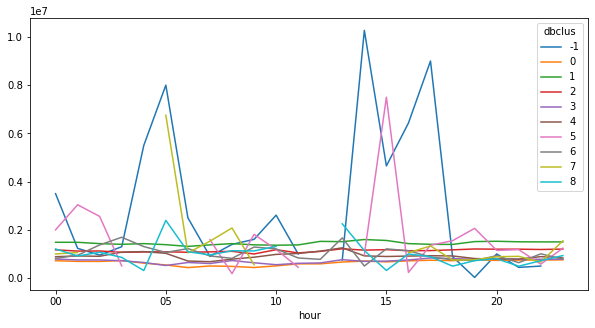

In [ ]:
all_five.groupby(['hour','dbclus']).TrDur_us_1.median().unstack().plot()

In [ ]:
f_pod.groupby(['hour','dbclus']).MedianPRF.median().unstack().plot()


<AxesSubplot:xlabel='hour'>

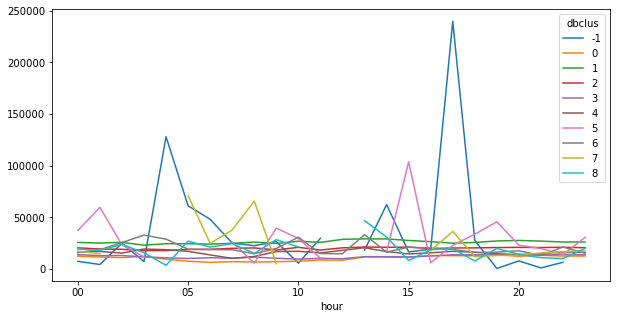

In [ ]:
all_five.groupby(['hour','dbclus']).MaxICI_us_1.median().unstack().plot()


<AxesSubplot:xlabel='hour'>

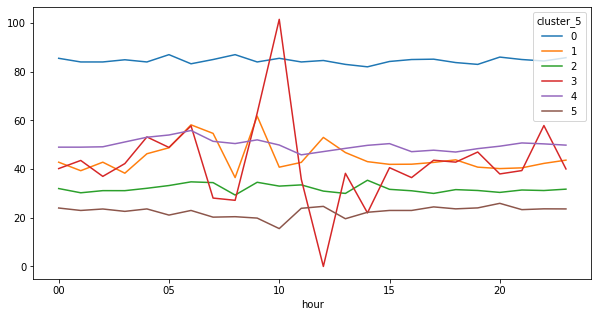

In [ ]:
temp.groupby(['hour','cluster_5']).avclF1.median().unstack().plot()

In [ ]:
all_five = all_five.set_index('Time_1', drop = False)
all_five.index = pd.to_datetime(all_five.index)
all_five = all_five.sort_index()


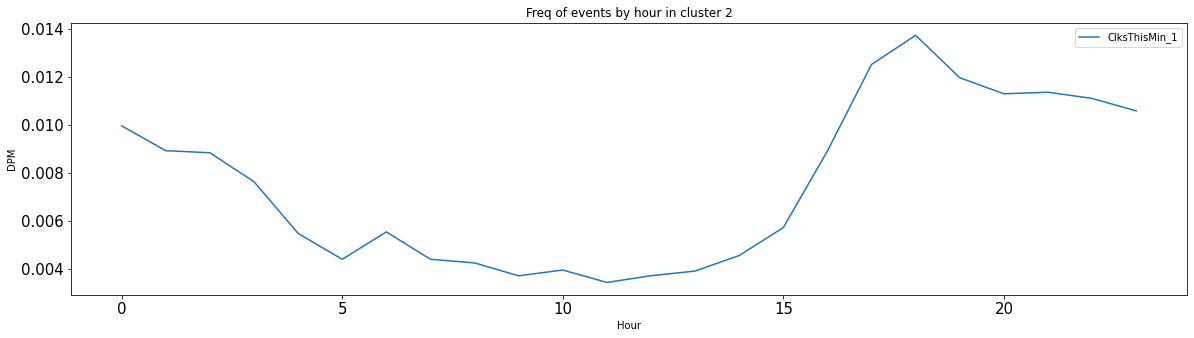

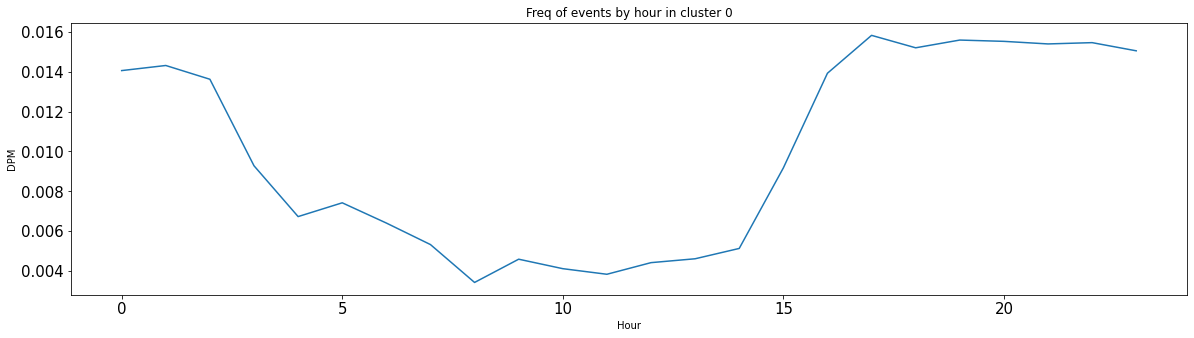

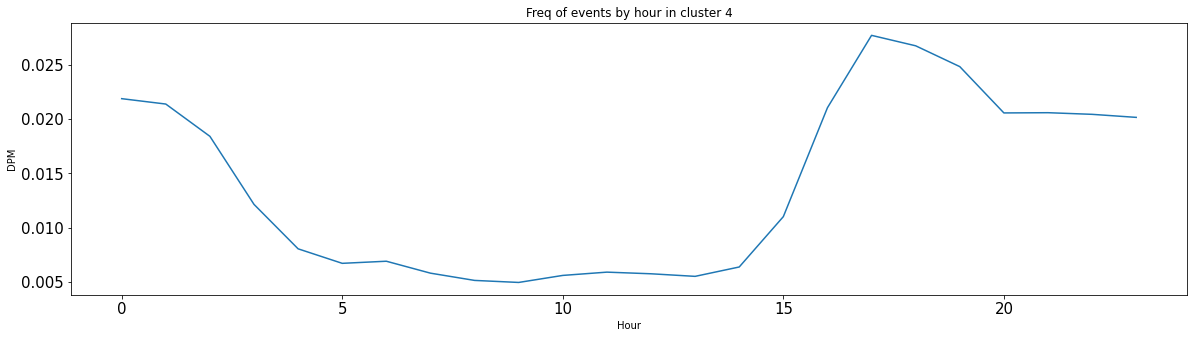

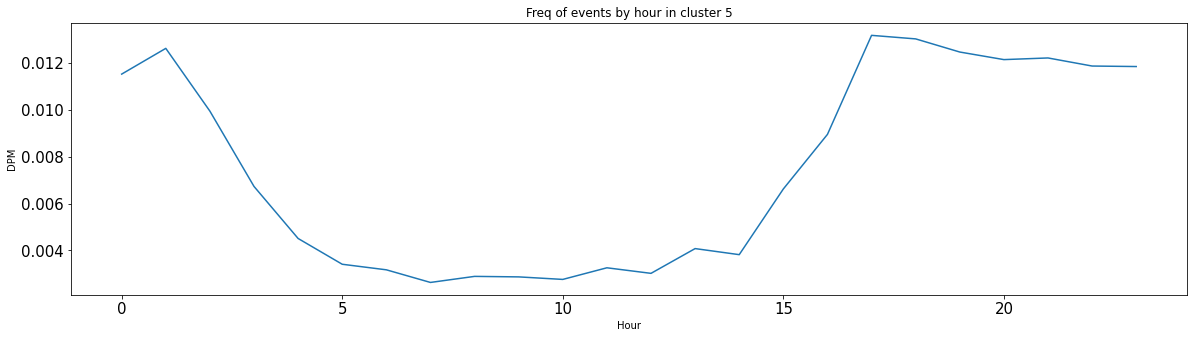

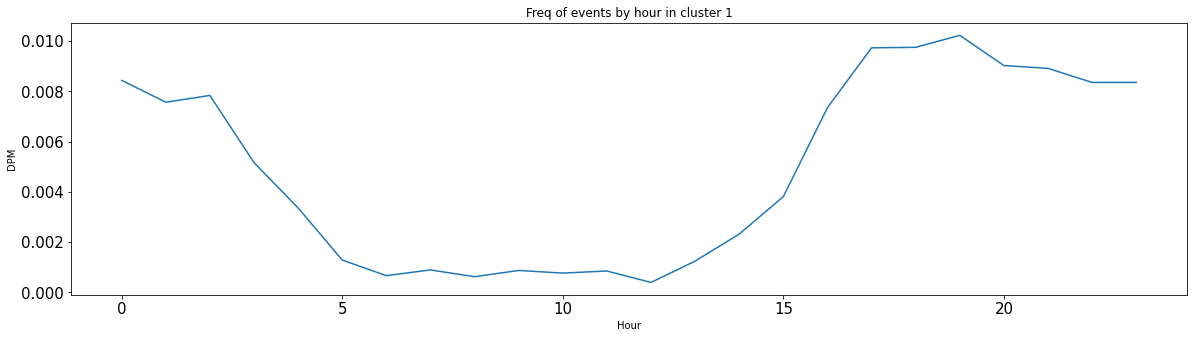

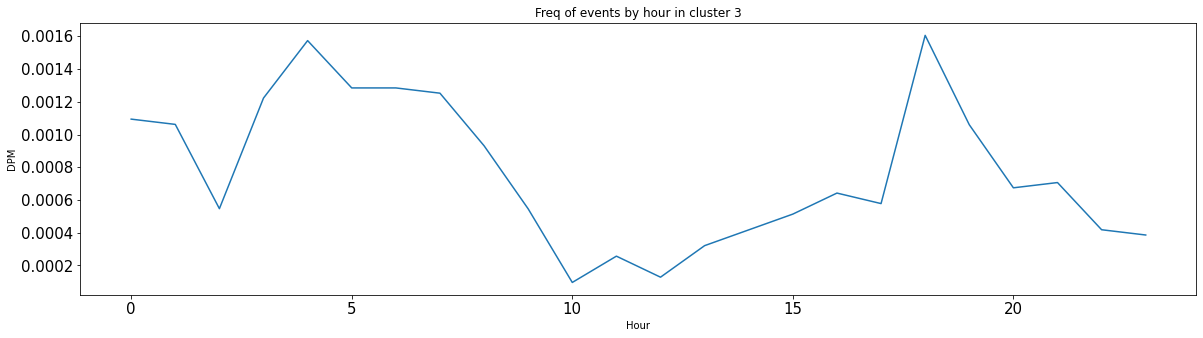

In [ ]:
temp = all_five.cluster_5.unique()
fig, ax = plt.subplots(sharex = True)
for c in temp:
    site =  all_five[all_five.cluster_5.isin([c])]
    DPM = (site.resample('Min').count()/site.resample('Min').count())
    DPM = DPM.resample('60Min').count()/60
    DPM['Time_1'] = DPM.index
    DPM.groupby([DPM["Time_1"].dt.hour]).ClksThisMin_1.mean().plot( ylabel = 'DPM' ,  xlabel = 'Hour', fontsize= 15, title = f'Freq of events by hour in cluster {c}'  ,figsize = (20,5) )
    ax.legend()
    plt.show()


In [ ]:
all_five.groupby('cluster_5').describe()

ClksThisMin_1                                                \
                  count         mean          std    min          25%   
cluster_5                                                               
0               12054.0  1667.996568  1290.219416   30.0   775.672222   
1               14327.0  1842.308188  1766.810838   43.0   693.000000   
2                5688.0  2251.792783  1951.660790   61.0   878.964286   
3               16808.0  2828.325138  2242.029169   19.0  1262.137500   
4                 579.0  2930.812144  3184.538499  146.0   847.666667   

                                             NofClx_1                        \
                   50%          75%      max    count       mean        std   
cluster_5                                                                     
0          1361.343750  2216.904891  16346.0  12054.0  16.429252   7.549673   
1          1359.000000  2429.342857  16110.0  14327.0  16.867477  10.119596   
2          1846.900000  2980.289080  15553.0   5688.0  16.422877   7.002932   
3          2280.285714  3728.321429  16316.0  16808.0  17.202283   7.176140   
4          1713.833333  3555.500000  16302.0    579.0  14.990394   7.678647   

                                                       medianKHz             \
           min        25%        50%        75%    max     count       mean   
cluster_5                                                                     
0          5.0  12.000000  14.920722  18.750000  126.0   12054.0  62.586867   
1          5.0  11.000000  14.333333  19.222222  194.0   14327.0  86.335021   
2          5.0  12.250000  15.090537  18.750000  120.0    5688.0  82.859304   
3          5.0  13.248975  15.705882  19.142857  135.0   16808.0  85.589283   
4          6.0  10.500000  13.600000  16.890988   93.0     579.0  87.569549   

                            ... Post1IPIratio                            \
                 std   min  ...           25%       50%       75%   max   
cluster_5                   ...                                           
0          11.469147  19.0  ...      0.906038  1.002922  1.092385  3.57   
1          19.283260  29.0  ...      1.000000  1.081111  1.172500  2.83   
2          19.779181  21.0  ...      0.948740  1.036235  1.120000  2.56   
3          12.976120  42.0  ...      0.984353  1.058095  1.125000  2.66   
4          24.421534  21.0  ...      0.935833  1.027500  1.110000  1.86   

          Post2IPIratio                                               \
                  count      mean       std  min       25%       50%   
cluster_5                                                              
0               12054.0  0.855923  0.366609  0.0  0.682000  0.880000   
1               14327.0  1.178540  0.303951  0.0  1.010000  1.155000   
2                5688.0  0.946891  0.358429  0.0  0.787500  0.964202   
3               16808.0  0.968442  0.265325  0.0  0.849321  0.990000   
4                 579.0  0.911914  0.413179  0.0  0.724423  0.936667   

                          EndIPIratio                                       \
                75%   max       count      mean       std    min       25%   
cluster_5                                                                    
0          1.051976  3.39     12054.0  0.965553  0.115162  0.430  0.907500   
1          1.320000  4.45     14327.0  0.959489  0.094641  0.470  0.904306   
2          1.133333  3.25      5688.0  0.959136  0.096722  0.420  0.910000   
3          1.114023  2.60     16808.0  0.945359  0.086985  0.340  0.905385   
4          1.140000  2.69       579.0  0.965884  0.111802  0.465  0.905000   

                                     
                50%       75%   max  
cluster_5                            
0          0.970000  1.020000  2.98  
1          0.960000  1.010000  1.86  
2          0.962500  1.005833  1.98  
3          0.955556  0.992945  1.91  
4          0.970000  1.012638  1.52  

[5 rows x 176 columns]

In [ ]:
# fig = plt.figure(figsize=(20,15))
# #plt.rcParams['font.size'] = 22
# ax = plt.axes(projection="3d")
# z_points = Ashdod.MaxICI_us_1
# x_points = Ashdod.hour
# y_points = Ashdod.TrDur_us_1
# f1=ax.scatter3D(x_points, y_points, z_points, c=clusters ,cmap='Accent',s=300);

# ax.set_xlabel("hour",fontsize = 20)
# ax.set_ylabel("TrDur_us_1",fontsize = 20)
# ax.set_zlabel("MaxICI_us_1",fontsize = 20)
# ax.legend(clusters)

# plt.title('KMeans ',fontsize = 24)
# plt.show()

In [ ]:
# fig = plt.figure(figsize=(20,15))
# #plt.rcParams['font.size'] = 22
# ax = plt.axes(projection="3d")
# z_points = Ashdod.TrDur_us_1
# x_points = Ashdod.ClksThisMin_1
# y_points = Ashdod.hour
# f1=ax.scatter3D(x_points, y_points, z_points, c=clusters ,cmap='Accent',s=300);

# ax.set_xlabel("ClksThisMin_1",fontsize = 20)
# ax.set_ylabel("hour",fontsize = 20)
# ax.set_zlabel("TrDur_us_1",fontsize = 20)
# ax.legend(clusters)

# plt.title('KMeans ',fontsize = 24)
# plt.show()